# Import

In [1]:
import gc
import json
import random
import matplotlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import hyperopt
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from scipy.sparse import csr_matrix
from tqdm import tqdm_notebook as tqdm
from typing import Dict, Tuple, List
from collections import Counter, defaultdict
from numba import jit 
from IPython.display import display # Allows the use of display() for DataFrames
from IPython.core.display import display, HTML
from pylab import rcParams


warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:80% !important; }</style>")) # 表示画面サイズ変更

# ①日本語を表示するためのフォントの指定
# print([f.name for f in fm.fontManager.ttflist])
# ②日本語フォントがない場合
# print(matplotlib.matplotlib_fname())
# ③上記で表示されたフォルダのパスの途中(.../mpl-data/fonts/ttf)に.ttfを格納し、下記を実行
# print(matplotlib.get_cachedir())
# ④上記フォルダ内の"fontlist~.json"を削除して下記でリビルド
# matplotlib.font_manager._rebuild()
# ⑤フォントの一覧に.ttfで追加したフォントが表示されるはず

In [2]:
rcParams["figure.figsize"] = (14, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.6, font=["IPAPGothic"], rc={"lines.linewidth": 2})
sns.set_palette(sns.color_palette(["#42A5F5", "#FFA726", "#66BB6A", "#AB47BC", "#EF5350", "#FFEE58", "#8D6E63", \
                                   "#78909C", "#26C6DA", "#26A69A", "#5C6BC0", "#FF80AB", "#C6FF00", "#BDBDBD"]))

In [3]:
data_dir = None
if _dh == ["/kaggle/working"]:
    data_dir = "/kaggle/input/competition_name/"
else:
    data_dir = "data/m5-forecasting-accuracy/"

# Read data

- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

Not available yet:
- `sales_train_evaluation.csv` - Available one month before competition deadline. Will include sales [d_1 - d_1941]

**File 1: “calendar.csv”**<br>
Contains information about the dates on which the products are sold.
- `date`: The date in a “y-m-d” format.
- `wm_yr_wk`: The id of the week the date belongs to.
- `weekday`: The type of the day (Saturday, Sunday, …, Friday).
- `wday`: The id of the weekday, starting from Saturday.
- `month`: The month of the date.
- `year`: The year of the date.
- `d`: d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 
- `event_name_1`: If the date includes an event, the name of this event.
- `event_type_1`: If the date includes an event, the type of this event.
- `event_name_2`: If the date includes a second event, the name of this event.
- `event_type_2`: If the date includes a second event, the type of this event.
- `snap_CA, snap_TX, and snap_WI`: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed. <br>
※SNAP is federal program that provides food-purchasing assistance for low- and no-income people.


**File 2: “sell_prices.csv”** <br>
Contains information about the price of the products sold per store and date.
- `store_id`: The id of the store where the product is sold. 
- `item_id`: The id of the product.
- `wm_yr_wk`: The id of the week.
- `sell_price`: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


**File 3: “sales_train_validation.csv”**<br>
Contains the historical daily unit sales data per product and store.
- `item_id`: The id of the product.
- `dept_id`: The id of the department the product belongs to.
- `cat_id`: The id of the category the product belongs to.
- `store_id`: The id of the store where the product is sold.
- `state_id`: The State where the store is located.
- `d_1, d_2, …, d_i, … d_1941`: The number of units sold at day i, starting from 2011-01-29.
    - `d_1914 - d_1941` represents the validation rows which we will predict in stage 1
    - `d_1942 - d_1969` represents the evaluation rows which we will predict for the final competition standings.


In [4]:
# calendar_df = pd.read_csv(data_dir + "calendar.csv")
# calendar_df = pd.read_pickle(data_dir + "calendar.pkl")
# calendar_df

In [5]:
# price_df = pd.read_csv(data_dir + "sell_prices.csv")
# price_df = pd.read_pickle(data_dir + "price.pkl")
# price_df

In [6]:
# train_df = pd.read_csv(data_dir + "sales_train_validation.csv")
# train_df = pd.read_pickle(data_dir + "train.pkl")
# train_df

In [7]:
submission = pd.read_csv(data_dir + "sample_submission.csv")
submission

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
0      HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
1      HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
2      HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
3      HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
4      HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
...                              ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   
60975    FOODS_3_823_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60976    FOODS_3_824_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60977    FOODS_3_825_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60978    FOODS_3_826_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60979    FOODS_3_827_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   

       F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
0        0    0    0    0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
60975    0    0    0    0    0    0    0    0    0    0  
60976    0    0    0    0    0    0    0    0    0    0  
60977    0    0    0    0    0    0    0    0    0    0  
60978    0    0    0    0    0    0    0    0    0    0  
60979    0    0    0    0    0    0    0    0    0    0  

[60980 rows x 29 columns]

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# calendar_df = reduce_mem_usage(calendar_df)
# price_df = reduce_mem_usage(price_df)
# train_df = reduce_mem_usage(train_df)

In [9]:
# calendar_df.to_pickle(data_dir + "calendar.pkl")
# price_df.to_pickle(data_dir + "price.pkl")
# train_df.to_pickle(data_dir + "train.pkl")

In [10]:
gc.collect()

40

# Processing

In [11]:
# 最終的にはd_1942 - d_1969が評価期間になるので、再度実行する必要あり
# 32GBメモリでも厳しいので、あらかじめカテゴリは置換してね
# for day in range(1914, 1942, 1):
#     train_df[f"d_{day}"] = np.nan

In [12]:
# train_df = pd.melt(train_df,
#                    id_vars = ["id", "item_id", "dept_id","store_id", "cat_id", "state_id"],
#                    value_vars = [col for col in train_df.columns if col.startswith("d_")],
#                    var_name = "d",
#                    value_name = "sales")
# train_df

In [13]:
# train_df = train_df.merge(calendar_df, on="d", copy=False)
# train_df

In [14]:
# train_df = train_df.merge(price_df, on=["store_id", "item_id", "wm_yr_wk"], copy=False)
# train_df

In [15]:
# train_df.to_pickle(data_dir + "all_data.pkl")

In [16]:
# all_df = pd.read_pickle(data_dir + "all_data.pkl")
# all_df

In [17]:
# all_df["date"] = pd.to_datetime(all_df["date"])
# all_df.drop("weekday", axis=1, inplace=True)

In [18]:
# all_df.info()

# Feature Engineering

In [19]:
# train_df.isnull().sum()

# id                     0
# item_id                0
# dept_id                0
# store_id               0
# cat_id                 0
# state_id               0
# d                      0
# sales                  0
# date                   0
# wm_yr_wk               0
# weekday                0
# wday                   0
# month                  0
# year                   0
# event_name_1    42341567
# event_type_1    42341567
# event_name_2    45933474
# event_type_2    45933474
# snap_CA                0
# snap_TX                0
# snap_WI                0
# sell_price             0
# dtype: int64

In [20]:
def cleansing(df):
    return df

def add_features(df):
    
    # Null features
    # for c in df.columns[df.isnull().sum() > 0]:
    #     df[c + "_null"] = df[c].isnull().astype(int)    
    # df["nulls"] = df.isnull().sum(axis=1)
    
    return df

def encode_categories(df):
    for c in categoricals:
        if c == "id": continue # idは順序ソートのためにそのままにしておく
        df[c] = df[c].astype("category")
        df[c] = df[c].cat.codes.astype("int16")
        df[c] -= df[c].min() # -1となるNaNをゼロにする
    return df

In [21]:
# all_df = cleansing(all_df)

In [22]:
# all_df = add_features(all_df)

In [23]:
# categoricals = ["id", "item_id", "dept_id", "store_id", "cat_id", "state_id", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]
# all_df = encode_categories(all_df)

In [24]:
# all_df.to_pickle(data_dir + "all_data_encoded_except_id.pkl")

In [25]:
all_df = pd.read_pickle(data_dir + "all_data_encoded_except_id.pkl")
all_df

id  item_id  dept_id  store_id  cat_id  \
0         HOBBIES_1_008_CA_1_validation     1444        3         0       1   
1         HOBBIES_1_008_CA_1_validation     1444        3         0       1   
2         HOBBIES_1_008_CA_1_validation     1444        3         0       1   
3         HOBBIES_1_008_CA_1_validation     1444        3         0       1   
4         HOBBIES_1_008_CA_1_validation     1444        3         0       1   
...                                 ...      ...      ...       ...     ...   
46881672    FOODS_3_825_WI_3_validation     1434        2         9       0   
46881673    FOODS_3_826_WI_3_validation     1435        2         9       0   
46881674    FOODS_3_826_WI_3_validation     1435        2         9       0   
46881675    FOODS_3_827_WI_3_validation     1436        2         9       0   
46881676    FOODS_3_827_WI_3_validation     1436        2         9       0   

          state_id       d  sales        date  wm_yr_wk  ... month  year  \
0                0     d_1   12.0  2011-01-29     11101  ...     1  2011   
1                0     d_2   15.0  2011-01-30     11101  ...     1  2011   
2                0     d_3    0.0  2011-01-31     11101  ...     1  2011   
3                0     d_4    0.0  2011-02-01     11101  ...     2  2011   
4                0     d_5    0.0  2011-02-02     11101  ...     2  2011   
...            ...     ...    ...         ...       ...  ...   ...   ...   
46881672         2  d_1941    NaN  2016-05-22     11617  ...     5  2016   
46881673         2  d_1940    NaN  2016-05-21     11617  ...     5  2016   
46881674         2  d_1941    NaN  2016-05-22     11617  ...     5  2016   
46881675         2  d_1940    NaN  2016-05-21     11617  ...     5  2016   
46881676         2  d_1941    NaN  2016-05-22     11617  ...     5  2016   

          event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  \
0                    0             0             0             0        0   
1                    0             0             0             0        0   
2                    0             0             0             0        0   
3                    0             0             0             0        1   
4                    0             0             0             0        1   
...                ...           ...           ...           ...      ...   
46881672             0             0             0             0        0   
46881673             0             0             0             0        0   
46881674             0             0             0             0        0   
46881675             0             0             0             0        0   
46881676             0             0             0             0        0   

          snap_TX  snap_WI  sell_price  
0               0        0    0.459961  
1               0        0    0.459961  
2               0        0    0.459961  
3               1        0    0.459961  
4               0        1    0.459961  
...           ...      ...         ...  
46881672        0        0    3.980469  
46881673        0        0    1.280273  
46881674        0        0    1.280273  
46881675        0        0    1.000000  
46881676        0        0    1.000000  

[46881677 rows x 22 columns]

In [26]:
# sales_train_valからidの詳細部分(itemやdepartmentなどのid)を重複なく一意に取得しておく。(extract a detail of id columns)
product = pd.read_pickle(data_dir + "train.pkl")[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]].drop_duplicates()
product_id_key = {key: value for key, value in zip(product["id"], np.arange(0, len(product["id"]), 1))}

In [27]:
all_df["key"] = all_df["id"].map(product_id_key)
all_df = all_df.sort_values(by=["key", "date"]).drop("key", axis=1)

del product_id_key
all_df

id  item_id  dept_id  store_id  cat_id  \
16838178  HOBBIES_1_001_CA_1_validation     1437        3         0       1   
16838179  HOBBIES_1_001_CA_1_validation     1437        3         0       1   
16838180  HOBBIES_1_001_CA_1_validation     1437        3         0       1   
16838181  HOBBIES_1_001_CA_1_validation     1437        3         0       1   
16838182  HOBBIES_1_001_CA_1_validation     1437        3         0       1   
...                                 ...      ...      ...       ...     ...   
46820694    FOODS_3_827_WI_3_validation     1436        2         9       0   
46820695    FOODS_3_827_WI_3_validation     1436        2         9       0   
46820696    FOODS_3_827_WI_3_validation     1436        2         9       0   
46881675    FOODS_3_827_WI_3_validation     1436        2         9       0   
46881676    FOODS_3_827_WI_3_validation     1436        2         9       0   

          state_id       d  sales        date  wm_yr_wk  ... month  year  \
16838178         0   d_897    0.0  2013-07-13     11325  ...     7  2013   
16838179         0   d_898    0.0  2013-07-14     11325  ...     7  2013   
16838180         0   d_899    0.0  2013-07-15     11325  ...     7  2013   
16838181         0   d_900    0.0  2013-07-16     11325  ...     7  2013   
16838182         0   d_901    0.0  2013-07-17     11325  ...     7  2013   
...            ...     ...    ...         ...       ...  ...   ...   ...   
46820694         2  d_1937    NaN  2016-05-18     11616  ...     5  2016   
46820695         2  d_1938    NaN  2016-05-19     11616  ...     5  2016   
46820696         2  d_1939    NaN  2016-05-20     11616  ...     5  2016   
46881675         2  d_1940    NaN  2016-05-21     11617  ...     5  2016   
46881676         2  d_1941    NaN  2016-05-22     11617  ...     5  2016   

          event_name_1  event_type_1  event_name_2  event_type_2  snap_CA  \
16838178             0             0             0             0        0   
16838179             0             0             0             0        0   
16838180             0             0             0             0        0   
16838181             0             0             0             0        0   
16838182             0             0             0             0        0   
...                ...           ...           ...           ...      ...   
46820694             0             0             0             0        0   
46820695             0             0             0             0        0   
46820696             0             0             0             0        0   
46881675             0             0             0             0        0   
46881676             0             0             0             0        0   

          snap_TX  snap_WI  sell_price  
16838178        1        0    9.578125  
16838179        0        1    9.578125  
16838180        1        1    9.578125  
16838181        0        0    9.578125  
16838182        0        0    9.578125  
...           ...      ...         ...  
46820694        0        0    1.000000  
46820695        0        0    1.000000  
46820696        0        0    1.000000  
46881675        0        0    1.000000  
46881676        0        0    1.000000  

[46881677 rows x 22 columns]

In [28]:
# for index, df in tqdm(all_df.groupby(["id"]), total=30490):
#     df["sales"].plot(kind="hist", bins=10)
#     plt.title(index)
#     plt.legend()
#     #plt.show()
#     plt.savefig("data/hist_by_id/" + index + ".png")
#     plt.clf()

In [29]:
# for index, df in tqdm(all_df.groupby(["state_id"]), total=3):
#     df["sales"].apply(np.log1p).plot(kind="hist", bins=10)
#     plt.title(str(index) + " - np.log1p")
#     plt.legend()
#     #plt.show()
#     plt.savefig("data/hist_by_state/" + str(index) + "- np.log1p" + ".png")
#     plt.clf()

In [30]:
# for index, df in tqdm(all_df.groupby(["cat_id"]), total=3):
#     df["sales"].apply(np.log1p).plot(kind="hist", bins=10)
#     plt.title(str(index) + "- np.log1p")
#     plt.legend()
#     #plt.show()
#     plt.savefig("data/hist_by_cat/" + str(index) + "- np.log1p" + ".png")
#     plt.clf()

In [31]:
# all_df.dropna(inplace=True)
# all_df.reset_index(inplace=True, drop=True)

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


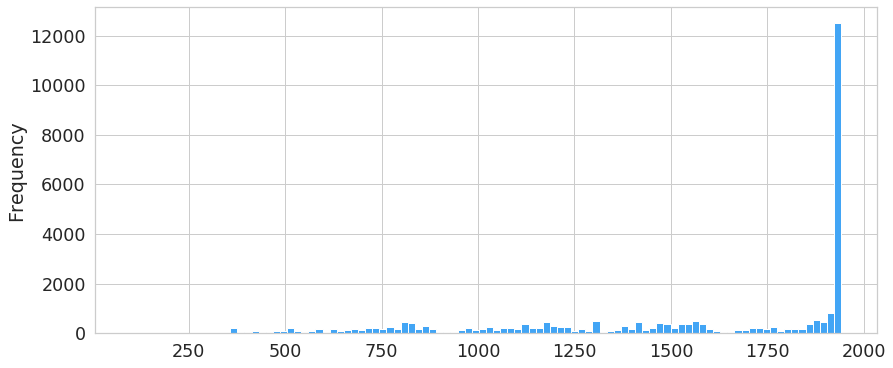

In [32]:
all_df.groupby("id").size().plot(kind="hist", bins=100)

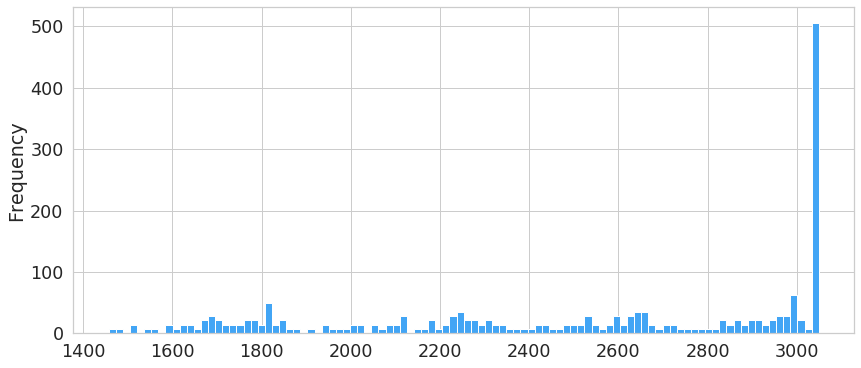

In [33]:
all_df.groupby("date")["item_id"].nunique().plot(kind="hist", bins=100)

# Objective

* Poisson regression

In [34]:
# /*!
# * \brief Objective function for Poisson regression
# */
# class RegressionPoissonLoss: public RegressionL2loss {
#  public:
#   explicit RegressionPoissonLoss(const Config& config): RegressionL2loss(config) {
#     max_delta_step_ = static_cast<double>(config.poisson_max_delta_step);
#     if (sqrt_) {
#       Log::Warning("Cannot use sqrt transform in %s Regression, will auto disable it", GetName());
#       sqrt_ = false;
#     }
#   }

#   explicit RegressionPoissonLoss(const std::vector<std::string>& strs): RegressionL2loss(strs) {
#   }

#   ~RegressionPoissonLoss() {}

#   void Init(const Metadata& metadata, data_size_t num_data) override {
#     if (sqrt_) {
#       Log::Warning("Cannot use sqrt transform in %s Regression, will auto disable it", GetName());
#       sqrt_ = false;
#     }
#     RegressionL2loss::Init(metadata, num_data);
#     // Safety check of labels
#     label_t miny;
#     double sumy;
#     Common::ObtainMinMaxSum(label_, num_data_, &miny, static_cast<label_t*>(nullptr), &sumy);
#     if (miny < 0.0f) {
#       Log::Fatal("[%s]: at least one target label is negative", GetName());
#     }
#     if (sumy == 0.0f) {
#       Log::Fatal("[%s]: sum of labels is zero", GetName());
#     }
#   }

#   /* Parametrize with unbounded internal score "f"; then
#    *  loss = exp(f) - label * f
#    *  grad = exp(f) - label
#    *  hess = exp(f)
#    *
#    * And the output is exp(f); so the associated metric get s=exp(f)
#    * so that its loss = s - label * log(s); a little awkward maybe.
#    *
#    */
#   void GetGradients(const double* score, score_t* gradients,
#                     score_t* hessians) const override {
#     if (weights_ == nullptr) {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>(std::exp(score[i]) - label_[i]);
#         hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_));
#       }
#     } else {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>((std::exp(score[i]) - label_[i]) * weights_[i]);
#         hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_) * weights_[i]);
#       }
#     }
#   }

* Tweedie regression

In [35]:
# /*!
# * \brief Objective function for Tweedie regression
# */
# class RegressionTweedieLoss: public RegressionPoissonLoss {
#  public:
#   explicit RegressionTweedieLoss(const Config& config) : RegressionPoissonLoss(config) {
#     rho_ = config.tweedie_variance_power;
#   }

#   explicit RegressionTweedieLoss(const std::vector<std::string>& strs) : RegressionPoissonLoss(strs) {
#   }

#   ~RegressionTweedieLoss() {}

#   void GetGradients(const double* score, score_t* gradients,
#                     score_t* hessians) const override {
#     if (weights_ == nullptr) {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>(-label_[i] * std::exp((1 - rho_) * score[i]) + std::exp((2 - rho_) * score[i]));
#         hessians[i] = static_cast<score_t>(-label_[i] * (1 - rho_) * std::exp((1 - rho_) * score[i]) +
#           (2 - rho_) * std::exp((2 - rho_) * score[i]));
#       }
#     } else {
#       #pragma omp parallel for schedule(static)
#       for (data_size_t i = 0; i < num_data_; ++i) {
#         gradients[i] = static_cast<score_t>((-label_[i] * std::exp((1 - rho_) * score[i]) + std::exp((2 - rho_) * score[i])) * weights_[i]);
#         hessians[i] = static_cast<score_t>((-label_[i] * (1 - rho_) * std::exp((1 - rho_) * score[i]) +
#           (2 - rho_) * std::exp((2 - rho_) * score[i])) * weights_[i]);
#       }
#     }
#   }

# Method templates

* Evaluation metric
* Adversarial Validation
* (`TODO`)Null Importance
* (`TODO`)Binary Model
* (`TODO`)Validation Strategies
* Models
    - LightGBM
    - XGBoost
    - CatBoost
    - NN

In [36]:
NUM_ITEMS = 30490 # 10(NUM_STORES) * 3049(NUM_ITEMS)
DAYS_PRED = 28

In [37]:
def weight_calc(data, product):
    
    # calculate the denominator of RMSSE, and calculate the weight base on sales amount
    # https://github.com/Mcompetitions/M5-methods/tree/master/validation
    sales_train_val = pd.read_csv(data_dir + "sales_train_validation.csv")
    d_name = ["d_" + str(i+1) for i in range(1913)]    
    display(pd.DataFrame(sales_train_val[d_name].values))
    
    # (42840, 30490) * (30490, 1913)の行列積
    # sales_train_valのshapeは(42840, 1913)になる
    # これで、各aggregation levelごとに売上数量（実績）を計算できる
    sales_train_val = weight_mat_csr * sales_train_val[d_name].values

    # calculate the start position(first non-zero demand observed date) for each item / 商品の最初の売上日
    # 売上数量が0より大きいところに、1~1913の番号をふった配列を作っている
    # shapeは(42840, 1913)
    df_tmp = ((sales_train_val>0) * np.tile(np.arange(1, 1914), (weight_mat_csr.shape[0], 1)))

    # df_tmpの最小値が売上数量が記録されたスタート地点であり、それを各行に対して求めている
    # 単純にやると売上が入っていない0が最小値になってしまうので、一旦9999にして行っている
    start_no = np.min(np.where(df_tmp==0, 9999, df_tmp), axis=1)-1

    # まず、start_noを0<x<1に正規化し、それを対角成分とした(42840, 42840)の行列を作る　対角成分以外は0
    # そして、1~1913の番号を順にふった(42840, 1913)行列と内積を計算し、1未満ならフラグを立てている　最終的に(42840, 1913)の2値行列となる
    # これによって、startno未満までの要素をTrue、以降をFalseとした(42840, 1913)の行列を作ることができ、
    # 売上数量が記録されていない部分を効率的にNaNと置き換えられる。
    # 例）startnoの最後は1130。(1/1131)*1=1/1131<1=True, (1/1131)*2=2/1131<1=True ... (1/1131)*1131=1<1=False ...
    flag = np.dot(np.diag(1/(start_no+1)), np.tile(np.arange(1, 1914), (weight_mat_csr.shape[0], 1))) < 1

    # フラグが立っていたらnan、そうでなければ売上数量を入れた行列に直す
    sales_train_val = np.where(flag, np.nan, sales_train_val)

    # denominator of RMSSE / RMSSEの分母
    # (Yt - Yt-1)の二乗和を計算し、売上数量が存在する部分のデータ数で割っている
    # np.diffではnanが絡む差はnanになり、nansumでnanを無視した総和を計算できる
    # これにより、売上数量が記録されていない部分を無視したスケール値(S)が算出できる
    # shapeは(42840,)
    weight1 = np.nansum(np.diff(sales_train_val, axis=1)**2, axis=1)/(1913-start_no)

    # calculate the sales amount for each item/level
    # ドキュメントに「各シリーズの重みは、データセットのトレーニングサンプルの最後の28の観測に基づいて計算される」
    # とあるので、その範囲のデータに絞っている。dataはsales_train_valをpd.meltで日にち単位にしたもの。
    df_tmp = data[(data["date"] > "2016-03-27") & (data["date"] <= "2016-04-24")]
    
    # ここからはドキュメントP8の数式を計算する
    # demandは目的変数（売上数量）で、sell_priceと掛け算すると売上金額になる
    # それを「HOBBIES_1_001_CA_1_validation」レベルのidをグループに、28日間の総和を計算する
    # shapeは(30490,)になる
    df_tmp["amount"] = df_tmp["sales"] * df_tmp["sell_price"]
    df_tmp = df_tmp.groupby(["id"])["amount"].apply(np.sum)
    
    # productのid順にソートするために必要
    df_tmp = df_tmp[product.id].values
    
    # 各aggregation levelごとに実績を取り出す
    # shapeは(42840,)
    weight2 = weight_mat_csr * df_tmp

    # weightを合計値で正規化する
    # これで、各aggregation lavelごとの重みが算出できる
    weight2 = weight2/np.sum(weight2)

    del sales_train_val
    gc.collect()
    
    return weight1, weight2

def wrmsse(y_pred, y_true):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values / 正解ラベル
    # このノートブックでは、学習データをシャッフルしていないのでアイテムの順序が一定
    y_true = y_true.get_label()

    # 30490*28で28日間のデータ数になり、この28日間だけを検証に使う
    y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
    y_pred = y_pred[-(NUM_ITEMS * DAYS_PRED):]
    # number of columns
    num_col = DAYS_PRED
    
    # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
    # shapeが(30490, 28)になり、重みの算出時と同じ状況になる
    reshaped_preds = y_pred.reshape(num_col, NUM_ITEMS).T
    reshaped_true = y_true.reshape(num_col, NUM_ITEMS).T
        
    # 基本的には重み算出時と同じ
    # np.c_で結合して、[:28]を予測、[28:]を実績としている点が異なる
    # trainのshapeは(42840, 56)になる
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    # WRMSSEの計算
    # train[:,:num_col]が予測、train[:,num_col:]が実績になる
    # 初めの:は全aggregation_levelについてという意味
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,num_col:] - train[:,:num_col])
                        ,axis=1) / weight1) * weight2)
    
    return "wrmsse", score, False

# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# ↑はactualとpredがドキュメントと逆なので注意
def wrmsse_loss(y_pred, y_true):
    
    # actual obserbed values / 正解ラベル
    # このノートブックでは、学習データをシャッフルしていないのでアイテムの順序が一定
    y_true = y_true.get_label()

    # gradients[i] = static_cast<score_t>(std::exp(score[i]) - label_[i]);
    # hessians[i] = static_cast<score_t>(std::exp(score[i] + max_delta_step_));
    gradients = np.exp(y_pred) - y_true
    hessian = np.exp(y_pred) + poisson_max_delta_step
    
    return gradients, hessian

In [38]:
# 行方向にダミー変数を結合し、最後に転置する
# shapeは(42840, 30490)になる
# 42840がaggregation lavelの表と一致する
weight_mat = np.c_[np.ones([NUM_ITEMS, 1]).astype(np.int8),  # level 1
                   pd.get_dummies(product.state_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str) + product.cat_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.store_id.astype(str) + product.dept_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.item_id.astype(str), drop_first=False).astype("int8").values, 
                   pd.get_dummies(product.state_id.astype(str) + product.item_id.astype(str), drop_first=False).astype("int8").values, 
                   np.identity(NUM_ITEMS).astype(np.int8) #item :level 12
                   ].T
display(pd.DataFrame(weight_mat))

# 疎行列の計算を効率的かつ高速に行うためのインスタンス
# https://www.atmarkit.co.jp/ait/articles/1706/21/news018_2.html
# https://note.nkmk.me/python-scipy-sparse-matrix-csr-csc-coo-lil/
weight_mat_csr = csr_matrix(weight_mat)
#del weight_mat
gc.collect()

0      1      2      3      4      5      6      7      8      9      \
0          1      1      1      1      1      1      1      1      1      1   
1          1      1      1      1      1      1      1      1      1      1   
2          0      0      0      0      0      0      0      0      0      0   
3          0      0      0      0      0      0      0      0      0      0   
4          1      1      1      1      1      1      1      1      1      1   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42835      0      0      0      0      0      0      0      0      0      0   
42836      0      0      0      0      0      0      0      0      0      0   
42837      0      0      0      0      0      0      0      0      0      0   
42838      0      0      0      0      0      0      0      0      0      0   
42839      0      0      0      0      0      0      0      0      0      0   

       ...  30480  30481  30482  30483  30484  30485  30486  30487  30488  \
0      ...      1      1      1      1      1      1      1      1      1   
1      ...      0      0      0      0      0      0      0      0      0   
2      ...      0      0      0      0      0      0      0      0      0   
3      ...      1      1      1      1      1      1      1      1      1   
4      ...      0      0      0      0      0      0      0      0      0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
42835  ...      0      0      0      0      0      1      0      0      0   
42836  ...      0      0      0      0      0      0      1      0      0   
42837  ...      0      0      0      0      0      0      0      1      0   
42838  ...      0      0      0      0      0      0      0      0      1   
42839  ...      0      0      0      0      0      0      0      0      0   

       30489  
0          1  
1          0  
2          0  
3          1  
4          0  
...      ...  
42835      0  
42836      0  
42837      0  
42838      0  
42839      1  

[42840 rows x 30490 columns]

12

In [39]:
weight1, weight2 = weight_calc(all_df, product)

0     1     2     3     4     5     6     7     8     9     ...  1903  \
0         0     0     0     0     0     0     0     0     0     0  ...     1   
1         0     0     0     0     0     0     0     0     0     0  ...     0   
2         0     0     0     0     0     0     0     0     0     0  ...     2   
3         0     0     0     0     0     0     0     0     0     0  ...     1   
4         0     0     0     0     0     0     0     0     0     0  ...     2   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
30485     0     0     2     2     0     3     1     4     1     0  ...     2   
30486     0     0     0     0     0     5     0     1     1     3  ...     0   
30487     0     6     0     2     2     4     1     8     5     2  ...     2   
30488     0     0     0     0     0     0     0     0     0     0  ...     0   
30489     0     0     0     0     0     0     0     0     0     0  ...     0   

       1904  1905  1906  1907  1908  1909  1910  1911  1912  
0         3     0     1     1     1     3     0     1     1  
1         0     0     0     0     1     0     0     0     0  
2         1     2     1     1     1     0     1     1     1  
3         0     5     4     1     0     1     3     7     2  
4         1     1     0     1     1     2     2     2     4  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
30485     0     0     0     0     0     1     0     0     1  
30486     0     0     0     0     0     0     0     1     0  
30487     1     0     2     0     1     0     0     1     0  
30488     0     1     0     0     1     0     3     1     3  
30489     0     0     0     0     0     0     0     0     0  

[30490 rows x 1913 columns]

In [40]:
const = weight2 / np.sqrt(weight1)
each_ids_weight = pd.DataFrame(weight_mat.T[:, :-30490]) * const[:-30490]
each_ids_weight = each_ids_weight.sum(axis=1) # level11までのerror_weight合計を計算しておく
each_ids_weight += const[-30490:] # level12のerror_weight足し込む　二度手間なのはDataFrameのサイズを小さくするため
each_ids_weight = (each_ids_weight - each_ids_weight.min()) / (each_ids_weight.max() - each_ids_weight.min()) # 0~1
each_ids_weight.index = product.id
each_ids_weight
# #display(const, const.shape)

id
HOBBIES_1_001_CA_1_validation    0.267795
HOBBIES_1_002_CA_1_validation    0.195972
HOBBIES_1_003_CA_1_validation    0.206387
HOBBIES_1_004_CA_1_validation    0.229723
HOBBIES_1_005_CA_1_validation    0.214104
                                   ...   
FOODS_3_823_WI_3_validation      0.022458
FOODS_3_824_WI_3_validation      0.026490
FOODS_3_825_WI_3_validation      0.065298
FOODS_3_826_WI_3_validation      0.024401
FOODS_3_827_WI_3_validation      0.021782
Length: 30490, dtype: float64

In [41]:
each_ids_weight[each_ids_weight.index.str.contains("HOBBIES")].mean(), each_ids_weight[each_ids_weight.index.str.contains("FOODS")].mean(), each_ids_weight[each_ids_weight.index.str.contains("HOUSEHOLD")].mean()

(0.1848529984305104, 0.09386942206166442, 0.23732513846787423)

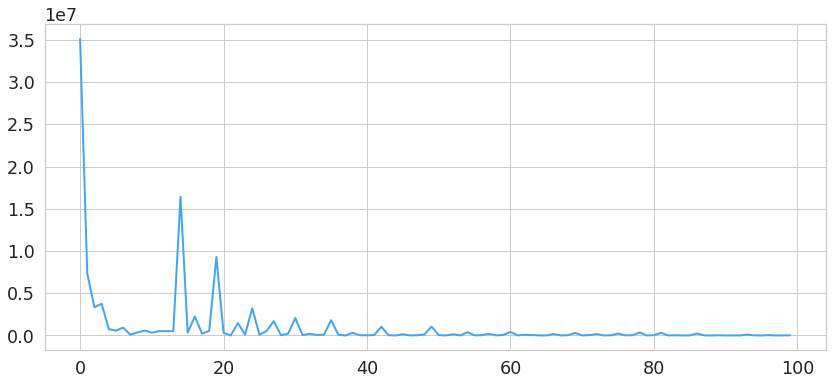

In [42]:
pd.Series(weight1)[:100].plot()

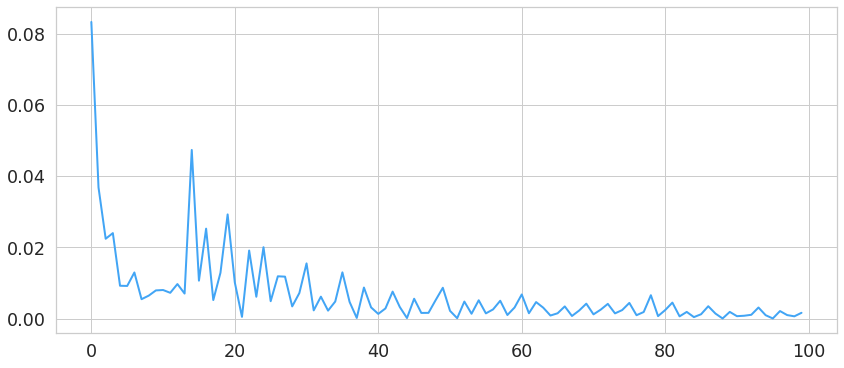

In [43]:
pd.Series(weight2)[:100].plot()

In [44]:
# going to evaluate with the last 28 days
x_train = all_df[all_df["date"] <= "2016-03-27"]
y_train = x_train["sales"]
x_val = all_df[(all_df["date"] > "2016-03-27") & (all_df["date"] <= "2016-04-24")]
y_val = x_val["sales"]
test = all_df[(all_df["date"] > "2016-04-24")]

del all_df
gc.collect()

20

In [45]:
x_train.index = x_train["id"]
x_val.index = x_val["id"]
x_train["weight"] = each_ids_weight
x_val["weight"] = each_ids_weight
x_train

id  item_id  \
id                                                                      
HOBBIES_1_001_CA_1_validation  HOBBIES_1_001_CA_1_validation     1437   
HOBBIES_1_001_CA_1_validation  HOBBIES_1_001_CA_1_validation     1437   
HOBBIES_1_001_CA_1_validation  HOBBIES_1_001_CA_1_validation     1437   
HOBBIES_1_001_CA_1_validation  HOBBIES_1_001_CA_1_validation     1437   
HOBBIES_1_001_CA_1_validation  HOBBIES_1_001_CA_1_validation     1437   
...                                                      ...      ...   
FOODS_3_827_WI_3_validation      FOODS_3_827_WI_3_validation     1436   
FOODS_3_827_WI_3_validation      FOODS_3_827_WI_3_validation     1436   
FOODS_3_827_WI_3_validation      FOODS_3_827_WI_3_validation     1436   
FOODS_3_827_WI_3_validation      FOODS_3_827_WI_3_validation     1436   
FOODS_3_827_WI_3_validation      FOODS_3_827_WI_3_validation     1436   

                               dept_id  store_id  cat_id  state_id       d  \
id                                                                           
HOBBIES_1_001_CA_1_validation        3         0       1         0   d_897   
HOBBIES_1_001_CA_1_validation        3         0       1         0   d_898   
HOBBIES_1_001_CA_1_validation        3         0       1         0   d_899   
HOBBIES_1_001_CA_1_validation        3         0       1         0   d_900   
HOBBIES_1_001_CA_1_validation        3         0       1         0   d_901   
...                                ...       ...     ...       ...     ...   
FOODS_3_827_WI_3_validation          2         9       0         2  d_1881   
FOODS_3_827_WI_3_validation          2         9       0         2  d_1882   
FOODS_3_827_WI_3_validation          2         9       0         2  d_1883   
FOODS_3_827_WI_3_validation          2         9       0         2  d_1884   
FOODS_3_827_WI_3_validation          2         9       0         2  d_1885   

                               sales        date  wm_yr_wk  ...  year  \
id                                                          ...         
HOBBIES_1_001_CA_1_validation    0.0  2013-07-13     11325  ...  2013   
HOBBIES_1_001_CA_1_validation    0.0  2013-07-14     11325  ...  2013   
HOBBIES_1_001_CA_1_validation    0.0  2013-07-15     11325  ...  2013   
HOBBIES_1_001_CA_1_validation    0.0  2013-07-16     11325  ...  2013   
HOBBIES_1_001_CA_1_validation    0.0  2013-07-17     11325  ...  2013   
...                              ...         ...       ...  ...   ...   
FOODS_3_827_WI_3_validation      5.0  2016-03-23     11608  ...  2016   
FOODS_3_827_WI_3_validation      3.0  2016-03-24     11608  ...  2016   
FOODS_3_827_WI_3_validation      2.0  2016-03-25     11608  ...  2016   
FOODS_3_827_WI_3_validation      0.0  2016-03-26     11609  ...  2016   
FOODS_3_827_WI_3_validation      5.0  2016-03-27     11609  ...  2016   

                               event_name_1  event_type_1  event_name_2  \
id                                                                        
HOBBIES_1_001_CA_1_validation             0             0             0   
HOBBIES_1_001_CA_1_validation             0             0             0   
HOBBIES_1_001_CA_1_validation             0             0             0   
HOBBIES_1_001_CA_1_validation             0             0             0   
HOBBIES_1_001_CA_1_validation             0             0             0   
...                                     ...           ...           ...   
FOODS_3_827_WI_3_validation               0             0             0   
FOODS_3_827_WI_3_validation              24             3             0   
FOODS_3_827_WI_3_validation               0             0             0   
FOODS_3_827_WI_3_validation               0             0             0   
FOODS_3_827_WI_3_validation               5             1             0   

                               event_type_2  snap_CA  snap_TX  snap_WI  \
id                                                                       
HOBBIES_1_001_CA_1_

In [46]:
# define random hyperparammeters for LGBM
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    # "snap_CA",
    # "snap_TX",
    # "snap_WI",
    # "sell_price",
    # time features.
    # "year",
    # "month",
    # "wday",
]
categoricals = features.copy()

train_set = lgb.Dataset(x_train[features], y_train, weight=x_train["weight"], categorical_feature=categoricals, free_raw_data=False)
val_set = lgb.Dataset(x_val[features], y_val, weight=x_val["weight"], categorical_feature=categoricals, free_raw_data=False)
#x_train_id = x_train[["id", "date"]]

In [48]:
# params = {
#     "boosting_type": "gbdt",
#     "metric": "custom",
#     "objective": "custom",
#     "n_jobs": -1,
#     "seed": 236,
#     "learning_rate": 0.01,
#     "bagging_fraction": 0.75,
#     "bagging_freq": 10, 
#     "colsample_bytree": 0.75
# }

params = {
    "boosting_type": "gbdt",
    "metric": "custom",
    "objective": "poisson",
    "force_row_wise" : True,
    "learning_rate" : 0.075,
    # "sub_feature" : 0.8,
    "sub_row" : 0.75,
    "bagging_freq" : 1,
    "lambda_l2" : 0.1,
    # "nthread" : 4
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}
poisson_max_delta_step = 0.7

# model estimation
model = lgb.train(params, train_set, num_boost_round = 100, early_stopping_rounds = 50, 
                  valid_sets=[train_set, val_set], verbose_eval=100, feval=wrmsse)
val_pred = model.predict(x_val[features])
#val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
#print(f"Our val wrmsse score is {val_score}")
y_pred = model.predict(test[features])
test["sales"] = y_pred

Training until validation scores don't improve for 50 rounds
[100]	training's wrmsse: 3.65297	valid_1's wrmsse: 1.2759
[200]	training's wrmsse: 3.35267	valid_1's wrmsse: 1.24988
[300]	training's wrmsse: 3.24806	valid_1's wrmsse: 1.23547
[400]	training's wrmsse: 3.17987	valid_1's wrmsse: 1.22342
[500]	training's wrmsse: 3.11397	valid_1's wrmsse: 1.21864
[600]	training's wrmsse: 3.07229	valid_1's wrmsse: 1.21513
[700]	training's wrmsse: 3.04081	valid_1's wrmsse: 1.21237
[800]	training's wrmsse: 3.00006	valid_1's wrmsse: 1.21003
[900]	training's wrmsse: 2.96318	valid_1's wrmsse: 1.20862
[1000]	training's wrmsse: 2.94014	valid_1's wrmsse: 1.20774
[1100]	training's wrmsse: 2.92302	valid_1's wrmsse: 1.20655
[1200]	training's wrmsse: 2.91046	valid_1's wrmsse: 1.20608
Did not meet early stopping. Best iteration is:
[1194]	training's wrmsse: 2.91045	valid_1's wrmsse: 1.20617


In [49]:
predictions = test[["id", "date", "sales"]]
predictions = pd.pivot(predictions, index = "id", columns = "date", values = "sales").reset_index()
predictions.columns = ["id"] + ["F" + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission["id"] if "evaluation" in row] 
evaluation = submission[submission["id"].isin(evaluation_rows)]

validation = submission[["id"]].merge(predictions, on = "id")
final = pd.concat([validation, evaluation])
final.to_csv("case03_poissonweighted_submission.csv", index = False)

In [50]:
final

id        F1        F2        F3        F4  \
0      HOBBIES_1_001_CA_1_validation  0.593001  0.593001  0.593001  0.593001   
1      HOBBIES_1_002_CA_1_validation  0.290771  0.290771  0.290771  0.290771   
2      HOBBIES_1_003_CA_1_validation  0.328015  0.328015  0.328015  0.328015   
3      HOBBIES_1_004_CA_1_validation  1.872478  1.872478  1.872478  1.872478   
4      HOBBIES_1_005_CA_1_validation  1.055433  1.055433  1.055433  1.055433   
...                              ...       ...       ...       ...       ...   
60975    FOODS_3_823_WI_3_evaluation  0.000000  0.000000  0.000000  0.000000   
60976    FOODS_3_824_WI_3_evaluation  0.000000  0.000000  0.000000  0.000000   
60977    FOODS_3_825_WI_3_evaluation  0.000000  0.000000  0.000000  0.000000   
60978    FOODS_3_826_WI_3_evaluation  0.000000  0.000000  0.000000  0.000000   
60979    FOODS_3_827_WI_3_evaluation  0.000000  0.000000  0.000000  0.000000   

             F5        F6        F7        F8        F9  ...       F19  \
0      0.593001  0.574672  0.578397  0.593001  0.593001  ...  0.593001   
1      0.290771  0.245666  0.292812  0.290771  0.290771  ...  0.290771   
2      0.328015  0.353308  0.362742  0.328015  0.328015  ...  0.328015   
3      1.872478  1.956191  2.257900  1.872478  1.872478  ...  1.872478   
4      1.055433  0.759505  0.797561  1.055433  1.055433  ...  1.055433   
...         ...       ...       ...       ...       ...  ...       ...   
60975  0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
60976  0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
60977  0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
60978  0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
60979  0.000000  0.000000  0.000000  0.000000  0.000000  ...  0.000000   

            F20       F21       F22       F23       F24       F25       F26  \
0      0.593001  0.593001  0.593001  0.593001  0.593001  0.593001  0.593001   
1      0.290771  0.290771  0.290771  0.290771  0.290771  0.290771  0.290771   
2      0.328015  0.328015  0.328015  0.328015  0.328015  0.328015  0.328015   
3      1.872478  1.872478  1.872478  1.872478  1.872478  1.872478  1.872478   
4      1.055433  1.055433  1.055433  1.055433  1.055433  1.055433  1.055433   
...         ...       ...       ...       ...       ...       ...       ...   
60975  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
60976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
60977  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
60978  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
60979  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            F27       F28  
0      0.593001  0.593001  
1      0.290771  0.290771  
2      0.328015  0.328015  
3      1.872478  1.872478  
4      1.055433  1.055433  
...         ...       ...  
60975  0.000000  0.000000  
60976  0.000000  0.000000  
60977  0.000000  0.000000  
60978  0.000000  0.000000  
60979  0.000000  0.000000  

[60980 rows x 29 columns]

In [33]:
class AdversarialValidation():
    
    def __init__(self, train, test, features, categoricals, n_splits=5, seed=0):
        self.train = train.copy()
        self.test = test.copy()
        self.features = features
        self.categoricals = categoricals
        self.n_splits = n_splits
        self.seed = seed
        
        self.train["target"] = 0
        self.test["target"] = 1
        self.train_test = pd.concat([self.train, self.test], axis=0).reset_index(drop=True)
        # self.train_test["target"] = [1 if np.isnan(x) else 0 for x in self.train_test["y"]]
        
        # display(self.train_test)
        self.params = self.get_params(self.train_test[self.features], self.train_test["target"])
        self.oof_pred, self.score, self.model, self.importance = self.fit()
    
    def train_model(self, train_set, val_set):
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], num_boost_round=100, early_stopping_rounds=100, verbose_eval=0)

    def get_params(self, X, y):
        def hyperopt_lightgbm(X: pd.DataFrame, y: pd.Series):
            # Stratified 5-fold
            tra_index, val_index = StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(X, y)
            X_tra, y_tra = X.loc[tra_index[0], :], y[tra_index[0]]
            X_val, y_val = X.loc[val_index[0], :], y[val_index[0]]

            train_data = lgb.Dataset(X_tra, label=y_tra, categorical_feature=self.categoricals, free_raw_data=False)
            valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=self.categoricals, free_raw_data=False)

            params = {
                "objective": "binary",
                "boosting_type": "gbdt",
                "metric": "auc",
                "num_threads": 4,
            }

            space = {
                #"boosting_type": hp.choice("boosting_type", ["gbdt", "dart"]),
                "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.1)),
                "max_depth": hp.choice("max_depth", np.arange(3, 10, dtype=int)),
                "num_leaves": hp.choice("num_leaves", np.linspace(2, 128, 64, dtype=int)),
                "feature_fraction": hp.quniform("feature_fraction", 0.5, 1.0, 0.1),
                "bagging_fraction": hp.quniform("bagging_fraction", 0.5, 1.0, 0.1),
                "bagging_freq": hp.choice("bagging_freq", np.linspace(0, 50, 10, dtype=int)),
                "reg_alpha": hp.quniform("reg_alpha", 1, 2, 0.1),
                "reg_lambda": hp.quniform("reg_lambda", 1, 2, 0.1),
                "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
                #"min_data_in_leaf": hp.choice("min_data_in_leaf", np.linspace(0, 20, 10, dtype=int)),
            }

            def objective(hyperparams):
                model = lgb.train(params={**params},
                                  train_set=train_data,
                                  num_boost_round=300,
                                  valid_sets=valid_data,
                                  early_stopping_rounds=30,
                                  verbose_eval=0)

                score = model.best_score["valid_0"][params["metric"]]
                return {"loss": 1 - score, "status": STATUS_OK}

            trials = Trials()
            best = hyperopt.fmin(fn=objective, space=space, trials=trials,
                                 algo=tpe.suggest, max_evals=1, verbose=1,
                                 rstate=np.random.RandomState(1))

            lgb_params = space_eval(space, best) 

            print("lgb_params = {0}".format({**params, **lgb_params}))

            return {**params, **lgb_params}
        params = hyperopt_lightgbm(X, y)
        return params
    
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)
        return cv.split(self.train_test, self.train_test["target"])        
        
    def get_feature_importance(self, model, importance_type="split"):
        return model.feature_importance(importance_type=importance_type)
    
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set

    def display_feature_importance(self, feature_importance_df):
        feature_importance_df["importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)
        cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:5].index
        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
        plt.figure(figsize=(10, 4))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title("feature importance")
        plt.tight_layout()
        plt.show()
    
    def fit(self):
        oof_score_mean = 0
        oof_pred = np.zeros((len(self.train_test), ))
        feature_importance_all = pd.DataFrame(self.features, columns=["feature"])
        for fold, (train_idx, val_idx) in enumerate(self.get_cv()):
            x_train, x_val = self.train_test[self.features].iloc[train_idx], self.train_test[self.features].iloc[val_idx]
            y_train, y_val = self.train_test["target"][train_idx], self.train_test["target"][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            oof_pred[val_idx] = model.predict(x_val).reshape(oof_pred[val_idx].shape)
            feature_importance = pd.DataFrame(self.get_feature_importance(model), columns=["Fold " + str(fold)])
            feature_importance["feature"] = x_train.columns
            feature_importance_all = pd.merge(feature_importance_all, feature_importance, on="feature")
            auc = roc_auc_score(y_val, oof_pred[val_idx])
            oof_score_mean += auc / self.n_splits
            print("Partial score of fold {} is: {}".format(fold, auc))

        print("OOF score of seed {} is: {}".format(self.seed, oof_score_mean))
        self.display_feature_importance(feature_importance_all)
        
        return oof_pred, oof_score_mean, model, feature_importance_all

In [49]:
def StratifiedGroupKFold(X, y, groups, k, random_state=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(random_state).shuffle(groups_and_y_counts)
    
    for g, y_counts in groups_and_y_counts:
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [56]:
class Base_Model(object):
    
    def __init__(self, train, test, features, categoricals=[], n_splits=5, n_seeds=3, seeds=np.arange(0, 3, 1), verbose=True):
        self.train = train
        self.test = test
        self.features = features
        self.n_seeds = n_seeds
        self.seeds = seeds
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = "y"
        self.cv_method = "sgkf"
        self.skf_group = "Municipality"
        self.gkf_group = "Period"
        self.do_target_encoding = True
        self.te_included = ["DistrictName", "NearestStation", "NearestStation_DistrictName"]#, "Type_DistrictName", "Type_NearestStation", \
                            #"FloorPlan_DistrictName", "FloorPlan_NearestStation", "LandShape_DistrictName", "LandShape_NearestStation", \
                            #"Type_NearestStation_DistrictName"]
        self.features_te = [c + "_te_area" for c in self.te_included] # + [c + "_te" for c in self.te_included]
        self.verbose = verbose
        self.y_pred, self.oof_pred, self.score, self.model, self.importance = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError  
    
    def get_cv(self, seed):
        if self.cv_method == "kf":
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=seed)
            return cv.split(self.train)
        
        elif self.cv_method == "skf":
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=seed)
            return cv.split(self.train, self.train[self.skf_group])
        
        elif self.cv_method == "gkf":
            group = self.train[self.gkf_group].unique()
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=seed)
            return cv.split(group)
        
        elif self.cv_method == "sgkf":
            cv = StratifiedGroupKFold(X=self.train, y=self.train[self.skf_group], groups=self.train[self.gkf_group], k=self.n_splits, random_state=seed)
            return cv
            
    def get_params(self, X, y):
        raise NotImplementedError
        
    def get_feature_importance(self, model):
        raise NotImplementedError
        
    def target_encoding(self, x_train, x_val, y_train, y_val):
        for c in self.te_included:
            train_ct = pd.DataFrame({c: x_train[c], "target": y_train})
            target_means_all = train_ct.groupby(c)["target"].mean()
            
            # validation is replaced by the target mean of entire train
            x_val[c + "_te"] = x_val[c].map(target_means_all)
            oof_encoded = np.repeat(np.nan, x_train.shape[0])
            kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=72)
            for idx_1, idx_2 in kf.split(x_train, x_train["Municipality"]):
                target_means = train_ct.iloc[idx_1].groupby(c)["target"].agg(["mean", "count"])
                smoothing = 1 / (1 + np.exp(-target_means["count"] / 1))
                target_mean_smoothed = (train_ct["target"].mean() * (1 - smoothing)) + (target_means["mean"] * smoothing)
                oof_encoded[idx_2] = x_train[c].iloc[idx_2].map(target_mean_smoothed)
                # oof_encoded[idx_2] = x_train[c].iloc[idx_2].map(target_means["mean"])
            x_train[c + "_te"] = oof_encoded
        
        return x_train, x_val, y_train, y_val
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError

    def reconvert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def fit(self):
        oof_score_seed_mean = 0
        oof_pred_seed = np.zeros((len(self.train), ))
        y_pred_seed = np.zeros((len(self.test), ))
        feature_importance_all = pd.DataFrame(self.features + self.features_te if self.do_target_encoding else self.features, columns=["feature"])
        # feature_importance_all = pd.DataFrame(self.features, columns=["feature"])
        if self.do_target_encoding:
            for c in self.te_included:
                target_mean = pd.DataFrame({c: self.train[c], "target": self.train[self.target]}).groupby(c)["target"].mean()
                target_mean_area = pd.DataFrame({c: self.train[c], "target": self.train[self.target]/self.train["Area"]}).groupby(c)["target"].mean()
                # self.test[c + "_te"] = self.test[c].map(target_mean)
                self.test[c + "_te_area"] = self.test[c].map(target_mean_area)
        for seed in self.seeds:
            oof_score_fold_mean = 0
            oof_pred = np.zeros((len(self.train), ))
            y_pred = np.zeros((len(self.test), ))
            for fold, (train_idx, val_idx) in enumerate(self.get_cv(seed)):
                if self.cv_method == "gkf":
                    group = self.train[self.gkf_group].unique()
                    train_groups, val_groups = group[train_idx], group[val_idx]
                    train_idx = self.train[self.gkf_group].isin(train_groups)
                    train_idx = train_idx[train_idx == True].index
                    val_idx = self.train[self.gkf_group].isin(val_groups)
                    val_idx = val_idx[val_idx == True].index

                x_train, x_val = self.train[self.features].iloc[train_idx], self.train[self.features].iloc[val_idx]
                y_train, y_val = self.train[self.target][train_idx], self.train[self.target][val_idx]
                # y_train, y_val = np.log(y_train), np.log(y_val)
                if self.do_target_encoding:
                    x_train, x_val, y_train, y_val = self.target_encoding(x_train, x_val, y_train, y_val)
                #AdversarialValidation(pd.concat([x_train, y_train], axis=1), pd.concat([x_val, y_val], axis=1), self.features + self.features_te if self.do_target_encoding else self.features, self.categoricals, 5, 22)
                #AdversarialValidation(pd.concat([x_train, y_train], axis=1), self.test[self.features + self.features_te if self.do_target_encoding else self.features], self.features + self.features_te if self.do_target_encoding else self.features, self.categoricals, 5, 22)
                self.params = self.get_params(x_train, y_train)
                train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
                model = self.train_model(train_set, val_set)
                oof_pred[val_idx] = model.predict(x_val).reshape(oof_pred[val_idx].shape)
                # oof_pred[val_idx] = np.exp(model.predict(x_val)).reshape(oof_pred[val_idx].shape)
                x_test = self.test[self.features + self.features_te if self.do_target_encoding else self.features]
                # x_test = self.test[self.features]
                # y_pred += np.exp(model.predict(x_test)).reshape(y_pred.shape) / self.n_splits
                y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
                feature_importance = pd.DataFrame(self.get_feature_importance(model), columns=["Seed " + str(seed) + ", Fold " + str(fold)])
                feature_importance["feature"] = x_train.columns
                feature_importance_all = pd.merge(feature_importance_all, feature_importance, on="feature")
                # evaluation = evaluate(np.exp(y_val), oof_pred[val_idx], method="rmse")
                evaluation = evaluate(y_val, oof_pred[val_idx], method="rmse")
                oof_score_fold_mean += evaluation / self.n_splits
                print("Partial score of seed {} fold {} is: {}".format(seed, fold, evaluation))

            if self.verbose:
                print("OOF score of seed {} is: {}".format(seed, oof_score_fold_mean))
            oof_score_seed_mean += oof_score_fold_mean / self.n_seeds
            oof_pred_seed += oof_pred / self.n_seeds
            y_pred_seed += y_pred / self.n_seeds

        if self.verbose:
            print("Seed averaging score is: {}".format(oof_score_seed_mean))
        self.display_feature_importance(feature_importance_all)
        
        return y_pred_seed, oof_pred_seed, oof_score_seed_mean, model, feature_importance_all

In [57]:
def hyperopt_lightgbm(X: pd.DataFrame, y: pd.Series):
    # Stratified 5-fold
    tra_index, val_index = StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(X, X["Municipality"])
    X_tra, y_tra = X.loc[tra_index[0], :], y[tra_index[0]]#.apply(np.log)
    X_val, y_val = X.loc[val_index[0], :], y[val_index[0]]#.apply(np.log)
    
    train_data = lgb.Dataset(X_tra, label=y_tra, categorical_feature=categoricals, free_raw_data=False)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categoricals, free_raw_data=False)

    params = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        "num_threads": 4,
    }
    
    space = {
        #"boosting_type": hp.choice("boosting_type", ["gbdt", "dart"]),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.1)),
        "max_depth": hp.choice("max_depth", np.arange(3, 10, dtype=int)),
        "num_leaves": hp.choice("num_leaves", np.linspace(2, 128, 64, dtype=int)),
        "feature_fraction": hp.quniform("feature_fraction", 0.7, 1.0, 0.1),
        "bagging_fraction": hp.quniform("bagging_fraction", 0.7, 1.0, 0.1),
        "bagging_freq": hp.choice("bagging_freq", np.linspace(0, 50, 10, dtype=int)),
        "reg_alpha": hp.quniform("reg_alpha", 1, 2, 0.1),
        "reg_lambda": hp.quniform("reg_lambda", 1, 2, 0.1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        #"min_data_in_leaf": hp.choice("min_data_in_leaf", np.linspace(0, 20, 10, dtype=int)),
    }

    def objective(hyperparams):
        model = lgb.train(params={**params, **hyperparams},
                          train_set=train_data,
                          num_boost_round=300,
                          valid_sets=valid_data,
                          early_stopping_rounds=30,
                          verbose_eval=0)
        
        score = model.best_score["valid_0"][params["metric"]]
        return {"loss": score, "status": STATUS_OK}

    trials = Trials()
    best = hyperopt.fmin(fn=objective, space=space, trials=trials,
                         algo=tpe.suggest, max_evals=10, verbose=1,
                         rstate=np.random.RandomState(1))

    lgb_params = space_eval(space, best) 
        
    print("lgb_params = {0}".format({**params, **lgb_params}))
    
    return {**params, **lgb_params}

In [58]:
class LGB_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 500 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], num_boost_round=10000, early_stopping_rounds=500, verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
    
    def reconvert_dataset(self, x_train, y_train, x_val, y_val):
        return x_train, y_train, x_val, y_val
        
    def get_params(self, X, y):
        params = hyperopt_lightgbm(X, y)
        return params
    
    def get_feature_importance(self, model, importance_type="split"):
        return model.feature_importance(importance_type=importance_type)
        
    def display_feature_importance(self, feature_importance_df):
        feature_importance_df["importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)
        cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
        plt.figure(figsize=(10, 15))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title("feature importance")
        plt.tight_layout()
        plt.show()

# Modeling

In [ ]:
weight1, weight2 = weight_calc(data,product)

In [44]:
train_df.shape, test_df.shape

((319021, 35), (34844, 34))

In [46]:
row_id = test_df["id"]
features = train_df.drop(["id", "y", "Period"], axis=1).columns.tolist()
# features = train_df.drop(["id", "y", "y_binary", "Period"], axis=1).columns.tolist()
categoricals = sorted(list(set(categoricals) & set(features)))
categoricals

['AreaRank',
 'BuildingYear',
 'CityPlanning',
 'Classification',
 'Direction',
 'DistrictName',
 'FloorPlan',
 'FrontageBins',
 'LandShape',
 'Municipality',
 'MunicipalityType',
 'NameOfEra',
 'NearestStation',
 'NearestStation_DistrictName',
 'Region',
 'RegionSimplified',
 'Remarks',
 'Renovation',
 'Structure',
 'Type',
 'Type_DistrictName',
 'Type_NearestStation']

## LightGBM

100%|███████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it, best loss: 206.83168561732714]
lgb_params = {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'num_threads': 4, 'bagging_fraction': 0.9, 'bagging_freq': 22, 'feature_fraction': 0.7000000000000001, 'learning_rate': 0.04241120707058522, 'max_depth': 8, 'min_child_weight': 9.0, 'num_leaves': 72, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 2.0}
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 74.0046	valid_1's rmse: 271.782
Early stopping, best iteration is:
[43]	training's rmse: 200.316	valid_1's rmse: 228.209
Partial score of seed 0 fold 0 is: 228.20869586659484
100%|███████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it, best loss: 193.25355468263345]
lgb_params = {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'num_threads': 4, 'bagging_fraction': 0.9, 'bagging_freq': 22, 'feature_fraction

lgb_params = {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'num_threads': 4, 'bagging_fraction': 0.9, 'bagging_freq': 22, 'feature_fraction': 0.7000000000000001, 'learning_rate': 0.04241120707058522, 'max_depth': 8, 'min_child_weight': 9.0, 'num_leaves': 72, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 2.0}
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 73.0805	valid_1's rmse: 232.641
Early stopping, best iteration is:
[50]	training's rmse: 193.527	valid_1's rmse: 216.77
Partial score of seed 2 fold 2 is: 216.76950143860515
100%|███████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it, best loss: 179.71884911936775]
lgb_params = {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'num_threads': 4, 'bagging_fraction': 0.9, 'bagging_freq': 22, 'feature_fraction': 0.7000000000000001, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'r

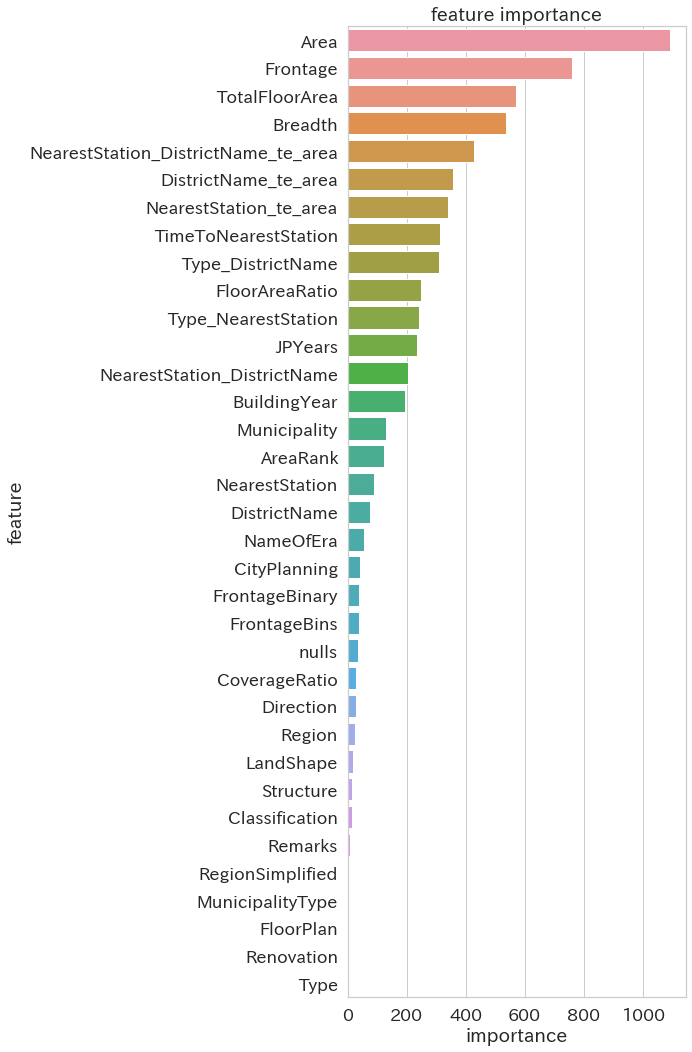

In [59]:
lgb_model = LGB_Model(train=train_df,
                      test=test_df,
                      features=features,
                      categoricals=categoricals,
                      n_splits=10,
                      n_seeds=3,
                      seeds=np.arange(0, 3, 1))

218.63365692362535


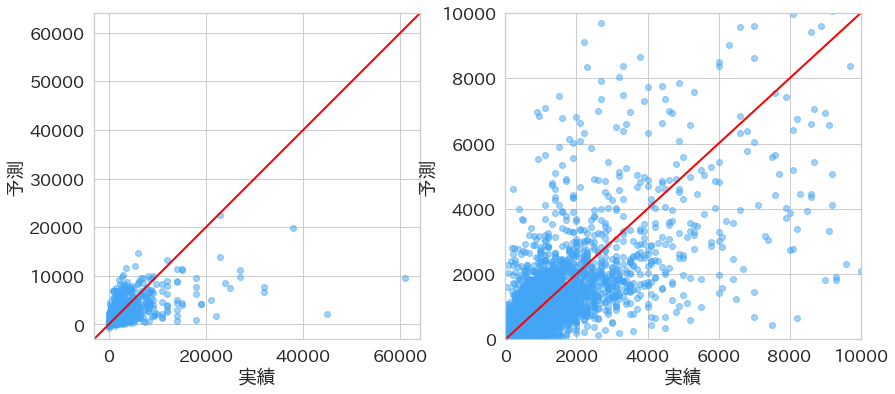

In [60]:
train_df["lgb_pred"] = lgb_model.oof_pred
test_df["lgb_pred"] = lgb_model.y_pred

print(evaluate(train_df["y"], train_df["lgb_pred"], method="rmse"))
plt.subplot(1, 2, 1)
plt.scatter(train_df["y"], lgb_model.oof_pred, alpha=0.5, linewidths=1)
axes = plt.gca()
xmin, xmax = axes.get_xlim()
plt.plot((xmin, xmax), (xmin, xmax), color="red")
plt.xlabel("実績")
plt.ylabel("予測")
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
axes.set_aspect("equal")

plt.subplot(1, 2, 2)
plt.scatter(train_df["y"], lgb_model.oof_pred, alpha=0.5, linewidths=1)
xmin, xmax = 0, 10000
plt.plot((xmin, xmax), (xmin, xmax), color="red")
plt.xlabel("実績")
plt.ylabel("予測")
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
axes.set_aspect("equal")
plt.show()

In [61]:
submission = pd.DataFrame()
submission["id"] = row_id
submission["y"] = np.clip(test_df["lgb_pred"], 0.001, a_max=None)
submission

id           y
0          1   24.180597
1          2   21.078022
2          3  139.043061
3          4   21.955217
4          5   53.746747
...      ...         ...
34839  34840   46.514514
34840  34841   33.682312
34841  34842   38.409010
34842  34843   41.385157
34843  34844   38.293139

[34844 rows x 2 columns]

In [62]:
submission.to_csv("case45_sgkf_AV_FE_TE-All-Area_lgb_208.58.csv", index=False)

## Catboost

In [67]:
class CB_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 500 if self.verbose else 0
        clf = cb.CatBoostRegressor(**self.params, verbose=verbosity)
        return clf.fit(train_set, eval_set=[val_set])
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = cb.Pool(x_train, y_train, cat_features=self.categoricals)
        val_set = cb.Pool(x_val, y_val, cat_features=self.categoricals)
        return train_set, val_set
    
    def reconvert_dataset(self, x_train, y_train, x_val, y_val):
        return x_train, y_train, x_val, y_val        
    
    def get_params(self, X, y):
        params = {"num_boost_round": 1000,
                  "eval_metric": "RMSE", 
                  "early_stopping_rounds": 100,
                  "cat_features": self.categoricals}
        return params
    
    def get_feature_importance(self, model, importance_type="split"):
        return model.get_feature_importance()
        
    def display_feature_importance(self, feature_importance_df):
        feature_importance_df["importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)
        cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
        plt.figure(figsize=(10, 15))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title("feature importance")
        plt.tight_layout()
        plt.show()

100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.23s/it, best loss: 0.0028432727494869248]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9056302856303791
Partial score of fold 1 is: 0.9079579769353675
Partial score of fold 2 is: 0.9118266487415863
Partial score of fold 3 is: 0.9044346549549798
Partial score of fold 4 is: 0.9021369227415506
OOF score of seed 22 is: 0.9063972978007727


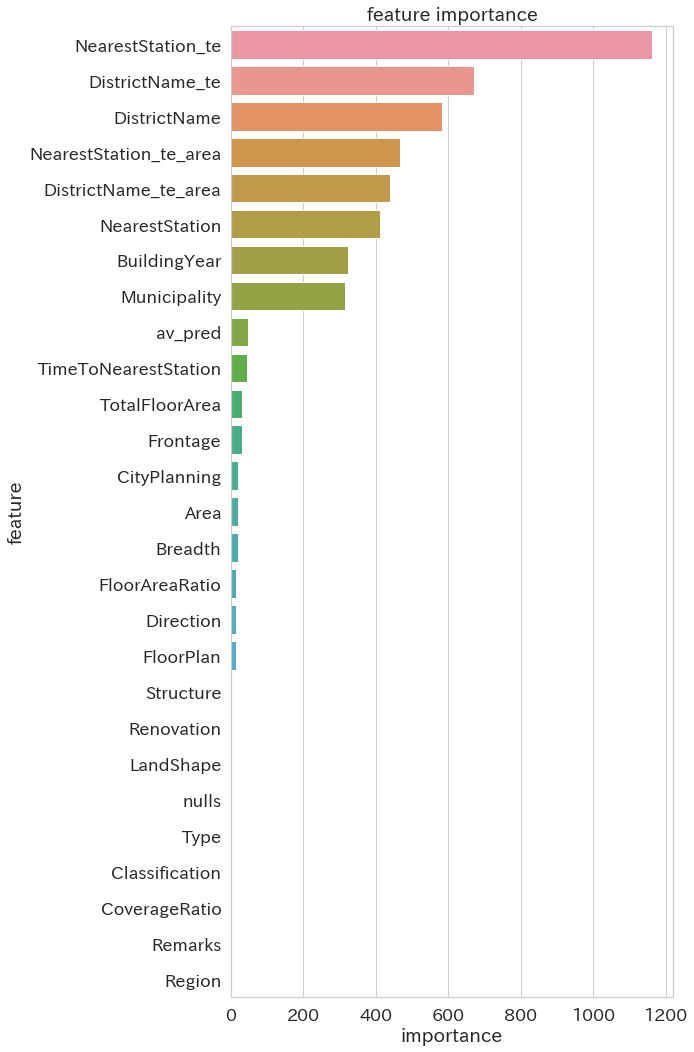

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 267.4206520	best: 267.4206520 (0)	total: 374ms	remaining: 6m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 170.4942605
bestIteration = 152

Shrink model to first 153 iterations.
Partial score of seed 10 fold 0 is: 170.49426049778077
100%|████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.23s/it, best loss: 0.00261785391426661]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8915951741109809
Partial score of fold 1 is: 0.8865129128679505
Partial score of fold 2 is: 0.8752999632375531
Partial score of fold 3 is: 0.8827620975482837
Partial score of fold 4 is: 0.8866993150898587


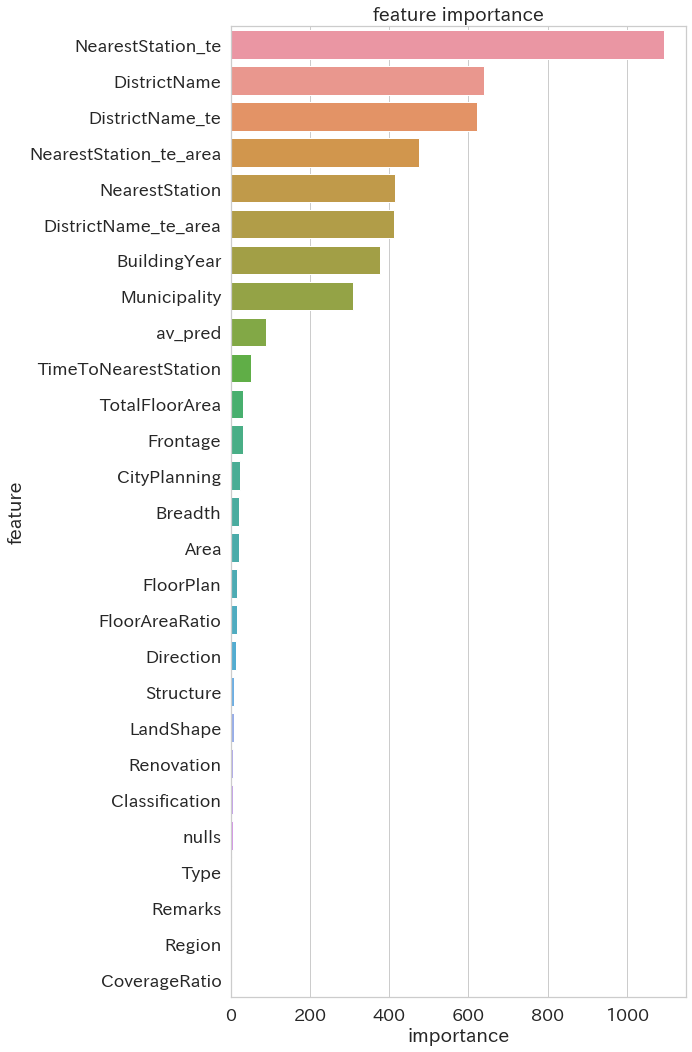

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 358.1080371	best: 358.1080371 (0)	total: 282ms	remaining: 4m 41s
500:	learn: 83.3249806	test: 245.2708701	best: 245.2708701 (500)	total: 2m 13s	remaining: 2m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 245.1365866
bestIteration = 541

Shrink model to first 542 iterations.
Partial score of seed 10 fold 1 is: 245.13658656382012
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.32s/it, best loss: 0.0033979182047252365]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8638016531726145
Partial score of fold 1 is: 0.8799312237986789
Partial score of fold 2 is: 0.8859136274693

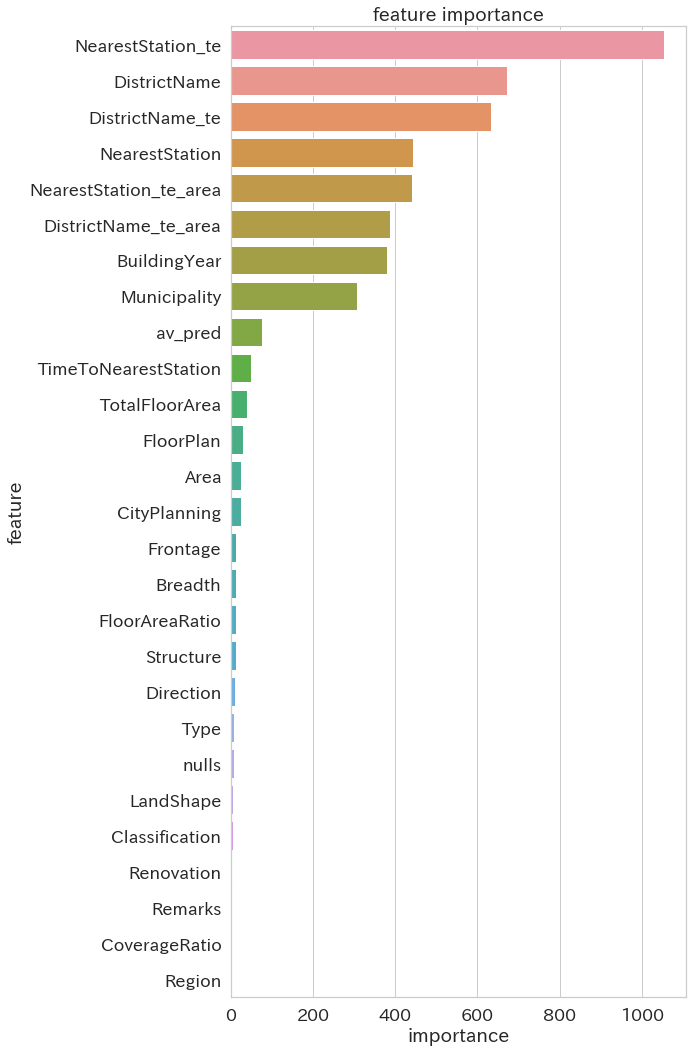

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 268.4121331	best: 268.4121331 (0)	total: 280ms	remaining: 4m 39s
500:	learn: 83.5246945	test: 198.7364155	best: 198.6836852 (414)	total: 2m 9s	remaining: 2m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 198.0012377
bestIteration = 533

Shrink model to first 534 iterations.
Partial score of seed 10 fold 2 is: 198.00123765673914
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.32s/it, best loss: 0.002781346120921069]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.878656615809511
Partial score of fold 1 is: 0.8619068040117094
Partial score of fold 2 is: 0.8698566328997867

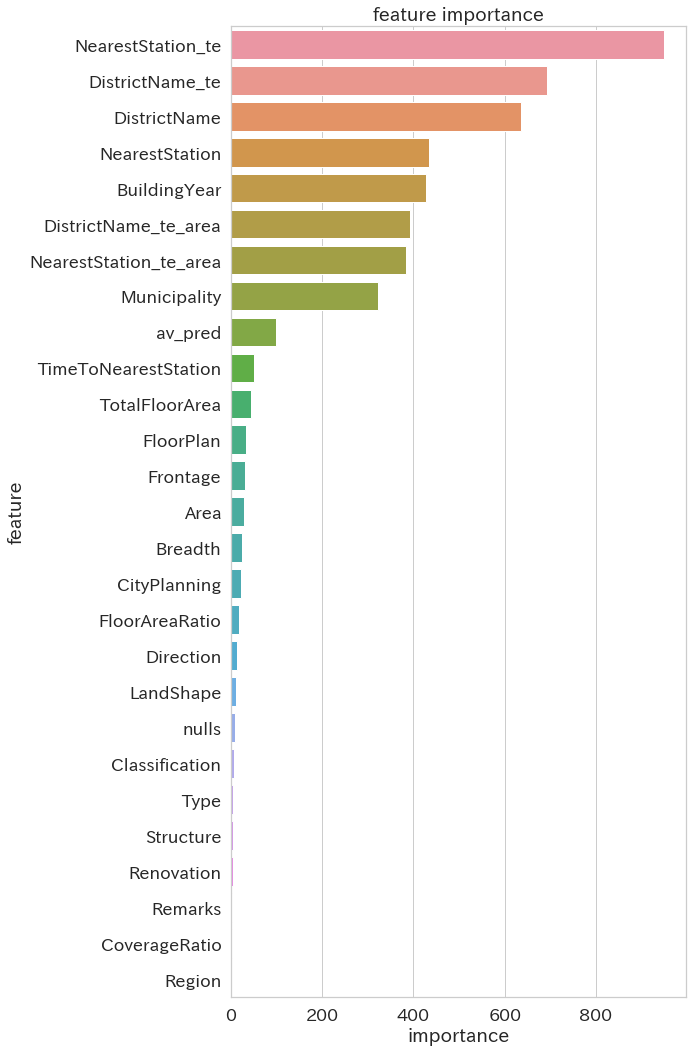

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 352.1185628	best: 352.1185628 (0)	total: 285ms	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 260.863612
bestIteration = 62

Shrink model to first 63 iterations.
Partial score of seed 10 fold 3 is: 260.8636120266303
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it, best loss: 0.003989477621618609]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8679829232719924
Partial score of fold 1 is: 0.8779482126324242
Partial score of fold 2 is: 0.8709695802511296
Partial score of fold 3 is: 0.8817425360522668
Partial score of fold 4 is: 0.8567195054690965
OOF

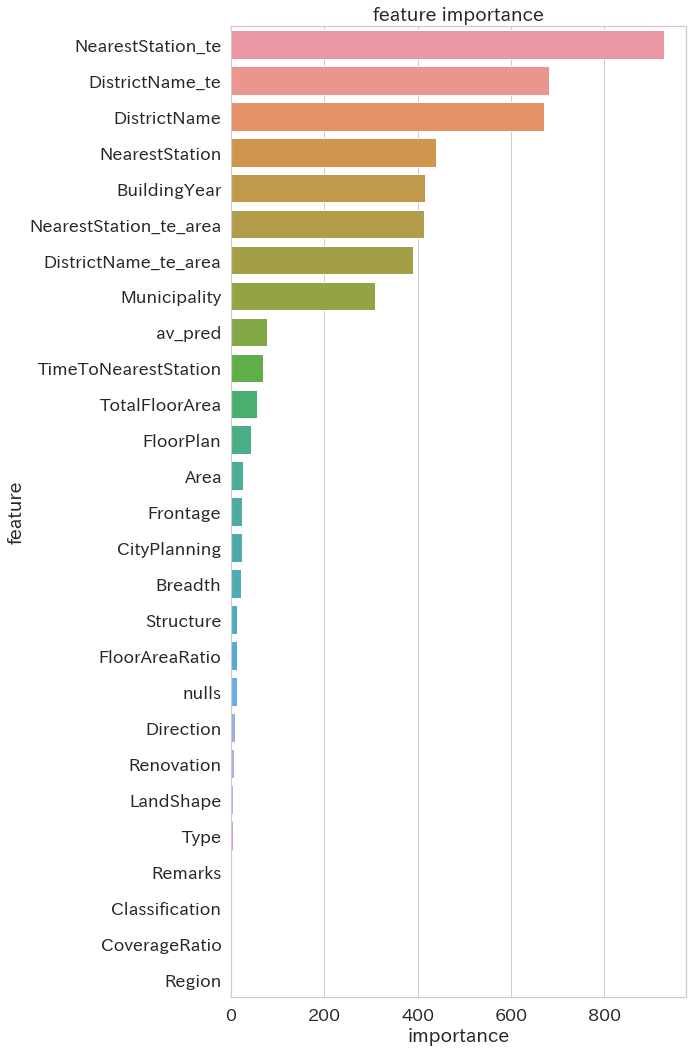

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 217.6644640	best: 217.6644640 (0)	total: 276ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 133.1613628
bestIteration = 206

Shrink model to first 207 iterations.
Partial score of seed 10 fold 4 is: 133.16136281472436
OOF score of seed 10 is: 201.53141191193893
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.22s/it, best loss: 0.0029997903505261103]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9262541279307692
Partial score of fold 1 is: 0.9124998449111419
Partial score of fold 2 is: 0.9165266681547144
Partial score of fold 3 is: 0.9023352639594631
Pa

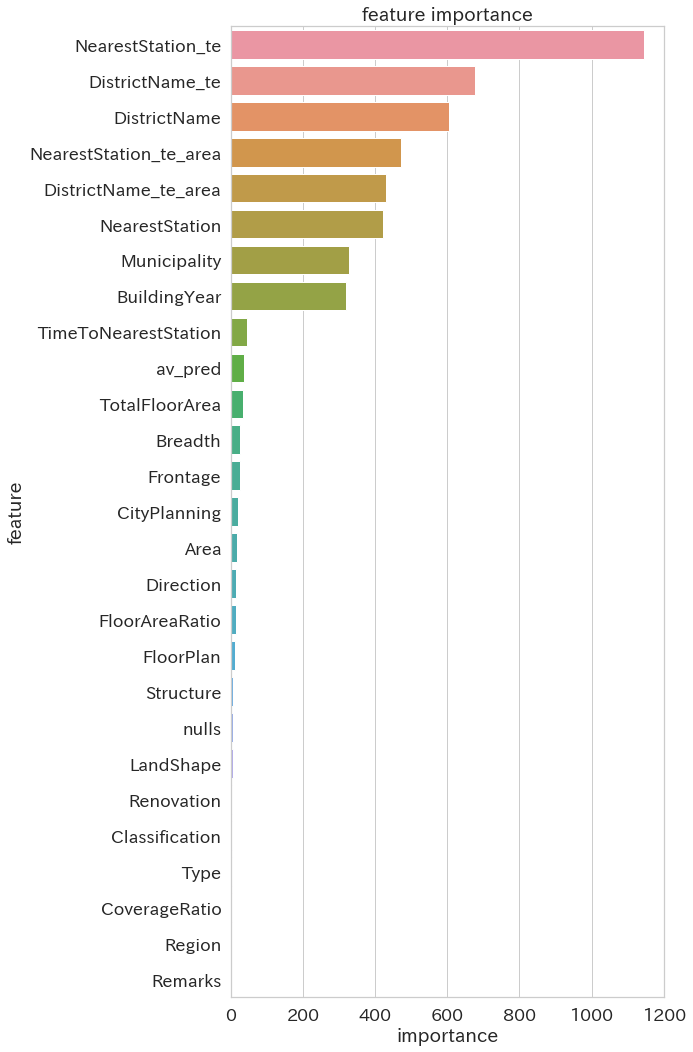

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 252.8951731	best: 252.8951731 (0)	total: 285ms	remaining: 4m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 144.4316163
bestIteration = 40

Shrink model to first 41 iterations.
Partial score of seed 11 fold 0 is: 144.43161627875654
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.30s/it, best loss: 0.0022495978136685135]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8778728089859946
Partial score of fold 1 is: 0.8953873987675379
Partial score of fold 2 is: 0.8832520160714417
Partial score of fold 3 is: 0.8714246626547499
Partial score of fold 4 is: 0.8822666925678566
OO

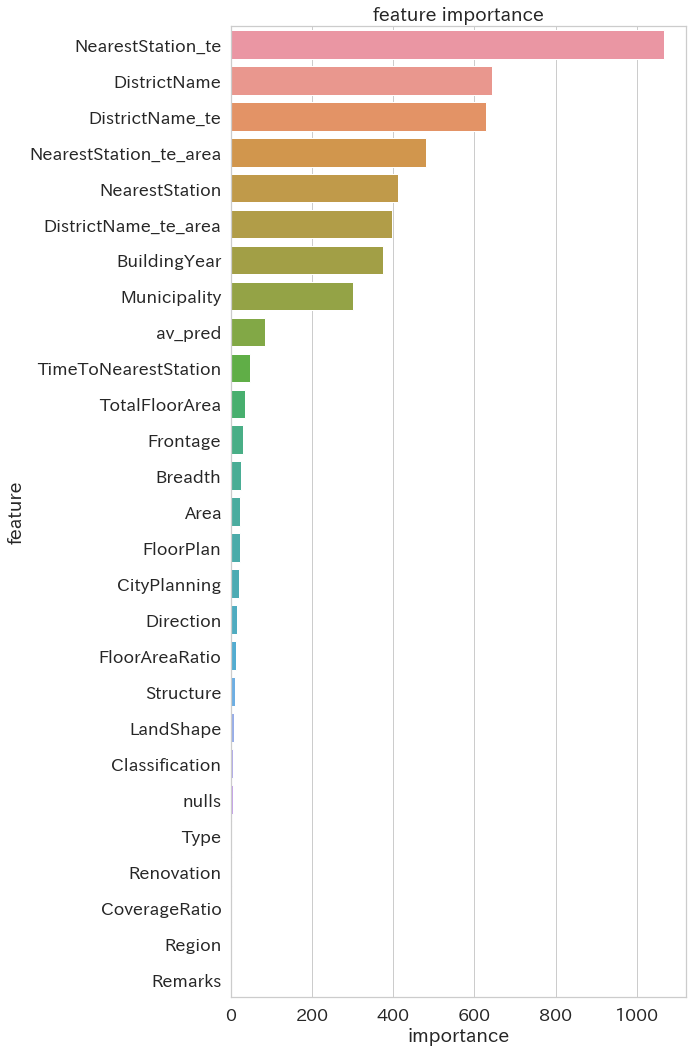

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 351.6930209	best: 351.6930209 (0)	total: 283ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 245.3602619
bestIteration = 296

Shrink model to first 297 iterations.
Partial score of seed 11 fold 1 is: 245.36026193948422
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it, best loss: 0.0031510486778930646]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8656020389602954
Partial score of fold 1 is: 0.8599881870446537
Partial score of fold 2 is: 0.850367770639394
Partial score of fold 3 is: 0.8775117164680892
Partial score of fold 4 is: 0.8700293996319848


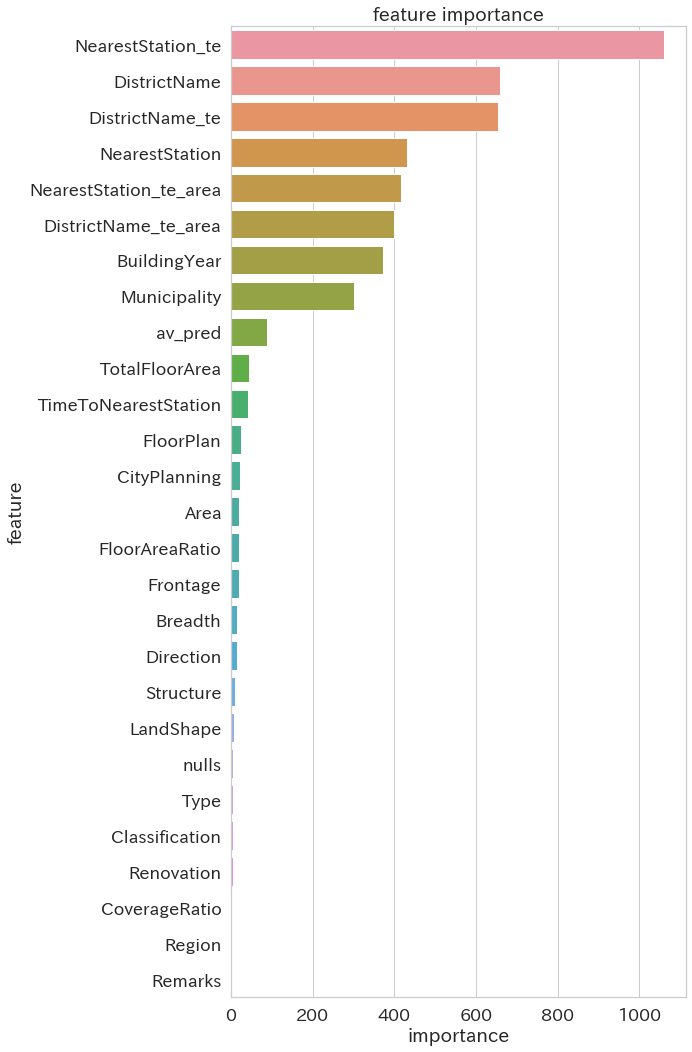

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 213.3095226	best: 213.3095226 (0)	total: 278ms	remaining: 4m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 150.7147682
bestIteration = 71

Shrink model to first 72 iterations.
Partial score of seed 11 fold 2 is: 150.7147682428699
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it, best loss: 0.0035979109467685344]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8860685670617349
Partial score of fold 1 is: 0.8787264864953033
Partial score of fold 2 is: 0.8809070467999499
Partial score of fold 3 is: 0.8684237804236563
Partial score of fold 4 is: 0.8884407585190611
OO

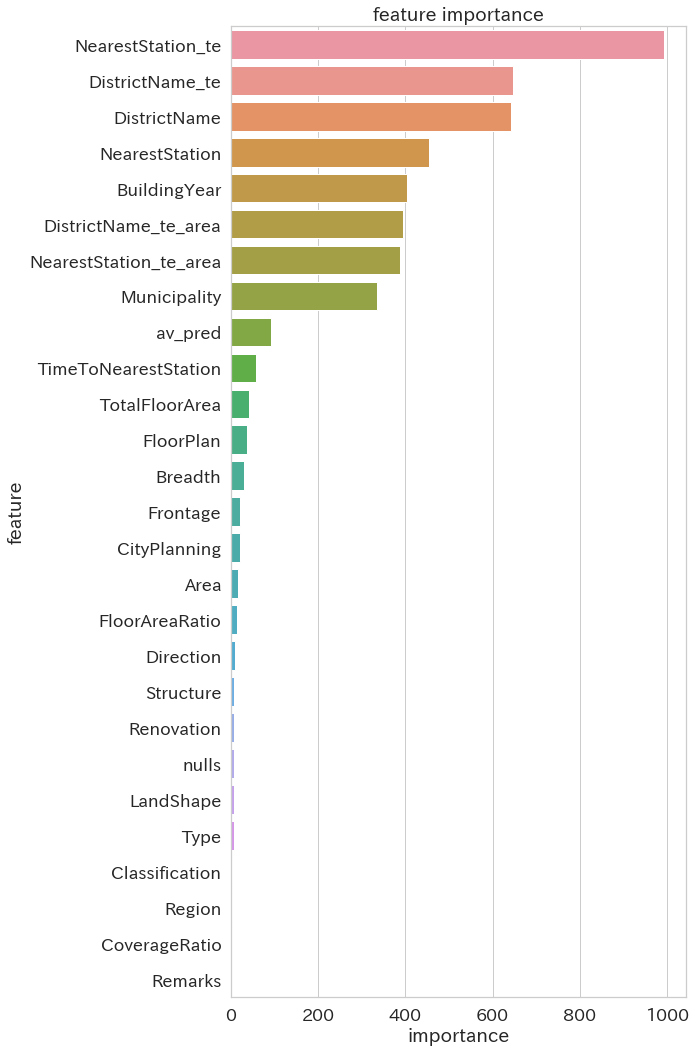

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 372.7824418	best: 372.7824418 (0)	total: 283ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 282.0270591
bestIteration = 60

Shrink model to first 61 iterations.
Partial score of seed 11 fold 3 is: 282.0270591109264
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it, best loss: 0.004119766965672844]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.859941445721325
Partial score of fold 1 is: 0.8771560759167449
Partial score of fold 2 is: 0.8589933617605937
Partial score of fold 3 is: 0.8600298216253393
Partial score of fold 4 is: 0.8710879473077884
OOF

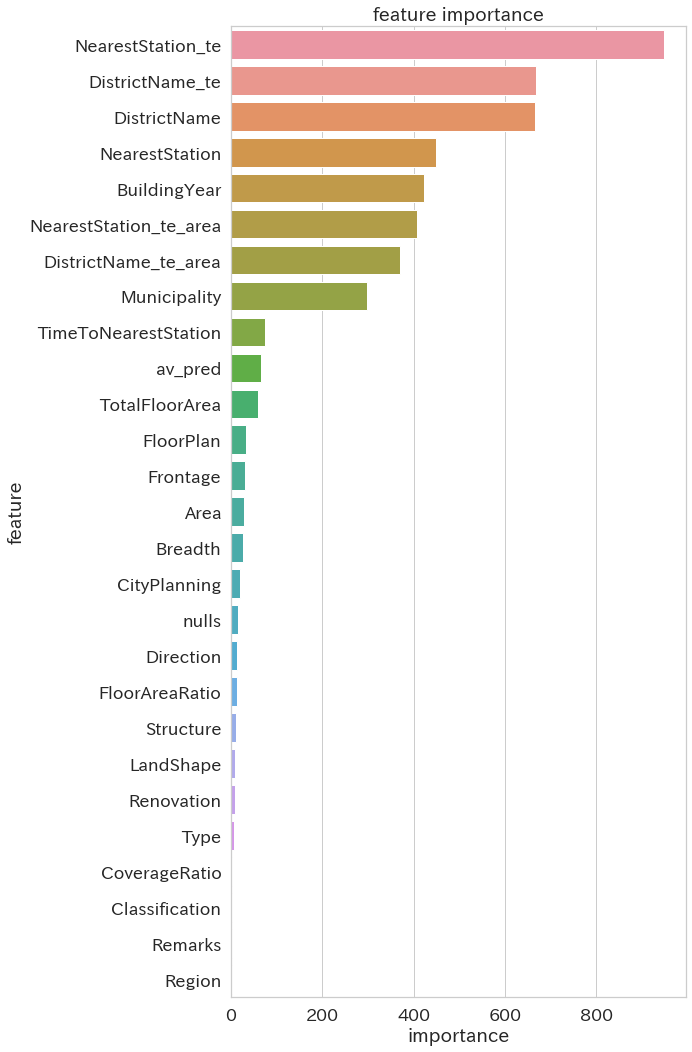

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 196.7626050	best: 196.7626050 (0)	total: 279ms	remaining: 4m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 119.1197779
bestIteration = 220

Shrink model to first 221 iterations.
Partial score of seed 11 fold 4 is: 119.11977792956682
OOF score of seed 11 is: 188.33069670032077
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it, best loss: 0.0028897349667422745]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9168275681707968
Partial score of fold 1 is: 0.9138343191518419
Partial score of fold 2 is: 0.915659050896183
Partial score of fold 3 is: 0.9145321875265252
Par

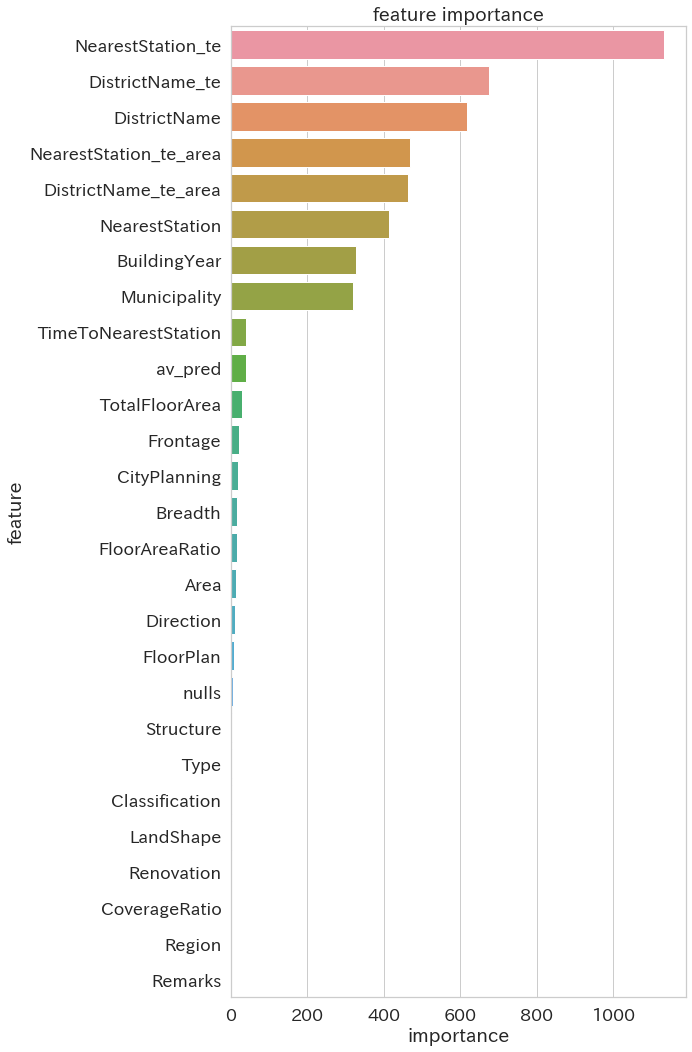

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 292.8835386	best: 292.8835386 (0)	total: 278ms	remaining: 4m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 176.2967683
bestIteration = 217

Shrink model to first 218 iterations.
Partial score of seed 12 fold 0 is: 176.2967682694037
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.23s/it, best loss: 0.0026084761751831165]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8928644196993623
Partial score of fold 1 is: 0.884444829094627
Partial score of fold 2 is: 0.8761573542615868
Partial score of fold 3 is: 0.8863643756032061
Partial score of fold 4 is: 0.8795891978934086
OO

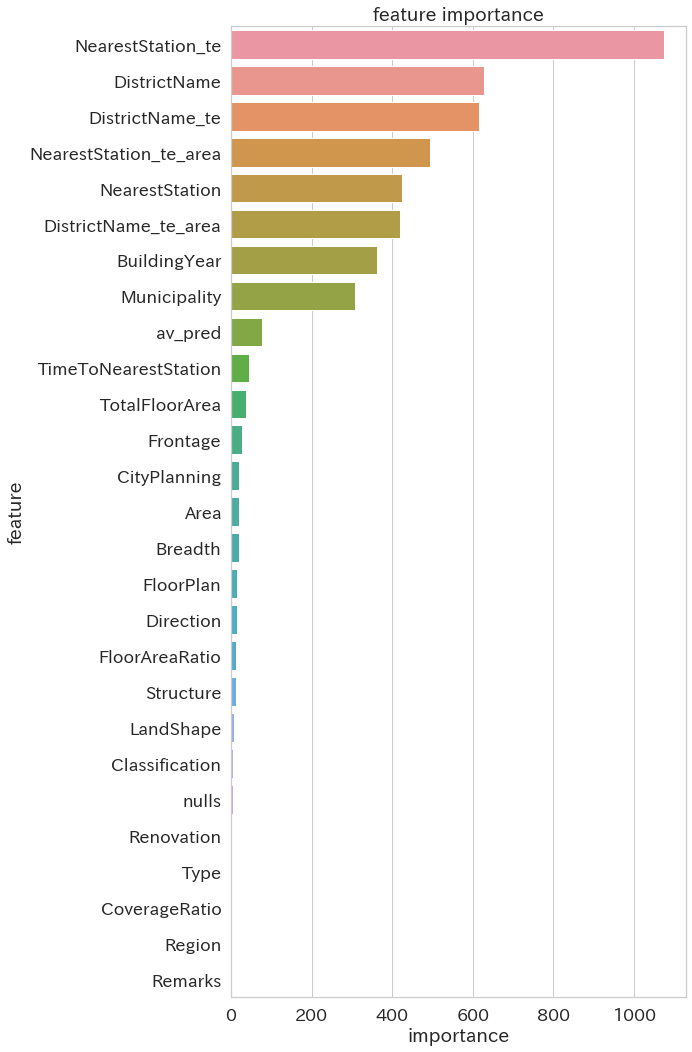

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 399.5777328	best: 399.5777328 (0)	total: 284ms	remaining: 4m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 284.4858267
bestIteration = 296

Shrink model to first 297 iterations.
Partial score of seed 12 fold 1 is: 284.4858266544377
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it, best loss: 0.004362780194273719]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8831330511637233
Partial score of fold 1 is: 0.8770304756096674
Partial score of fold 2 is: 0.8797481497339674
Partial score of fold 3 is: 0.8797230138426546
Partial score of fold 4 is: 0.8805373275701063


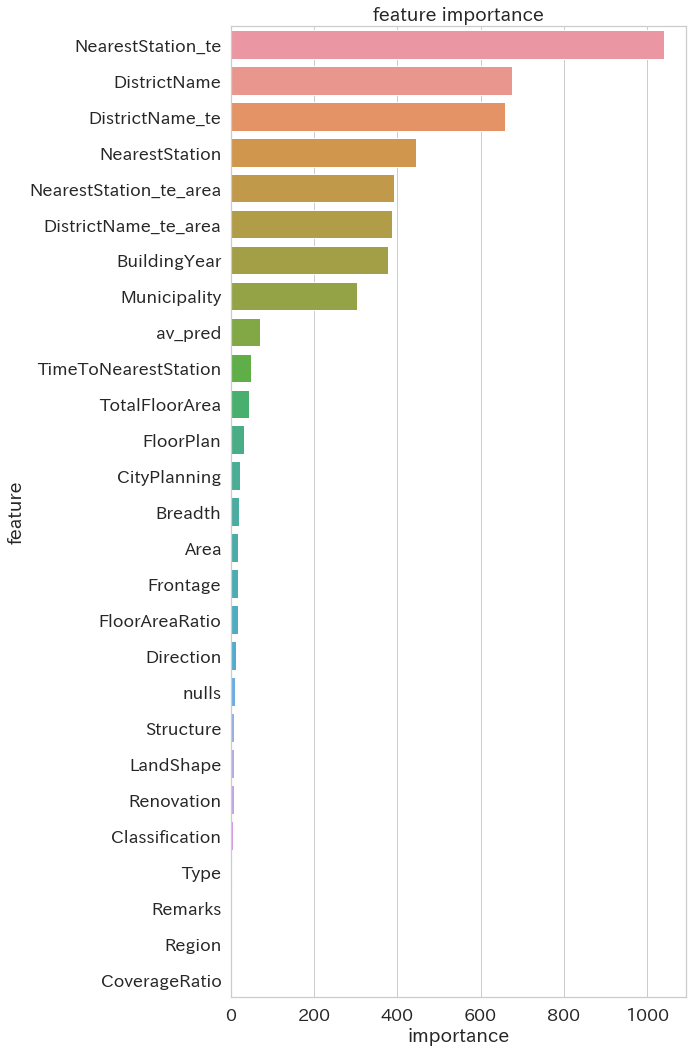

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 228.3712387	best: 228.3712387 (0)	total: 279ms	remaining: 4m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 161.5610594
bestIteration = 37

Shrink model to first 38 iterations.
Partial score of seed 12 fold 2 is: 161.56105944275865
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it, best loss: 0.0038758918610198867]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8650111981513702
Partial score of fold 1 is: 0.8605536498276845
Partial score of fold 2 is: 0.8668212553568405
Partial score of fold 3 is: 0.8767119887262211
Partial score of fold 4 is: 0.8672566644135314
O

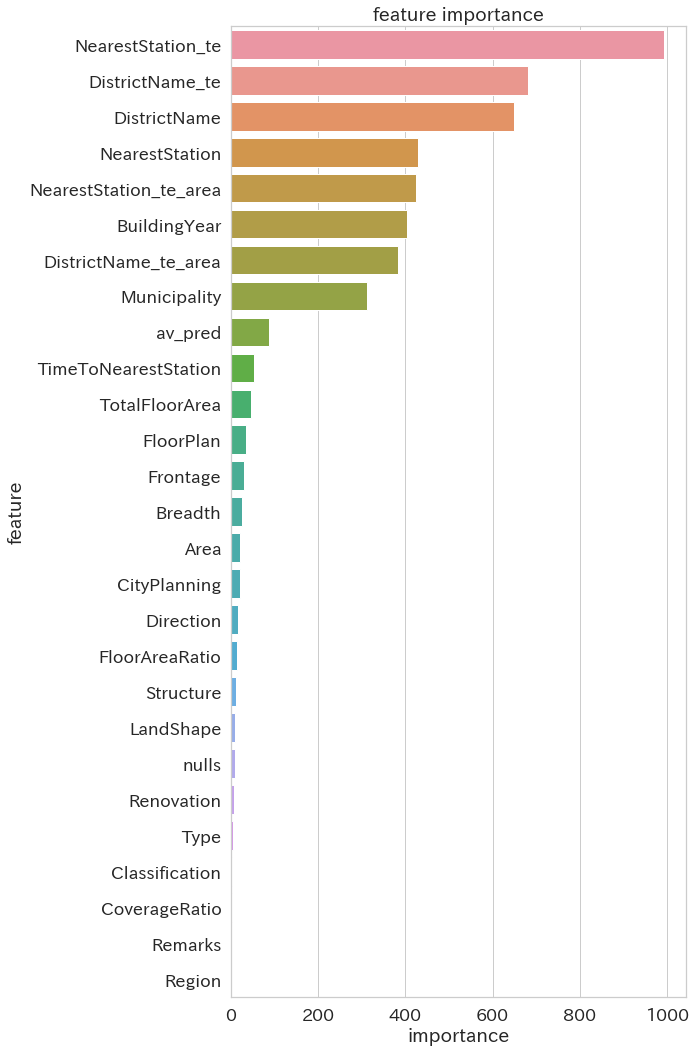

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 326.7478376	best: 326.7478376 (0)	total: 280ms	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 257.8085733
bestIteration = 22

Shrink model to first 23 iterations.
Partial score of seed 12 fold 3 is: 257.8085732556892
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.31s/it, best loss: 0.004394419767328017]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8677201079933151
Partial score of fold 1 is: 0.8755350492531405
Partial score of fold 2 is: 0.874786600429483
Partial score of fold 3 is: 0.8685105209586669
Partial score of fold 4 is: 0.8596537452498676
OOF

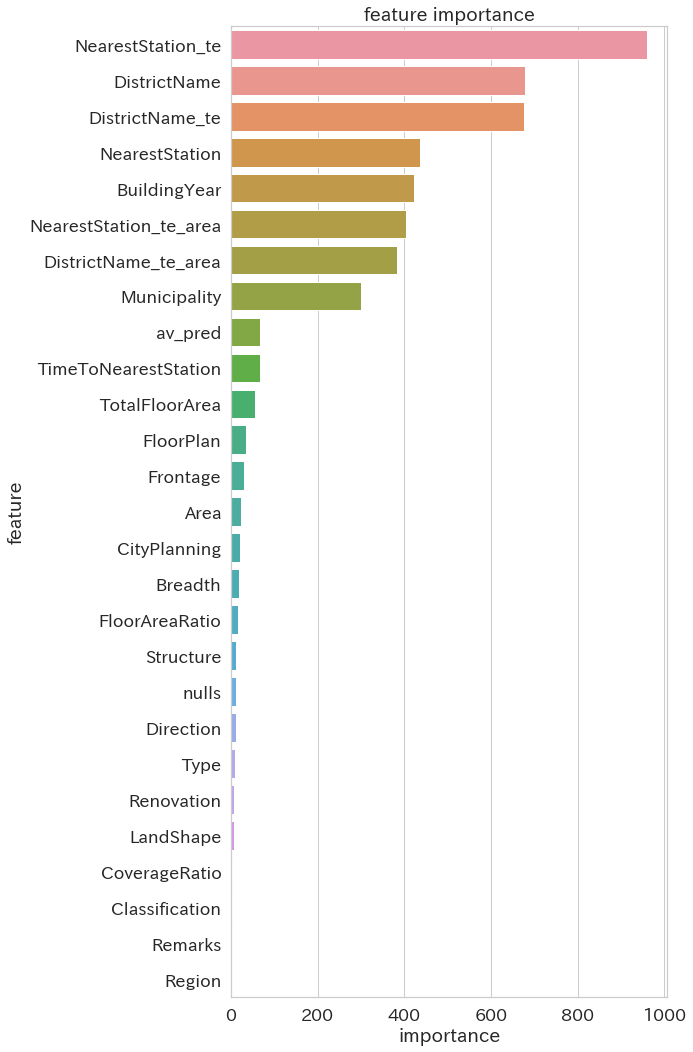

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 222.1950140	best: 222.1950140 (0)	total: 276ms	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 132.8096845
bestIteration = 76

Shrink model to first 77 iterations.
Partial score of seed 12 fold 4 is: 132.80968448026536
OOF score of seed 12 is: 202.59238242051094
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.39s/it, best loss: 0.0027728017255141957]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9229392945980146
Partial score of fold 1 is: 0.9034705902264129
Partial score of fold 2 is: 0.9087138286869877
Partial score of fold 3 is: 0.9018746278815224
Part

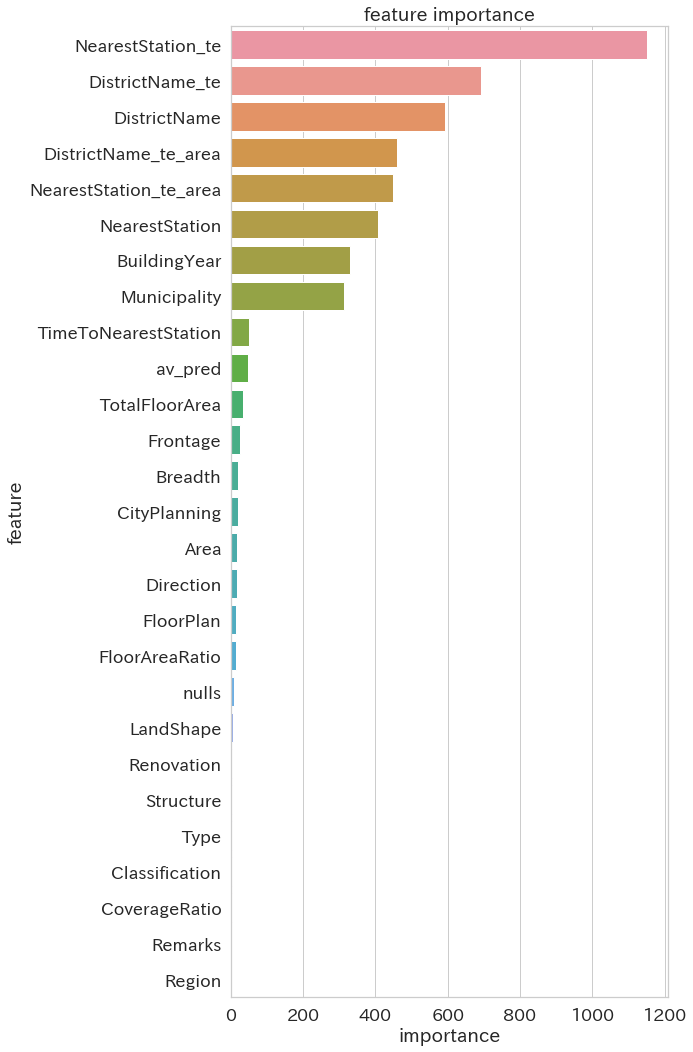

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 257.2773455	best: 257.2773455 (0)	total: 281ms	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 159.5798565
bestIteration = 134

Shrink model to first 135 iterations.
Partial score of seed 13 fold 0 is: 159.57985651612591
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it, best loss: 0.0025845999271485454]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8973004690902524
Partial score of fold 1 is: 0.8783069271385633
Partial score of fold 2 is: 0.8676801085838346
Partial score of fold 3 is: 0.8923651925152991
Partial score of fold 4 is: 0.8862514081622204


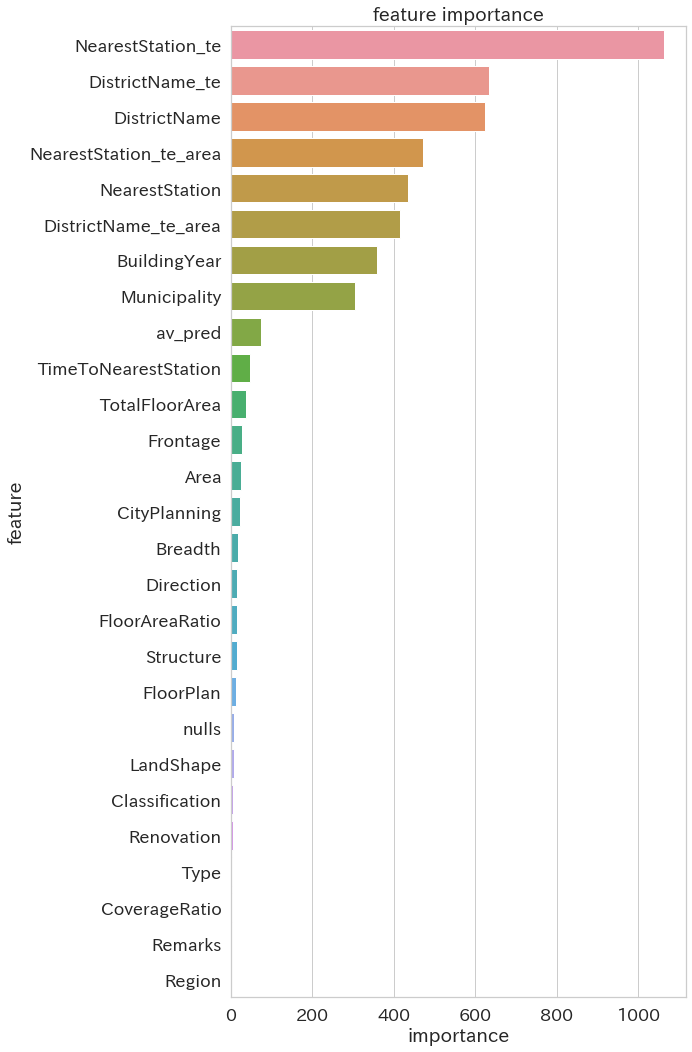

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 325.2549397	best: 325.2549397 (0)	total: 284ms	remaining: 4m 44s
500:	learn: 83.3249806	test: 231.4660471	best: 231.1432604 (461)	total: 2m 10s	remaining: 2m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 231.1432604
bestIteration = 461

Shrink model to first 462 iterations.
Partial score of seed 13 fold 1 is: 231.14326036090097
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it, best loss: 0.0029286987265869646]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8746596222339122
Partial score of fold 1 is: 0.8624925168353863
Partial score of fold 2 is: 0.87321996325941

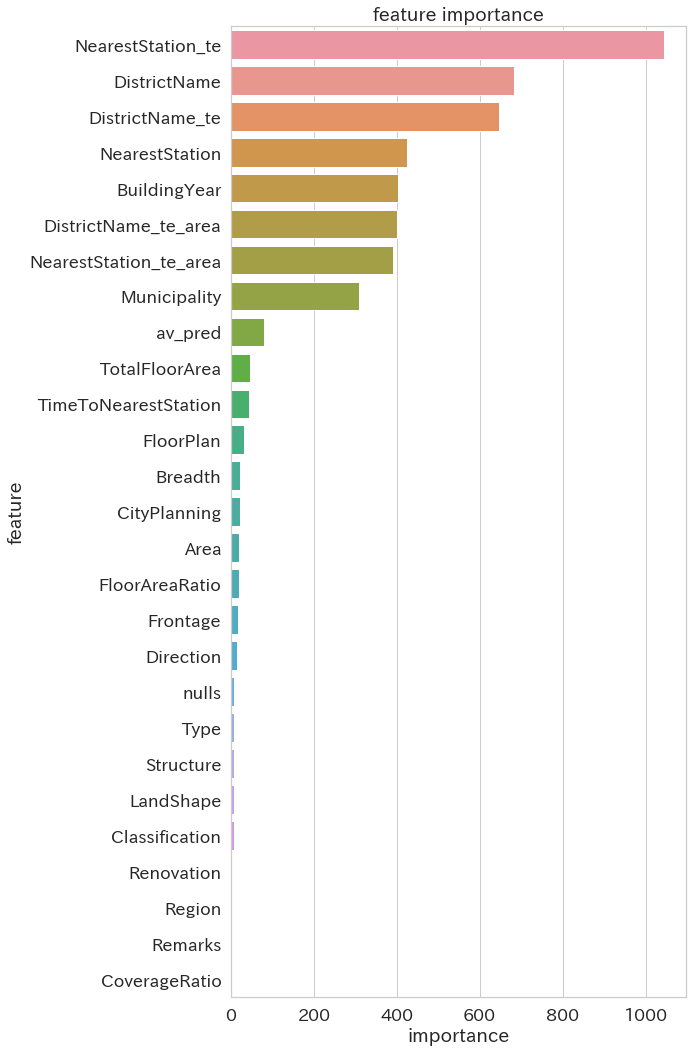

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 242.9680856	best: 242.9680856 (0)	total: 278ms	remaining: 4m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 175.7440156
bestIteration = 37

Shrink model to first 38 iterations.
Partial score of seed 13 fold 2 is: 175.7440156376497
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.33s/it, best loss: 0.002993944880096966]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8876057571321201
Partial score of fold 1 is: 0.8889672705565228
Partial score of fold 2 is: 0.8818480042731599
Partial score of fold 3 is: 0.8842700575180887
Partial score of fold 4 is: 0.8785394874913478
OO

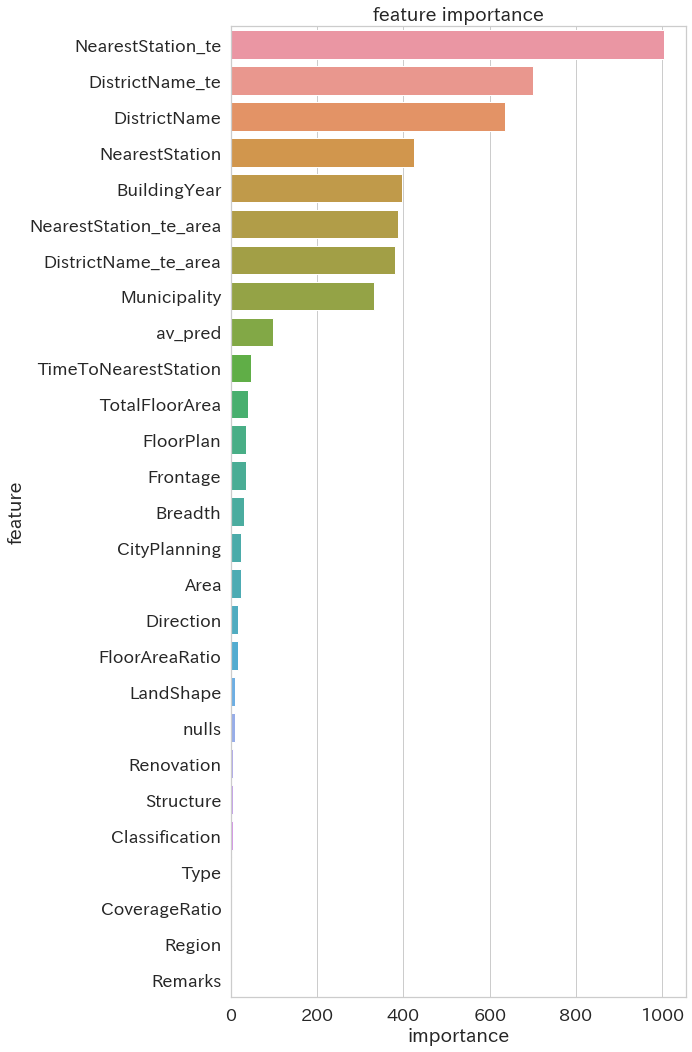

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 236.1797929	best: 236.1797929 (0)	total: 283ms	remaining: 4m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 190.0753596
bestIteration = 22

Shrink model to first 23 iterations.
Partial score of seed 13 fold 3 is: 190.0753596351694
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.39s/it, best loss: 0.003846891558934473]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8544424852266552
Partial score of fold 1 is: 0.8598133386564761
Partial score of fold 2 is: 0.8731259886651993
Partial score of fold 3 is: 0.8680980391126225
Partial score of fold 4 is: 0.8704752290687559
OO

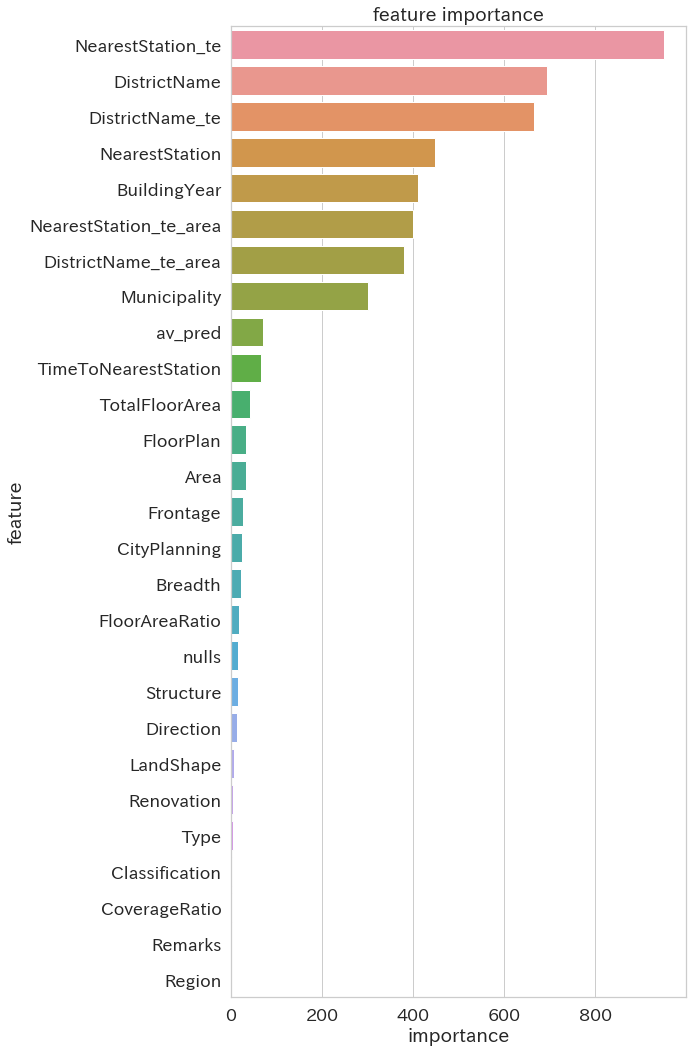

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 321.6996614	best: 321.6996614 (0)	total: 294ms	remaining: 4m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 237.7834028
bestIteration = 63

Shrink model to first 64 iterations.
Partial score of seed 13 fold 4 is: 237.7834028099727
OOF score of seed 13 is: 198.86517899196375
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.30s/it, best loss: 0.0028179346383537807]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9051949245060595
Partial score of fold 1 is: 0.9148803936605161
Partial score of fold 2 is: 0.9159100885752663
Partial score of fold 3 is: 0.9125955264150749
Parti

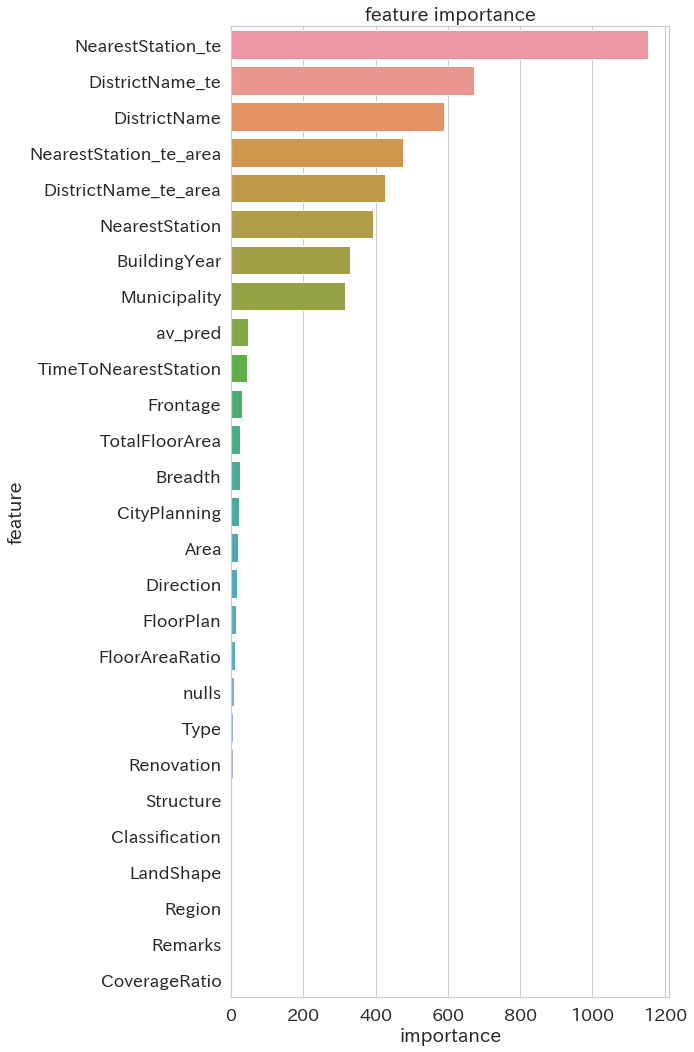

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 240.8816306	best: 240.8816306 (0)	total: 277ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 155.8804887
bestIteration = 187

Shrink model to first 188 iterations.
Partial score of seed 14 fold 0 is: 155.88048866099385
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.25s/it, best loss: 0.0026979516039375984]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.890146475294016
Partial score of fold 1 is: 0.8976858388246582
Partial score of fold 2 is: 0.8814054029470827
Partial score of fold 3 is: 0.8901932152653923
Partial score of fold 4 is: 0.8807050663428363
O

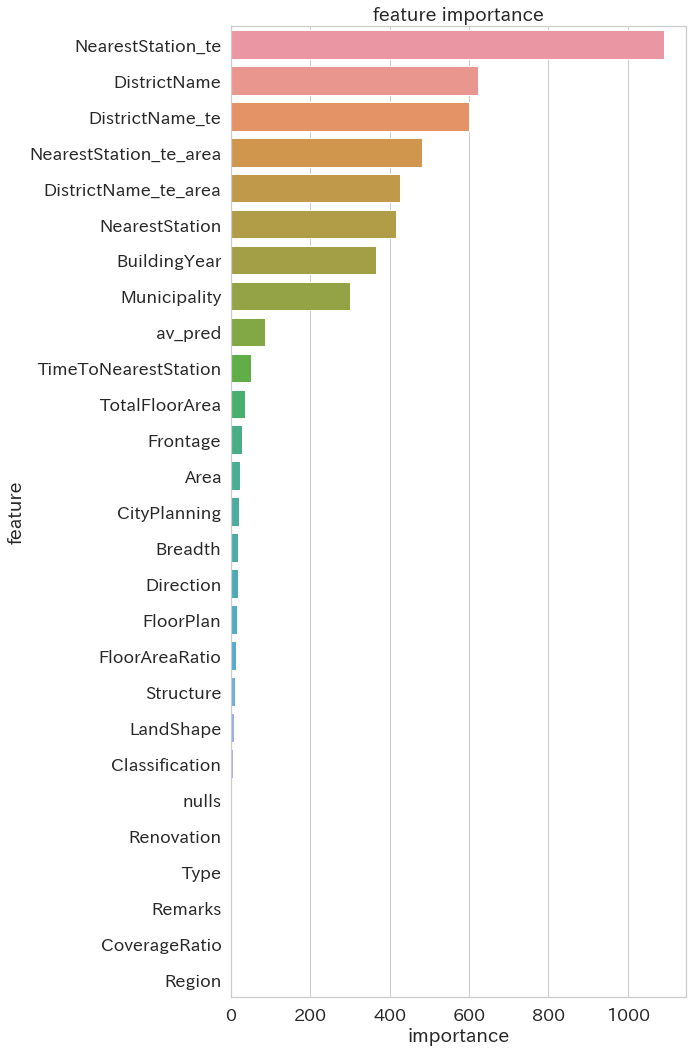

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 349.8307462	best: 349.8307462 (0)	total: 290ms	remaining: 4m 49s
500:	learn: 83.3249806	test: 223.1582304	best: 222.9076270 (471)	total: 2m 10s	remaining: 2m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 221.1909944
bestIteration = 651

Shrink model to first 652 iterations.
Partial score of seed 14 fold 1 is: 221.19099436480505
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it, best loss: 0.0027754494245602057]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8727833637093718
Partial score of fold 1 is: 0.8713853590159154
Partial score of fold 2 is: 0.86795192139154

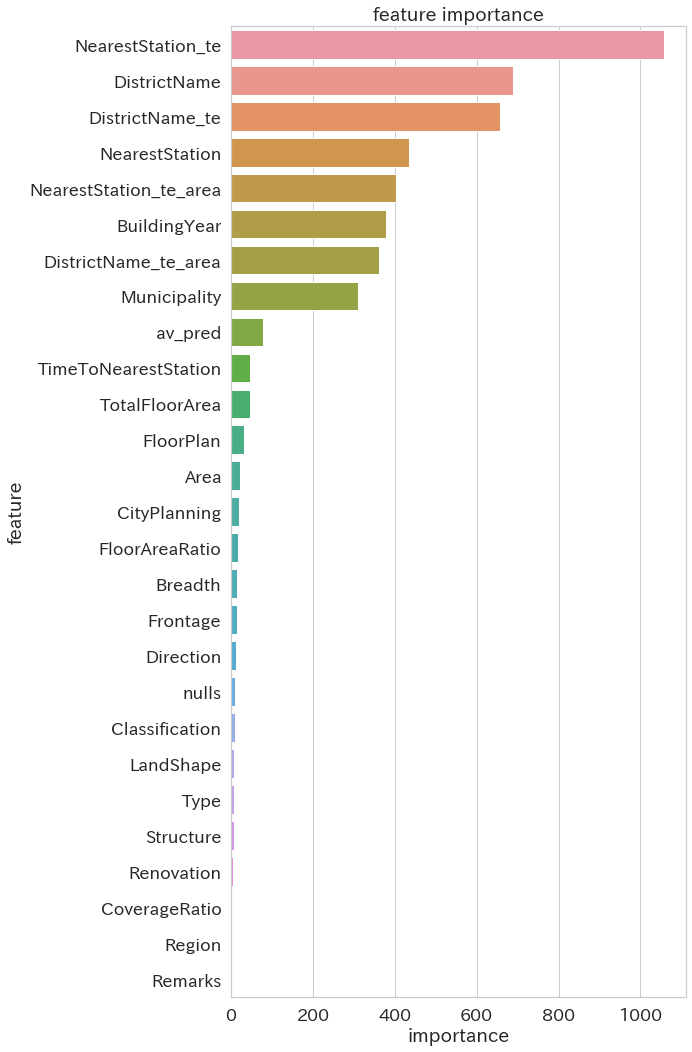

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 226.6677545	best: 226.6677545 (0)	total: 283ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 144.1132979
bestIteration = 146

Shrink model to first 147 iterations.
Partial score of seed 14 fold 2 is: 144.11329788064063
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it, best loss: 0.003498616829817114]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8659818698905217
Partial score of fold 1 is: 0.8578413796233055
Partial score of fold 2 is: 0.8729195172114443
Partial score of fold 3 is: 0.8869961335606156
Partial score of fold 4 is: 0.873251320771681


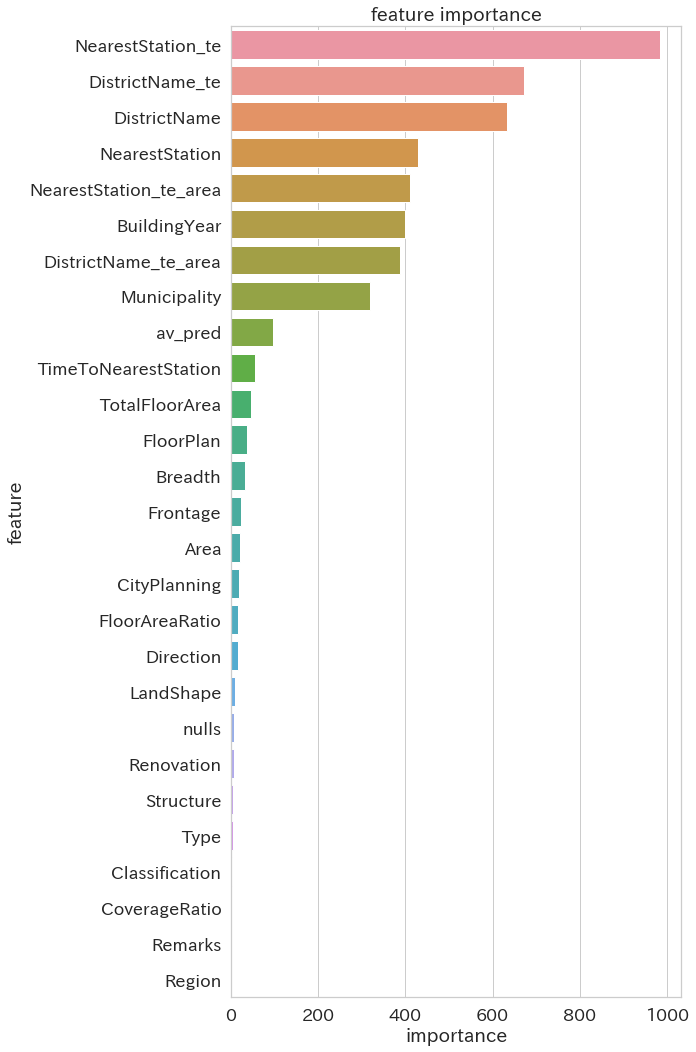

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 291.9631747	best: 291.9631747 (0)	total: 294ms	remaining: 4m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 218.5540059
bestIteration = 64

Shrink model to first 65 iterations.
Partial score of seed 14 fold 3 is: 218.5540058988373
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.33s/it, best loss: 0.004577993901071387]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8782962567834112
Partial score of fold 1 is: 0.8721288570618821
Partial score of fold 2 is: 0.8686376862529226
Partial score of fold 3 is: 0.8712466965295721
Partial score of fold 4 is: 0.873393074939508
OOF

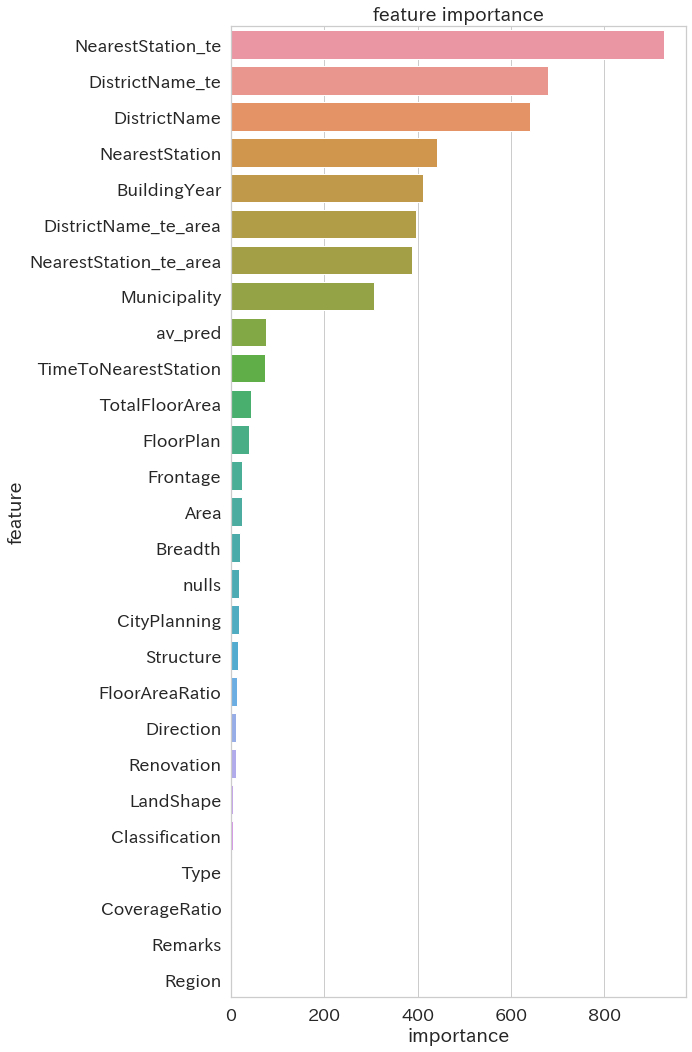

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 194.3850322	best: 194.3850322 (0)	total: 279ms	remaining: 4m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 119.6548354
bestIteration = 81

Shrink model to first 82 iterations.
Partial score of seed 14 fold 4 is: 119.65483539376272
OOF score of seed 14 is: 171.8787244398079
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it, best loss: 0.0032175932136756513]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9019857842140498
Partial score of fold 1 is: 0.8886043544725696
Partial score of fold 2 is: 0.9068078017215211
Partial score of fold 3 is: 0.9056440601684469
Parti

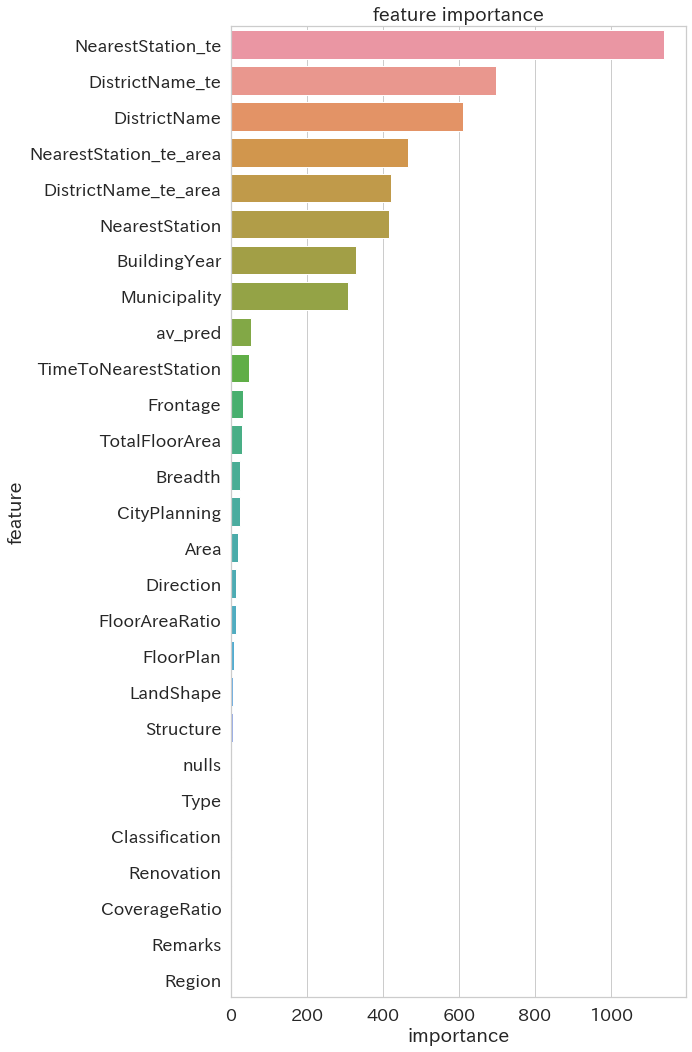

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 276.5349284	best: 276.5349284 (0)	total: 289ms	remaining: 4m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 183.5645414
bestIteration = 137

Shrink model to first 138 iterations.
Partial score of seed 15 fold 0 is: 183.5645413826347
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.27s/it, best loss: 0.0027769068073626446]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8773203982731799
Partial score of fold 1 is: 0.8783583309452134
Partial score of fold 2 is: 0.8780494236232497
Partial score of fold 3 is: 0.8890581250977471
Partial score of fold 4 is: 0.88658588870326
OOF

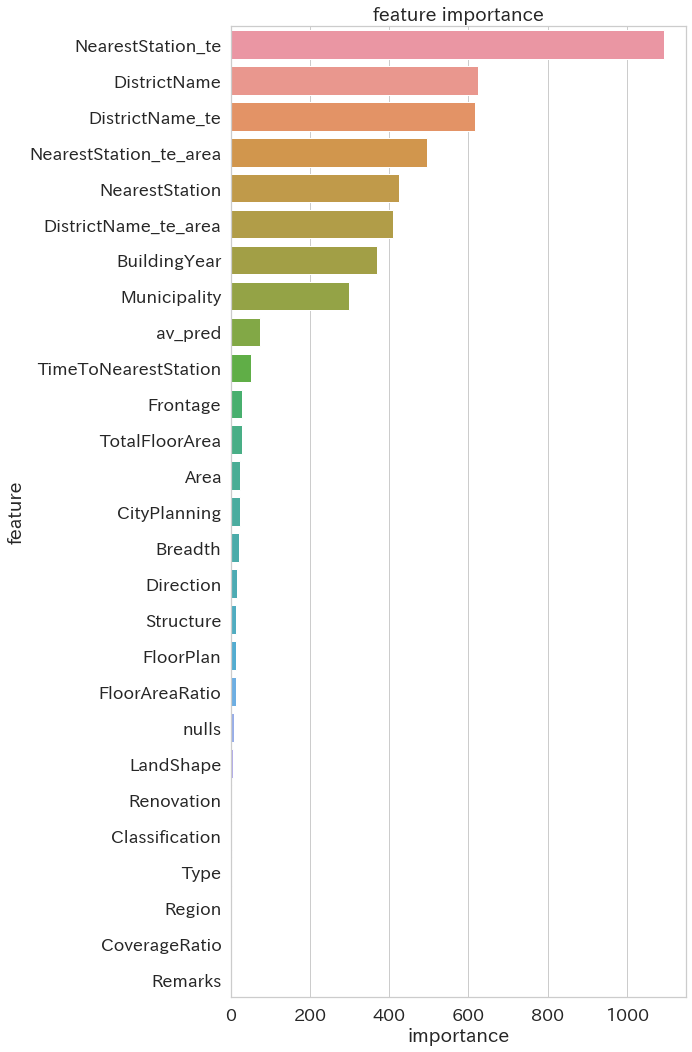

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 325.0727207	best: 325.0727207 (0)	total: 287ms	remaining: 4m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 199.3677611
bestIteration = 343

Shrink model to first 344 iterations.
Partial score of seed 15 fold 1 is: 199.3677610764934
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it, best loss: 0.003236278389571967]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8666427624968301
Partial score of fold 1 is: 0.8662657792540935
Partial score of fold 2 is: 0.8770404403799094
Partial score of fold 3 is: 0.8771093620268632
Partial score of fold 4 is: 0.8632125682489891


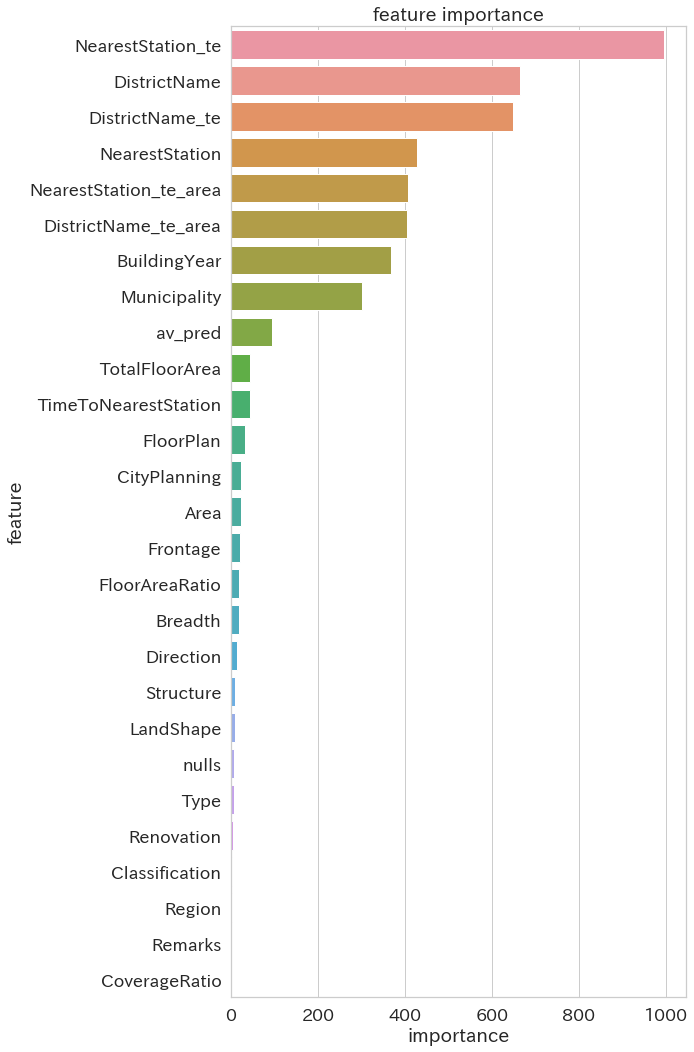

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 270.3841244	best: 270.3841244 (0)	total: 279ms	remaining: 4m 38s
500:	learn: 83.5246945	test: 162.9039256	best: 162.8282617 (496)	total: 2m 9s	remaining: 2m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 160.7152524
bestIteration = 672

Shrink model to first 673 iterations.
Partial score of seed 15 fold 2 is: 160.7152523908238
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.42s/it, best loss: 0.0026525098710475925]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8726667316518804
Partial score of fold 1 is: 0.8811537135354688
Partial score of fold 2 is: 0.8750383165696608

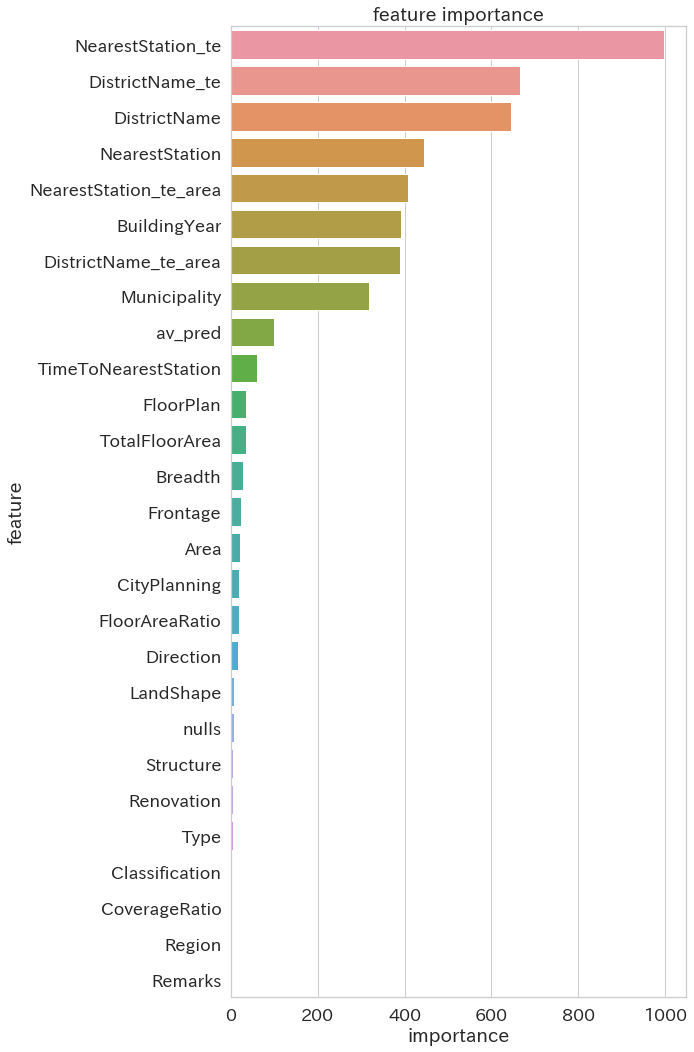

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 320.4646963	best: 320.4646963 (0)	total: 280ms	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 254.5466526
bestIteration = 22

Shrink model to first 23 iterations.
Partial score of seed 15 fold 3 is: 254.54665255471966
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.35s/it, best loss: 0.0050138768831290426]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8695846822606673
Partial score of fold 1 is: 0.8472396642841541
Partial score of fold 2 is: 0.8658326259967088
Partial score of fold 3 is: 0.8614762473733375
Partial score of fold 4 is: 0.8775018963629864
O

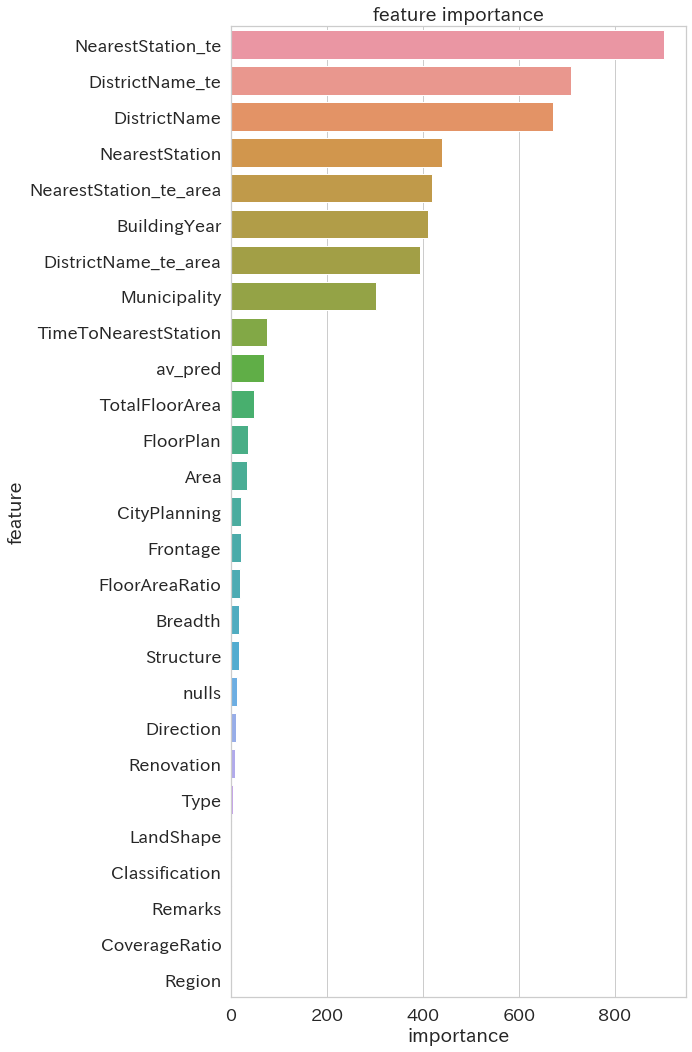

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 306.7452371	best: 306.7452371 (0)	total: 277ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 228.879524
bestIteration = 263

Shrink model to first 264 iterations.
Partial score of seed 15 fold 4 is: 228.87952396068516
OOF score of seed 15 is: 205.41474627307133
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.27s/it, best loss: 0.0025401926792872898]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9047995375590179
Partial score of fold 1 is: 0.912092277689372
Partial score of fold 2 is: 0.9141131635852549
Partial score of fold 3 is: 0.8951447815889941
Part

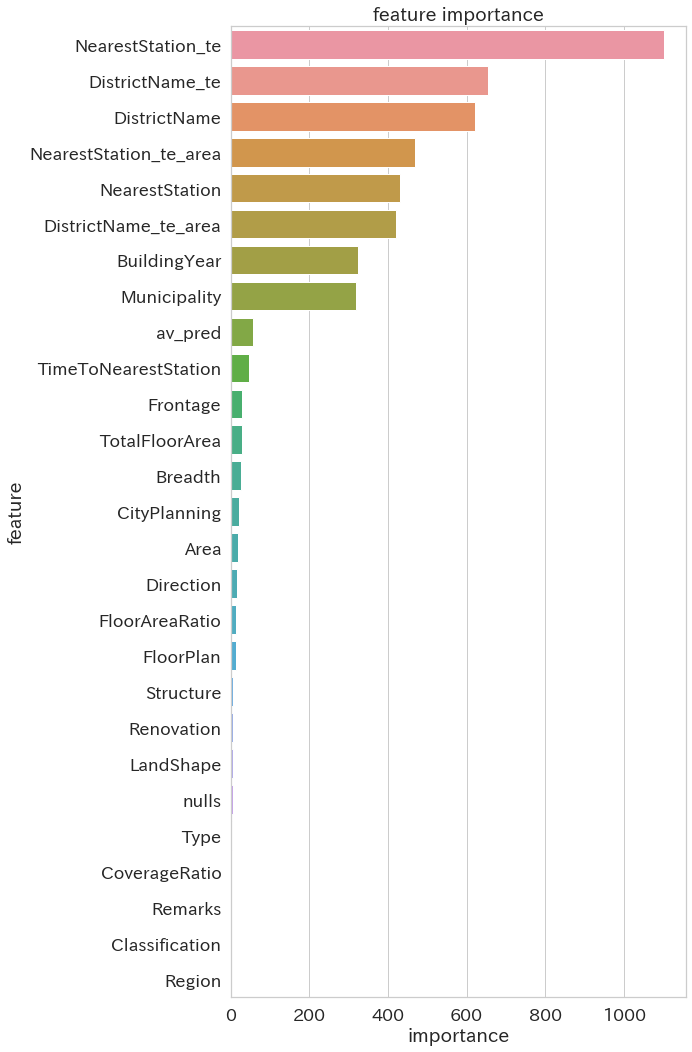

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 305.9762850	best: 305.9762850 (0)	total: 277ms	remaining: 4m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 178.1402884
bestIteration = 43

Shrink model to first 44 iterations.
Partial score of seed 16 fold 0 is: 178.1402883944544
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it, best loss: 0.0025008525160670203]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.886163233823331
Partial score of fold 1 is: 0.8906196919664604
Partial score of fold 2 is: 0.887606602549609
Partial score of fold 3 is: 0.8903356296120549
Partial score of fold 4 is: 0.876977915157702
OOF sc

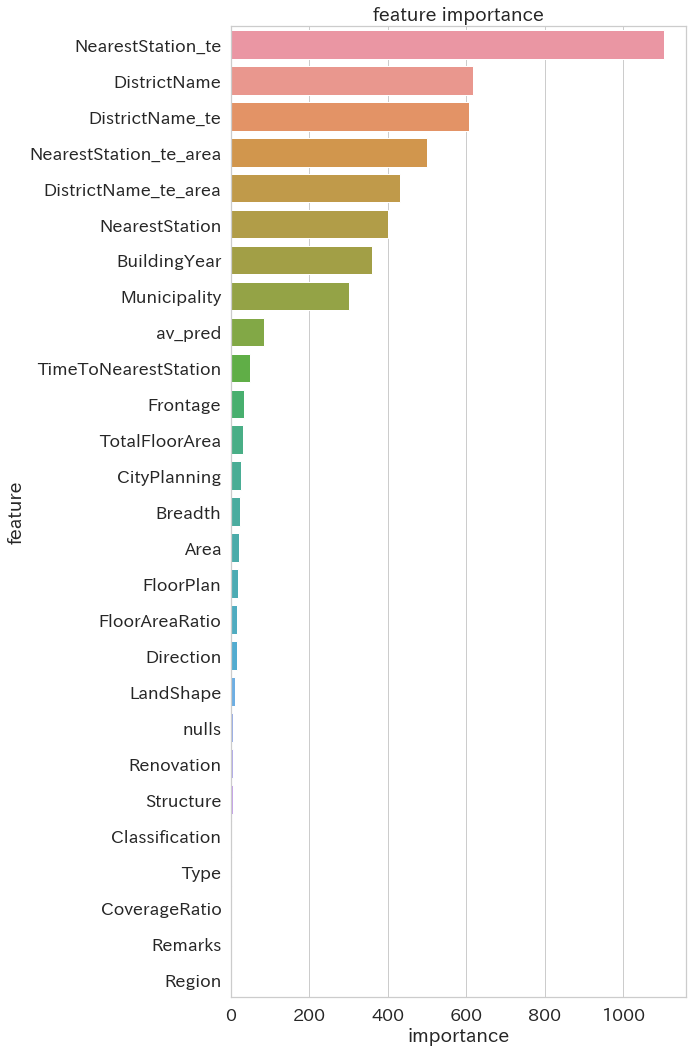

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 313.0176132	best: 313.0176132 (0)	total: 285ms	remaining: 4m 44s
500:	learn: 83.3249806	test: 201.7137642	best: 200.7335828 (461)	total: 2m 11s	remaining: 2m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 200.7335828
bestIteration = 461

Shrink model to first 462 iterations.
Partial score of seed 16 fold 1 is: 200.7335827799942
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it, best loss: 0.0032974742653635314]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8664247030217127
Partial score of fold 1 is: 0.879142966798744
Partial score of fold 2 is: 0.862398232802292

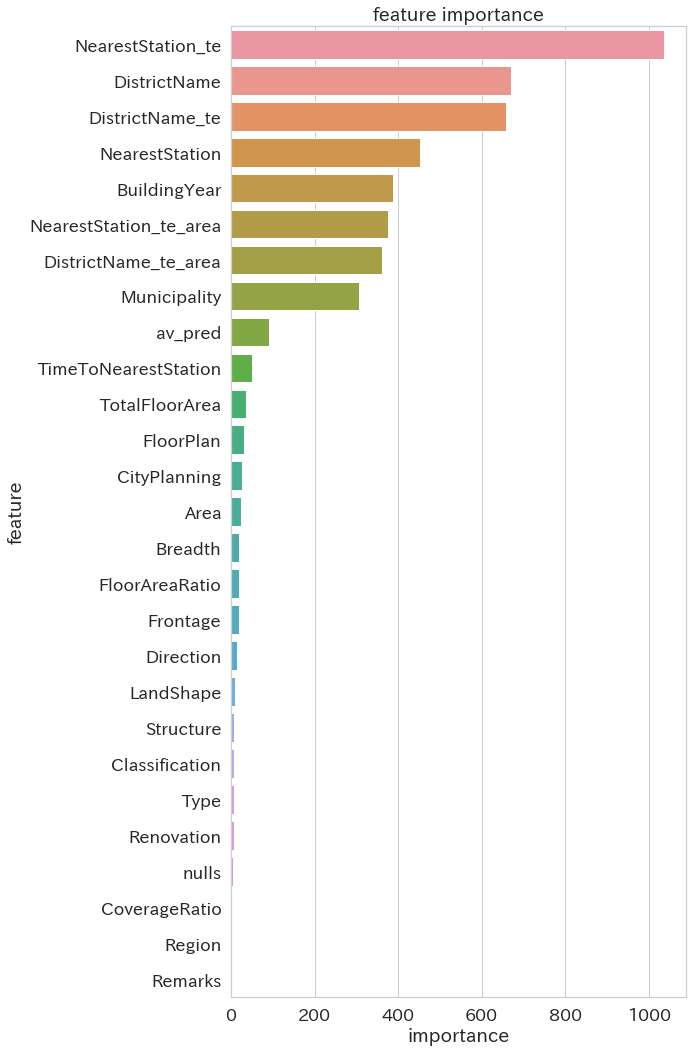

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 258.1877369	best: 258.1877369 (0)	total: 301ms	remaining: 5m
500:	learn: 83.5246945	test: 160.8414925	best: 160.7832177 (496)	total: 2m 9s	remaining: 2m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 160.5464697
bestIteration = 524

Shrink model to first 525 iterations.
Partial score of seed 16 fold 2 is: 160.54646969247312
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it, best loss: 0.003206729652462381]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8639328530783132
Partial score of fold 1 is: 0.8747164545458341
Partial score of fold 2 is: 0.8630909230729022
Pa

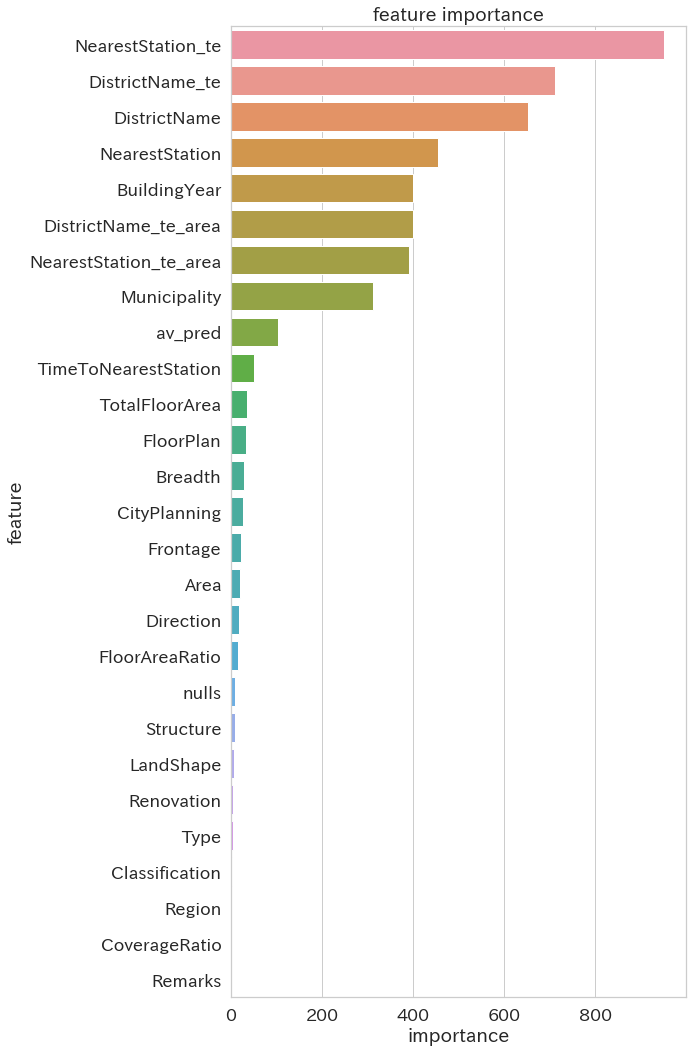

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 334.0854254	best: 334.0854254 (0)	total: 280ms	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 241.9134772
bestIteration = 60

Shrink model to first 61 iterations.
Partial score of seed 16 fold 3 is: 241.9134772373129
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it, best loss: 0.0049042737655835555]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8541410281566548
Partial score of fold 1 is: 0.8745350725080434
Partial score of fold 2 is: 0.8760358386721386
Partial score of fold 3 is: 0.8795706568894136
Partial score of fold 4 is: 0.878458102921315
OOF

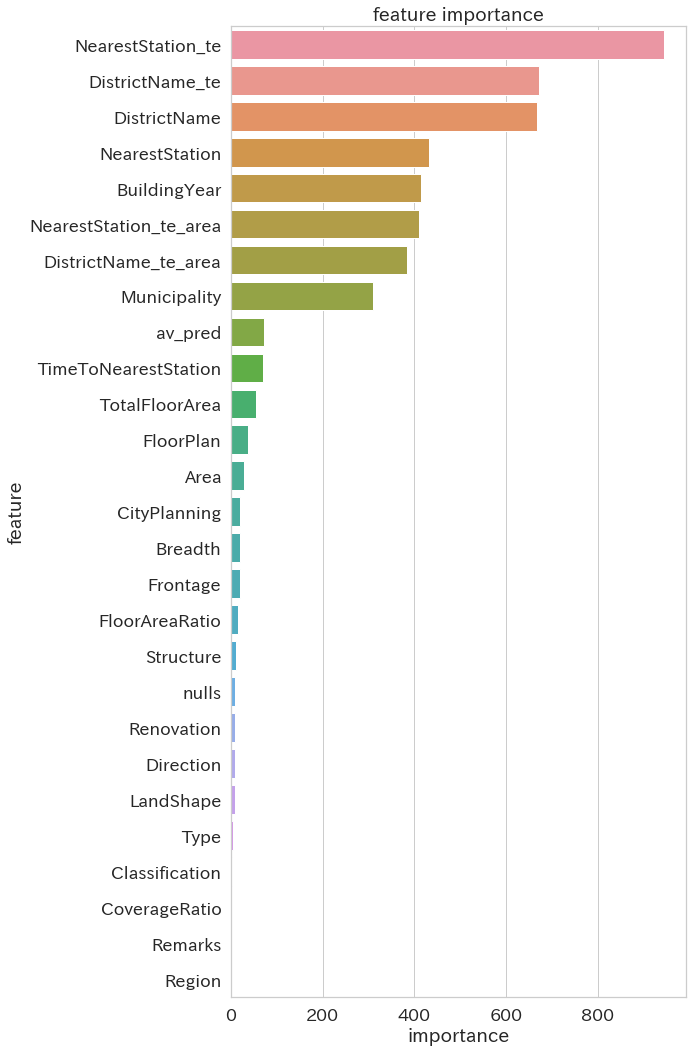

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 227.4871319	best: 227.4871319 (0)	total: 275ms	remaining: 4m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 125.6108269
bestIteration = 110

Shrink model to first 111 iterations.
Partial score of seed 16 fold 4 is: 125.61082685202085
OOF score of seed 16 is: 181.38892899125108
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.31s/it, best loss: 0.0029824628176003953]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9220343287809097
Partial score of fold 1 is: 0.9121536738565532
Partial score of fold 2 is: 0.9176742730125114
Partial score of fold 3 is: 0.9209929490275596
Pa

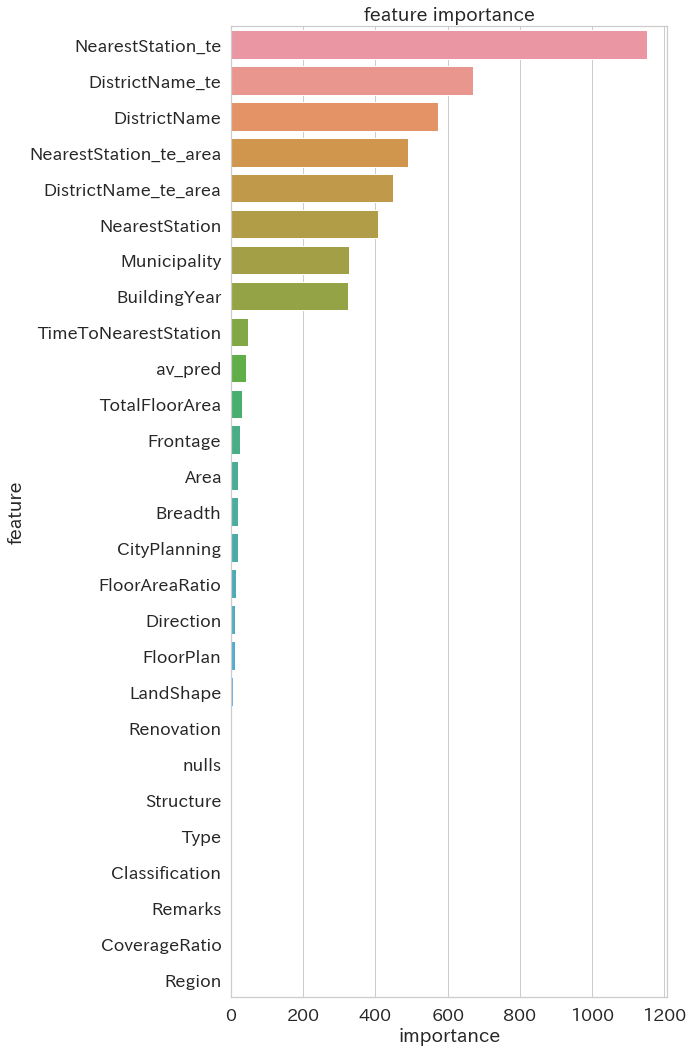

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 251.7864875	best: 251.7864875 (0)	total: 282ms	remaining: 4m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 163.4447188
bestIteration = 137

Shrink model to first 138 iterations.
Partial score of seed 17 fold 0 is: 163.44471879636905
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.24s/it, best loss: 0.002316451391292884]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8954079796626956
Partial score of fold 1 is: 0.8951558319280235
Partial score of fold 2 is: 0.8707673770103707
Partial score of fold 3 is: 0.8824196414670634
Partial score of fold 4 is: 0.8836790063083699


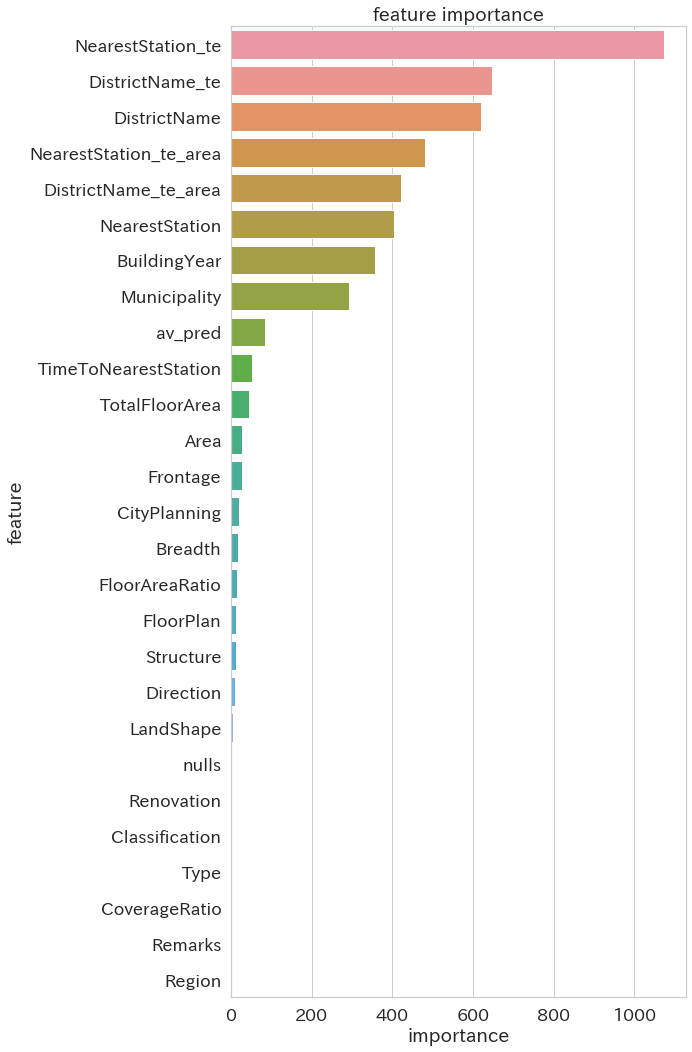

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 362.8934218	best: 362.8934218 (0)	total: 286ms	remaining: 4m 45s
500:	learn: 83.3249806	test: 204.6445544	best: 204.6445544 (500)	total: 2m 10s	remaining: 2m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 202.6060017
bestIteration = 612

Shrink model to first 613 iterations.
Partial score of seed 17 fold 1 is: 202.60600170354812
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it, best loss: 0.002655955769103935]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8742769444786963
Partial score of fold 1 is: 0.8842548256337647
Partial score of fold 2 is: 0.87291134111009

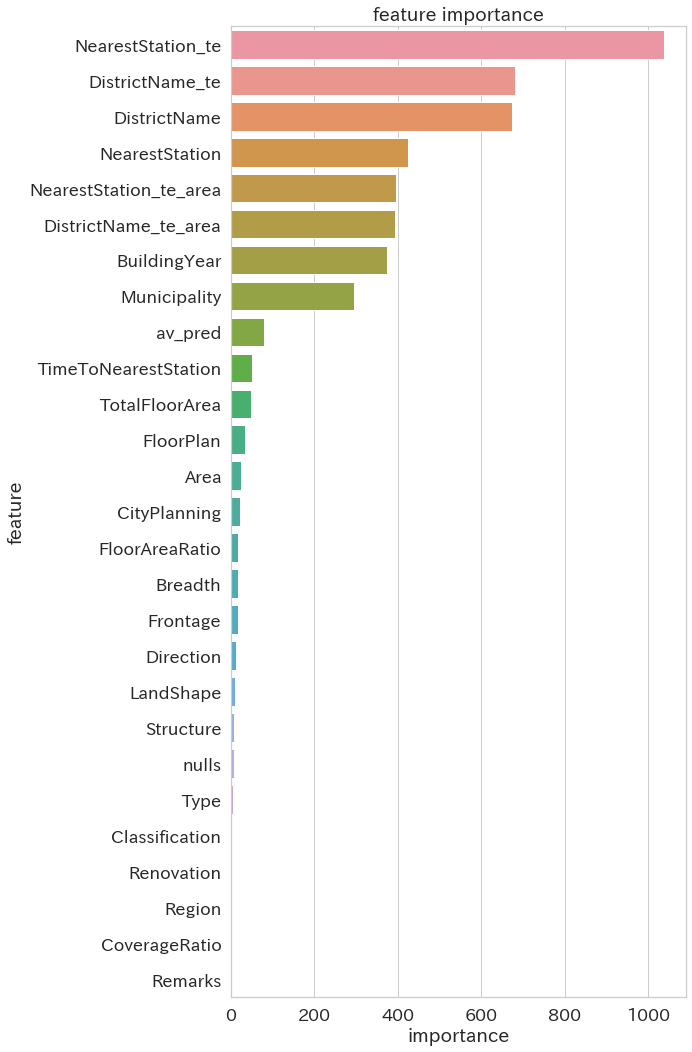

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 304.9706707	best: 304.9706707 (0)	total: 282ms	remaining: 4m 41s
500:	learn: 83.5246945	test: 216.2999890	best: 215.8550933 (429)	total: 2m 9s	remaining: 2m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 215.4526052
bestIteration = 533

Shrink model to first 534 iterations.
Partial score of seed 17 fold 2 is: 215.45260524892603
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it, best loss: 0.0035478359789706815]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8584101521115677
Partial score of fold 1 is: 0.8769819258153395
Partial score of fold 2 is: 0.868098903849527

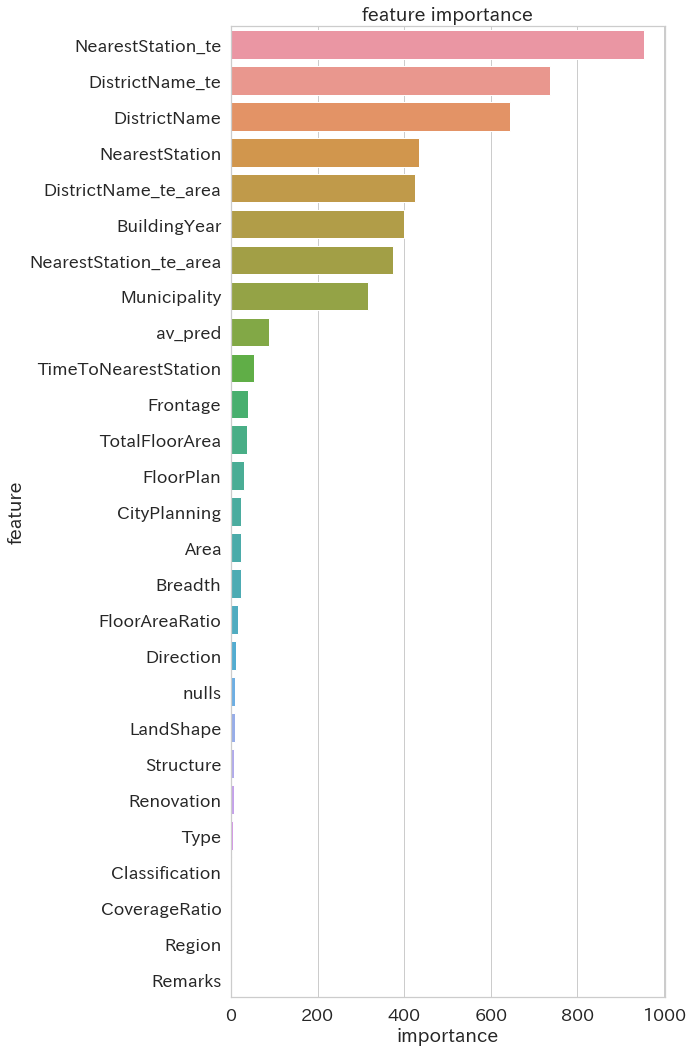

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 217.6363534	best: 217.6363534 (0)	total: 282ms	remaining: 4m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 162.4266913
bestIteration = 13

Shrink model to first 14 iterations.
Partial score of seed 17 fold 3 is: 162.42669134078156
100%|███████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it, best loss: 0.004756152071786257]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.870714562797383
Partial score of fold 1 is: 0.8687972710318561
Partial score of fold 2 is: 0.8708723363977773
Partial score of fold 3 is: 0.8573029851808929
Partial score of fold 4 is: 0.8771614848053634
OO

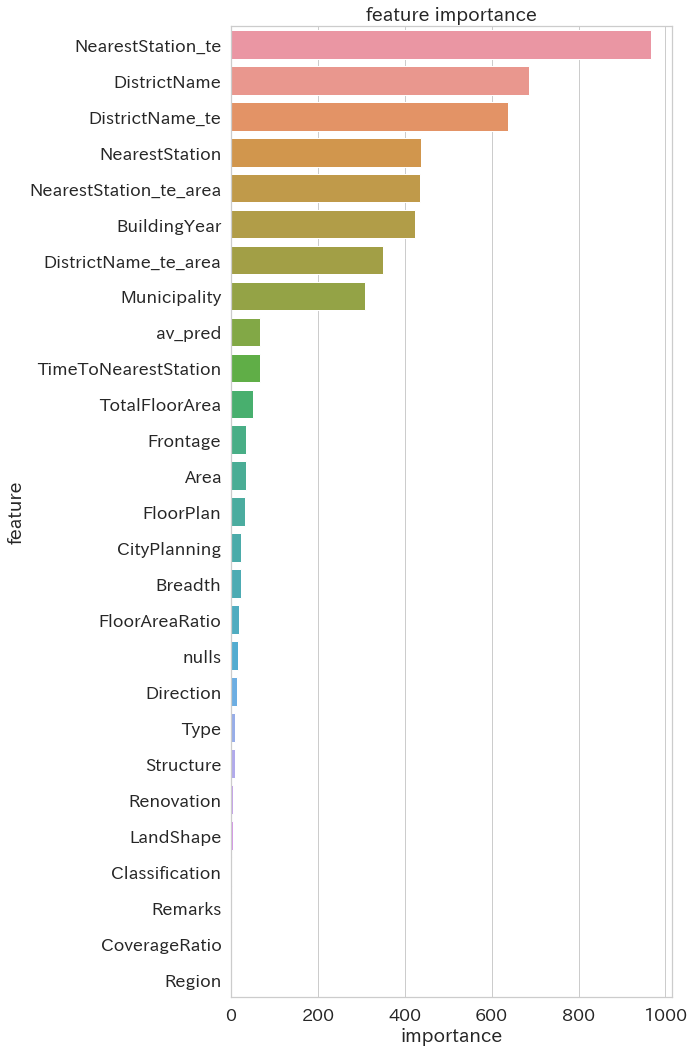

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 307.5885871	best: 307.5885871 (0)	total: 281ms	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 223.8262959
bestIteration = 263

Shrink model to first 264 iterations.
Partial score of seed 17 fold 4 is: 223.82629586879946
OOF score of seed 17 is: 193.55126259168486
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.23s/it, best loss: 0.0031288400128373084]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.9150423286619742
Partial score of fold 1 is: 0.9122139268578814
Partial score of fold 2 is: 0.915841114355863
Partial score of fold 3 is: 0.9097875679378197
Par

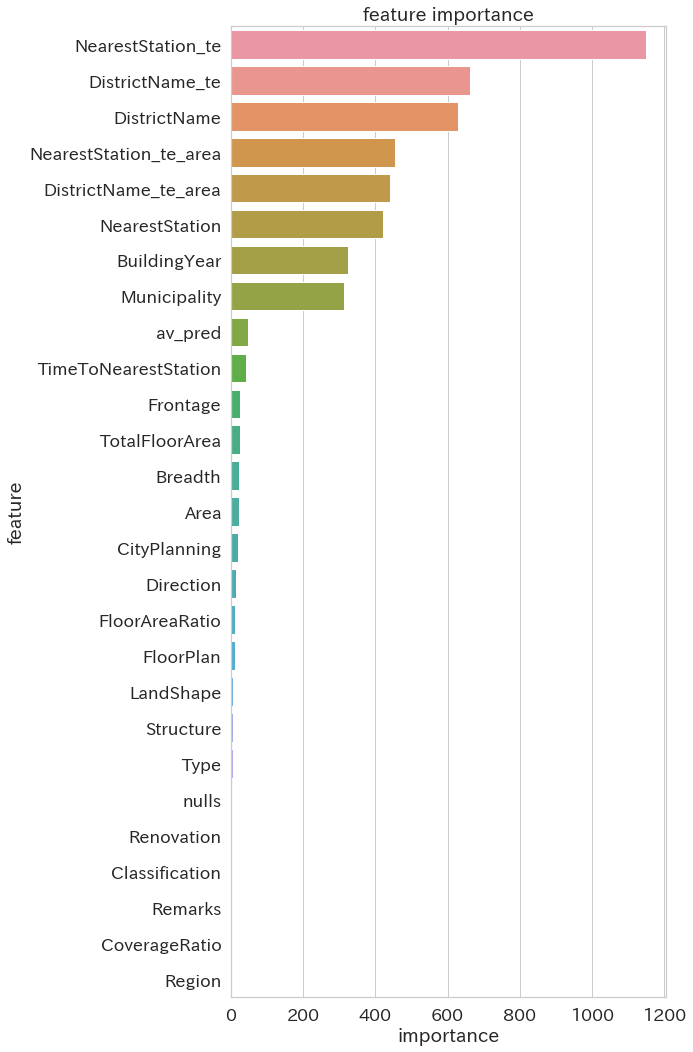

Learning rate set to 0.13359
0:	learn: 302.6780618	test: 267.8353231	best: 267.8353231 (0)	total: 282ms	remaining: 4m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 166.7607841
bestIteration = 185

Shrink model to first 186 iterations.
Partial score of seed 18 fold 0 is: 166.76078411682911
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.28s/it, best loss: 0.0026529387888476474]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8884467523717492
Partial score of fold 1 is: 0.8743607434528704
Partial score of fold 2 is: 0.8798293509739046
Partial score of fold 3 is: 0.889373376147312
Partial score of fold 4 is: 0.8916257983333455
O

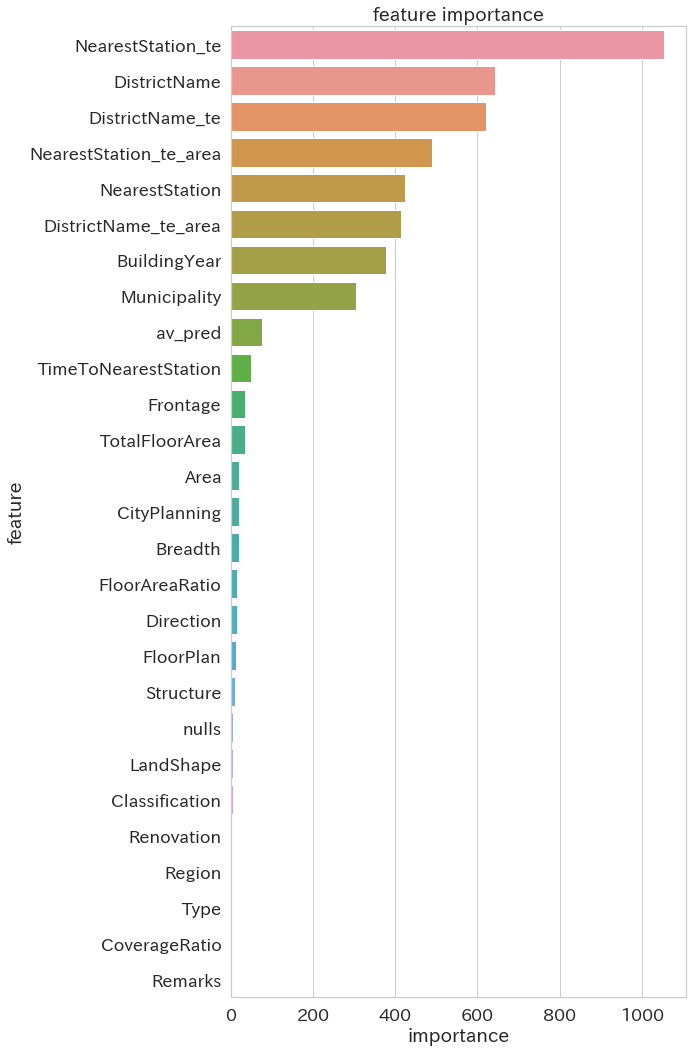

Learning rate set to 0.133587
0:	learn: 277.2913152	test: 358.5805459	best: 358.5805459 (0)	total: 281ms	remaining: 4m 40s
500:	learn: 83.3249806	test: 205.0335957	best: 205.0335957 (500)	total: 2m 10s	remaining: 2m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 203.1540006
bestIteration = 612

Shrink model to first 613 iterations.
Partial score of seed 18 fold 1 is: 203.15400060292862
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.40s/it, best loss: 0.0032629682036857677]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.874246838378224
Partial score of fold 1 is: 0.8714766209722393
Partial score of fold 2 is: 0.853945758525466

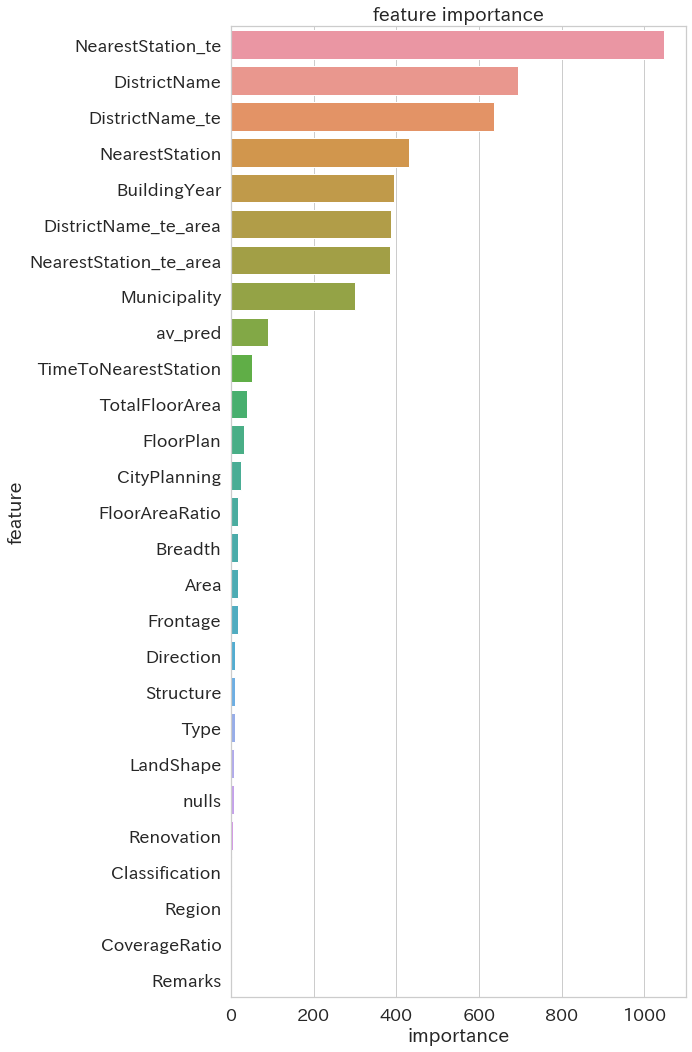

Learning rate set to 0.133665
0:	learn: 306.6171166	test: 243.8683124	best: 243.8683124 (0)	total: 279ms	remaining: 4m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 172.465529
bestIteration = 141

Shrink model to first 142 iterations.
Partial score of seed 18 fold 2 is: 172.46552898554208
100%|██████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it, best loss: 0.0031730704473617033]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8703573037929789
Partial score of fold 1 is: 0.8688638251613846
Partial score of fold 2 is: 0.8802176478412236
Partial score of fold 3 is: 0.8785098696117699
Partial score of fold 4 is: 0.8853057915888445


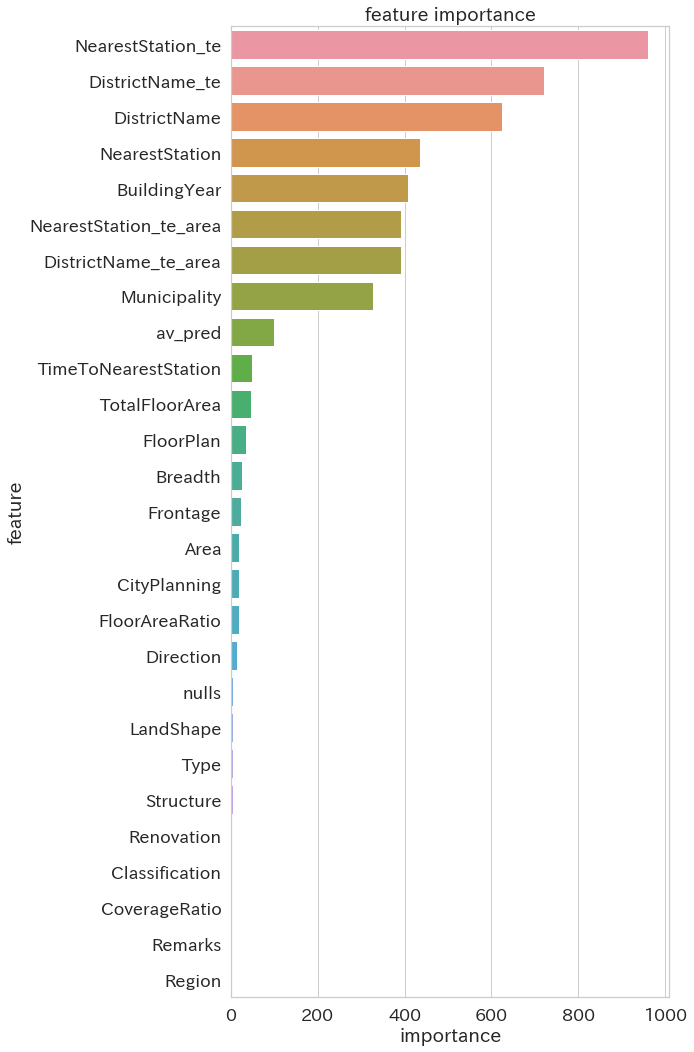

Learning rate set to 0.133661
0:	learn: 300.6585189	test: 308.9985565	best: 308.9985565 (0)	total: 284ms	remaining: 4m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 232.1485829
bestIteration = 22

Shrink model to first 23 iterations.
Partial score of seed 18 fold 3 is: 232.14858293099041
100%|████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.35s/it, best loss: 0.00414718231865685]
lgb_params = {'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'num_threads': 4, 'bagging_fraction': 0.8, 'bagging_freq': 22, 'feature_fraction': 0.5, 'learning_rate': 0.0378637218239646, 'max_depth': 9, 'min_child_weight': 3.0, 'num_leaves': 48, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 1.2000000000000002}
Partial score of fold 0 is: 0.8770080291802635
Partial score of fold 1 is: 0.8711339732997613
Partial score of fold 2 is: 0.8695539825135874
Partial score of fold 3 is: 0.8675644519185772
Partial score of fold 4 is: 0.8561750055933881
O

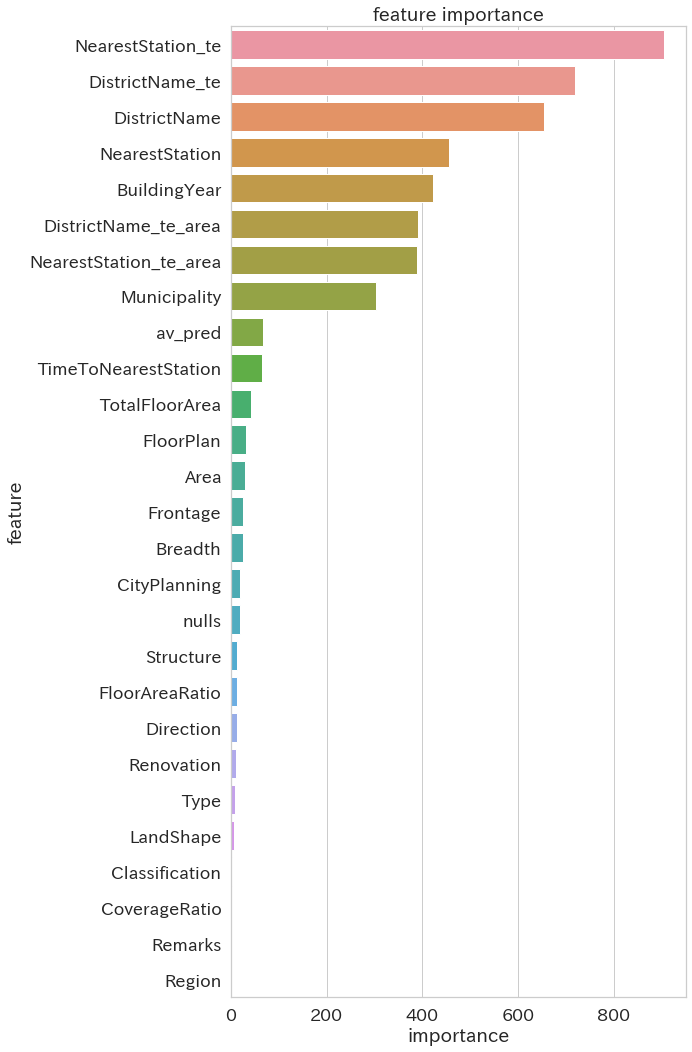

Learning rate set to 0.133591
0:	learn: 293.2981711	test: 329.6996374	best: 329.6996374 (0)	total: 280ms	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 242.1279334
bestIteration = 73

Shrink model to first 74 iterations.
Partial score of seed 18 fold 4 is: 242.12793337513563
OOF score of seed 18 is: 203.33136600228516
Seed averaging score is: 174.6884698322835


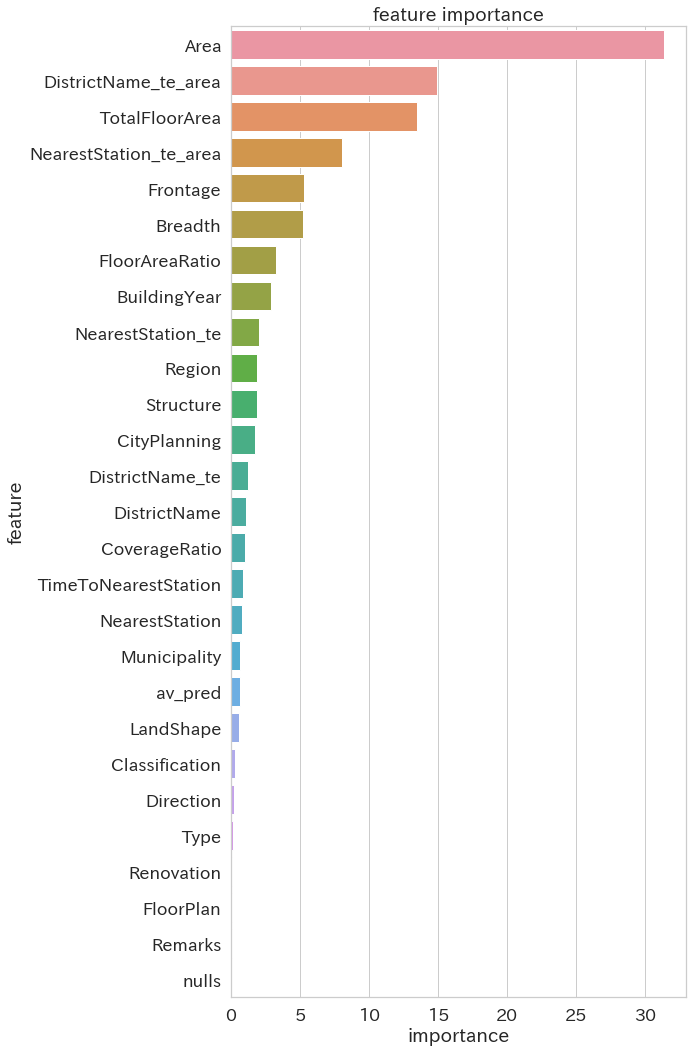

In [63]:
cb_model = CB_Model(train=train_df,
                    test=test_df,
                    features=features,
                    categoricals=categoricals,
                    n_splits=10,
                    n_seeds=3,
                    seeds=np.arange(10, 19, 1))

In [64]:
train_df["cb_pred"] = cb_model.oof_pred
test_df["cb_pred"] = cb_model.y_pred

238.22061359808995


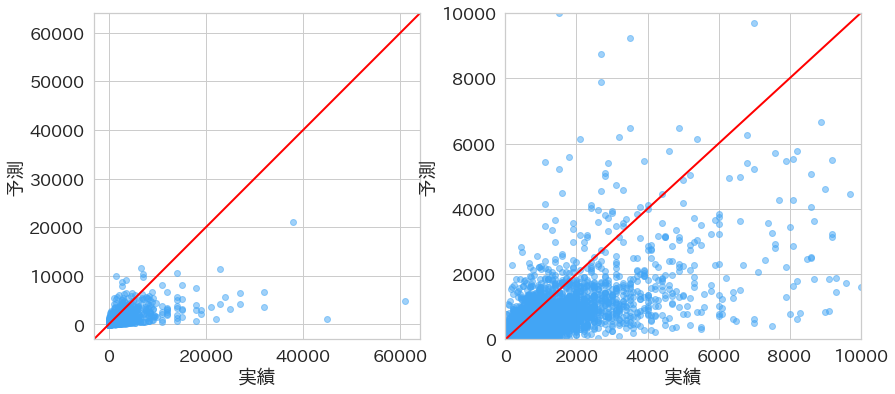

In [66]:
print(evaluate(train_df["y"], train_df["cb_pred"], method="rmse"))
plt.subplot(1, 2, 1)
plt.scatter(train_df["y"], train_df["cb_pred"], alpha=0.5, linewidths=1)
axes = plt.gca()
xmin, xmax = axes.get_xlim()
plt.plot((xmin, xmax), (xmin, xmax), color="red")
plt.xlabel("実績")
plt.ylabel("予測")
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
axes.set_aspect("equal")

plt.subplot(1, 2, 2)
plt.scatter(train_df["y"], train_df["cb_pred"], alpha=0.5, linewidths=1)
xmin, xmax = 0, 10000
plt.plot((xmin, xmax), (xmin, xmax), color="red")
plt.xlabel("実績")
plt.ylabel("予測")
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
axes.set_aspect("equal")
plt.show()

(array([1.1340e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 5.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 3.0000e+00, 5.0000e+00, 1.1000e+01,
        6.0000e+00, 9.0000e+00, 1.1000e+01, 1.6000e+01, 1.4000e+01,
        2.0000e+01, 2.2000e+01, 3.8000e+01, 4.1000e+01, 4.9000e+01,
        7.3000e+01, 1.1100e+02, 1.1900e+02, 1.5300e+02, 2.0400e+02,
        2.5200e+02, 3.8400e+02, 5.6200e+02, 8.0100e+02, 1.1400e+03,
        1.8550e+03, 2.6880e+03, 4.2350e+03, 6.5570e+03, 9.5730e+03,
        1.3752e+04, 1.9061e+04, 2.5388e+04, 3.1807e+04, 3.6673e+04,
        3.9273e+04, 3.7094e+04, 3.1381e+04, 2.3570e+04, 1.6185e+04,
        1.0833e+04, 7.3580e+03, 5.6360e+03, 4.2800e+03, 3.2540e+03,
        2.7160e+03, 2.1280e+03, 1.7350e+03, 1.38

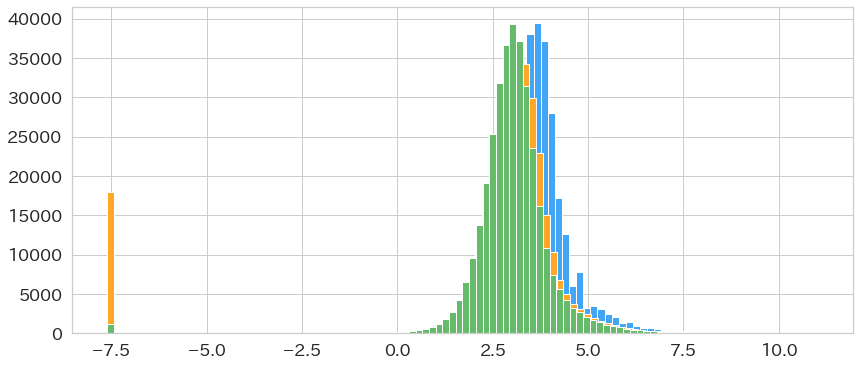

In [67]:
plt.hist(train_df["y"].apply(np.log), bins=100)
plt.hist(np.clip(train_df["lgb_pred"], 0.0005, a_max=None).apply(np.log), bins=100)
plt.hist(np.clip(train_df["cb_pred"], 0.0005, a_max=None).apply(np.log), bins=100)

In [68]:
submission = pd.DataFrame()
submission["id"] = row_id
submission["y"] = np.clip(test_df["cb_pred"], 0.005, a_max=None)
submission

id           y
0          1   16.564720
1          2   13.664493
2          3  117.482251
3          4   14.973750
4          5   39.010866
...      ...         ...
34839  34840   52.423557
34840  34841   27.875850
34841  34842   11.303269
34842  34843   42.783441
34843  34844   35.486597

[34844 rows x 2 columns]

In [79]:
submission.to_csv("case34_sgkf_AV_FE_TE-All-Area_cb_10seeds_178.70.csv", index=False)

## ElasticNet

In [ ]:
train_df[categoricals]
train_df[set(train_df.columns) - set(categoricals)]

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
class EN_Model(Base_Model):
    
    def __init__(self, train, test, features, categoricals=[], n_splits=5, n_seeds=3, seeds=np.arange(0, 3, 1), verbose=True):
        features_ = features.copy()
        categoricals_ = categoricals.copy()
        onehot_cols = []
        if len(categoricals_) > 0:
            for cat in categoricals_:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train[[cat]])
                test_cats = enc.transform(test[[cat]])
                cat_cols = ["{}_{}".format(cat, str(col)) for col in enc.active_features_]
                onehot_cols += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train = pd.concat([train, train_cats], axis=1)
                test = pd.concat([test, test_cats], axis=1)
        scalar = StandardScaler()
        numbers = list(set(features_) - set(categoricals_))
        train[numbers] = scalar.fit_transform(train[numbers])
        test[numbers] = scalar.transform(test[numbers])
        features_ += onehot_cols
        categoricals_ += onehot_cols
        print(train[features_].shape)
        super().__init__(train, test, features_, categoricals_, n_splits, n_seeds, seeds, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 0 if self.verbose else 0
        clf = ElasticNet(**self.params, fit_intercept=True, normalize=False, precompute=False, copy_X=True, \
                         tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
        return clf.fit(train_set[0], train_set[1])
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        return (x_train, y_train), (x_val, y_val)
    
    def reconvert_dataset(self, x_train, y_train, x_val, y_val):
        return x_train, y_train, x_val, y_val
    
    def get_params(self, X, y):
        params = {"alpha": 1.0, "l1_ratio": 0.5, "max_iter": 500}
        return params
    
    def get_feature_importance(self, model):
        return None
        
    def display_feature_importance(self, feature_importance_df):
        return None

In [ ]:
en_model = EN_Model(train=train_df,
                    test=test_df,
                    features=features,
                    categoricals=categoricals,
                    n_splits=5,
                    n_seeds=3,
                    seeds=np.arange(0, 3, 1))

## Randam forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
class RF_Model(Base_Model):
    
    def train_model(self, x_train, y_train):
        verbosity = 0 if self.verbose else 0
        clf = RandomForestRegressor(**self.params, n_jobs=4, verbose=verbosity)
        return clf.fit(x_train, y_train)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        return x_train, y_train
        
    def get_params(self):
        params = {'n_estimators': 100, 'max_depth': 23, 'max_features': 1.0}
        return params
    
    def get_feature_importance(self, model, importance_type="split"):
        return model.feature_importances_
        
    def display_feature_importance(self, feature_importance_df):
        feature_importance_df["importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)
        cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
        plt.figure(figsize=(10, 15))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title("feature importance")
        plt.tight_layout()
        plt.show()

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true))) 
    
def hyperopt_random_forest(X: pd.DataFrame, y: pd.Series):
    # Group2Fold
    tra_index, val_index = KFold(n_splits=2, shuffle=True, random_state=1).split(unique_installation_ids)
 
    tra_groups, val_groups = unique_installation_ids[tra_index[0]], unique_installation_ids[val_index[0]]
    is_tra = installation_id.isin(tra_groups)
    is_val = installation_id.isin(val_groups)
    
    X_tra, y_tra = X[is_tra], y[is_tra]
    X_val, y_val = X[is_val], y[is_val]
   
    space = {
        "max_depth": hp.choice("max_depth", np.linspace(2, 20, 10, dtype=int)),
        "max_features": hp.quniform("max_features", 0.9, 1.0, 0.1),
    }
    
    def objective(hyperparams):
        
        clf = RandomForestRegressor(**hyperparams, n_estimators=100, verbose=0, n_jobs=4)
        clf.fit(X_tra, y_tra)
        pred = clf.predict(X_val)
        score = root_mean_squared_error(y_val, pred)

        return {"loss": score, "status": STATUS_OK}

    trials = Trials()
    best = hyperopt.fmin(fn=objective, space=space, trials=trials,
                         algo=tpe.suggest, max_evals=10, verbose=1,
                         rstate=np.random.RandomState(1))

    rf_params = space_eval(space, best) 
    print("rf_params = {0}".format({**rf_params}))
    
    return {**rf_params}

In [ ]:
rf_params = {'n_estimators': 100, 'max_depth': 10, 'max_features': 0.9}

In [ ]:
%%time
#rf_params = hyperopt_random_forest(X_train, y_train)

rfm = RandomForestRegressor(**rf_params, n_jobs=4, verbose=0)
rfm.fit(X_train, y_train)

pred_train = rfm.predict(X_train)
pred_test = rfm.predict(X_test)

# Plot feature importance
importances = pd.DataFrame({"feature": X_train.columns, "importance": rfm.feature_importances_})
display_importances(importances)

In [ ]:
del rfm
gc.collect()

In [ ]:
%%time
from sklearn.model_selection import ParameterGrid
param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

rf_oof_pred = pred_train
pred_train_prob_summary["rf_all"] = rf_oof_pred

max_qwk = 0
max_coef = None
for param in tqdm(list(ParameterGrid(param_grid)), total=12):
    a, b, c = param["a"], param["b"], param["c"]
    optR = OptimizedRounder()
    optR.fit(pred_train, y_train, "nelder-mead", [a, b, c])
    coefficients = optR.coefficients()
    opt_preds = optR.predict(pred_train, coefficients)
    score = qwk(opt_preds.get_values(), y_train)
    if max_qwk < score:
        max_qwk = score
        max_coef = coefficients
coefficients = max_coef
max_qwk, max_coef

In [ ]:
rf_pred = pred_test
pred_test_prob_summary["rf_all"] = pred_test

# qwk_opt_rg
rf_pred[rf_pred <= coefficients[0]] = 0
rf_pred[np.where(np.logical_and(rf_pred > coefficients[0], rf_pred <= coefficients[1]))] = 1
rf_pred[np.where(np.logical_and(rf_pred > coefficients[1], rf_pred <= coefficients[2]))] = 2
rf_pred[rf_pred > coefficients[2]] = 3

pred_class_summary["rf_opt_all"] = rf_pred.astype("int")

In [ ]:
%%time
rf_model = RF_Model(train_df, test_df, features, categoricals=categoricals, n_splits=5, n_seeds=3, seeds=np.arange(3, 6, 1))

In [ ]:
# 50 Seed averaging score is: 0.5469902180465402
# 100 Seed averaging score is: 0.5551416420009105

In [ ]:
rf_pred = rf_model.y_pred
pred_test_prob_summary["rf_cv"] = rf_model.y_pred

# qwk_per_rg
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(rf_pred, acum * 100)
print(bound)
    
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3

rf_pred = np.array(list(map(classify, rf_pred)))
pred_class_summary["rf_per_cv"] = rf_pred.astype("int")

In [ ]:
# %%time
# from sklearn.model_selection import ParameterGrid
# param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

# rf_oof_pred = rf_model.oof_pred
# pred_train_prob_summary["rf_cv"] = rf_oof_pred

# max_qwk = 0
# max_coef = None
# for param in tqdm(list(ParameterGrid(param_grid)), total=12):
#     a, b, c = param["a"], param["b"], param["c"]
#     optR = OptimizedRounder()
#     optR.fit(rf_oof_pred, y_train, "nelder-mead", [a, b, c])
#     coefficients = optR.coefficients()
#     opt_preds = optR.predict(rf_oof_pred, coefficients)
#     score = qwk(opt_preds.get_values(), y_train)
#     if max_qwk < score:
#         max_qwk = score
#         max_coef = coefficients
# coefficients = max_coef
# max_qwk, max_coef

In [ ]:
rf_pred = rf_model.y_pred

# qwk_opt_rg
rf_pred[rf_pred <= coefficients[0]] = 0
rf_pred[np.where(np.logical_and(rf_pred > coefficients[0], rf_pred <= coefficients[1]))] = 1
rf_pred[np.where(np.logical_and(rf_pred > coefficients[1], rf_pred <= coefficients[2]))] = 2
rf_pred[rf_pred > coefficients[2]] = 3

pred_class_summary["rf_opt_cv"] = rf_pred.astype("int")

In [ ]:
del rf_model
gc.collect()

## NN

In [ ]:
# https://www.kaggle.com/higepon/starter-keras-simple-nn-kfold-cv
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import tensorflow as tf
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Embedding, LayerNormalization, concatenate, BatchNormalization, Flatten
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
class NN_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, n_seeds=3, seeds=np.arange(0, 3, 1), verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ["{}_{}".format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, n_seeds, seeds, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 0 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set["X"].shape[1],)),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu")
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss="mse")
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint("nn_model.w8", save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set["X"], 
                  train_set["y"], 
                  validation_data=(val_set["X"], val_set["y"]),
                  epochs=100,
                  verbose=verbosity,
                  callbacks=[save_best, early_stop])
        model.load_weights("nn_model.w8")
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {"X": x_train, "y": y_train}
        val_set = {"X": x_val, "y": y_val}
        return train_set, val_set
        
    def get_params(self):
        return None
    
    def get_feature_importance(self, importance_type=""):
        return None
    
    def display_feature_importance(self, feature_importance_df):
        return None

In [ ]:
def build_model(X):
       
    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(256, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(32, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(1, activation="relu")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss="mse")
    
    print(model.summary())
    return model

In [ ]:
categoricals = ["session_title"]

if len(categoricals) > 0:
    for cat in categoricals:
        enc = OneHotEncoder()
        train_cats = enc.fit_transform(X_train[[cat]])
        test_cats = enc.transform(X_test[[cat]])
        cat_cols = ["{}_{}".format(cat, str(col)) for col in enc.active_features_]
        features += cat_cols
        train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
        test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
        X_train = pd.concat([X_train, train_cats], axis=1)
        X_test = pd.concat([X_test, test_cats], axis=1)
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [ ]:
%%time
oof = np.zeros(len(train_df.index))
nn_predictions = np.zeros(len(test_df.index))
n_batch_size = 2 ** 5
n_epochs = 50
n_patience = 10
decay_per_epoch = (0.0004-0.0001) / n_epochs

# 学習率
def step_decay(epoch):
    lr = 0.0004
    lr -= decay_per_epoch * epoch
    return lr
lr_decay = LearningRateScheduler(step_decay)

nnm = build_model(X_train)
callbacks = [lr_decay]
nnm.fit(X_train, y_train.astype("float64"), epochs=n_epochs, callbacks=callbacks, verbose=2)

pred_train = nnm.predict(X_train)
pred_train =  pred_train.reshape(pred_train.shape[0])

pred_test = nnm.predict(X_test)
pred_test =  pred_test.reshape(pred_test.shape[0])

In [ ]:
del nnm
gc.collect()

In [ ]:
%%time
from sklearn.model_selection import ParameterGrid
param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

nn_oof_pred = pred_train
pred_train_prob_summary["nn_all"] = nn_oof_pred

max_qwk = 0
max_coef = None
for param in tqdm(list(ParameterGrid(param_grid)), total=12):
    a, b, c = param["a"], param["b"], param["c"]
    optR = OptimizedRounder()
    optR.fit(pred_train, y_train, "nelder-mead", [a, b, c])
    coefficients = optR.coefficients()
    opt_preds = optR.predict(pred_train, coefficients)
    score = qwk(opt_preds.get_values(), y_train)
    if max_qwk < score:
        max_qwk = score
        max_coef = coefficients
coefficients = max_coef
max_qwk, max_coef

In [ ]:
nn_pred = pred_test
pred_test_prob_summary["nn_all"] = pred_test

# qwk_opt_rg
nn_pred[nn_pred <= coefficients[0]] = 0
nn_pred[np.where(np.logical_and(nn_pred > coefficients[0], nn_pred <= coefficients[1]))] = 1
nn_pred[np.where(np.logical_and(nn_pred > coefficients[1], nn_pred <= coefficients[2]))] = 2
nn_pred[nn_pred > coefficients[2]] = 3

pred_class_summary["nn_opt_all"] = nn_pred.astype("int")

In [ ]:
nn_model = NN_Model(train_df, test_df, features, categoricals=categoricals, n_splits=5, n_seeds=3, seeds=np.arange(6, 9, 1))

In [ ]:
# 50, 128 Seed averaging score is: 0.5712944469265342
# 50, 200 Seed averaging score is: 0.5790046586564301
# 50, 256 Seed averaging score is: 0.5816427541003732
# 25, 256 Seed averaging score is: 0.5751721582019647

In [ ]:
nn_pred = nn_model.y_pred
pred_test_prob_summary["nn_cv"] = nn_model.y_pred

# qwk_per_rg
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(nn_pred, acum * 100)
print(bound)
    
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3

nn_pred = np.array(list(map(classify, nn_pred)))
pred_class_summary["nn_per_cv"] = nn_pred.astype("int")

In [ ]:
# %%time
# from sklearn.model_selection import ParameterGrid
# param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

# nn_oof_pred = nn_model.oof_pred
# pred_train_prob_summary["nn_cv"] = nn_oof_pred

# max_qwk = 0
# max_coef = None
# for param in tqdm(list(ParameterGrid(param_grid)), total=12):
#     a, b, c = param["a"], param["b"], param["c"]
#     optR = OptimizedRounder()
#     optR.fit(nn_oof_pred, y_train, "nelder-mead", [a, b, c])
#     coefficients = optR.coefficients()
#     opt_preds = optR.predict(nn_oof_pred, coefficients)
#     score = qwk(opt_preds.get_values(), y_train)
#     if max_qwk < score:
#         max_qwk = score
#         max_coef = coefficients
# coefficients = max_coef
# max_qwk, max_coef

In [ ]:
nn_pred = nn_model.y_pred

# qwk_opt_rg
nn_pred[nn_pred <= coefficients[0]] = 0
nn_pred[np.where(np.logical_and(nn_pred > coefficients[0], nn_pred <= coefficients[1]))] = 1
nn_pred[np.where(np.logical_and(nn_pred > coefficients[1], nn_pred <= coefficients[2]))] = 2
nn_pred[nn_pred > coefficients[2]] = 3

pred_class_summary["nn_opt_cv"] = nn_pred.astype("int")
pred_class_summary

In [ ]:
del nn_model
gc.collect()

# submission

In [67]:
submission = pd.read_csv("case028ar_local_212.5914_neg0_rs100.csv")
submission_2 = pd.read_csv("case45_sgkf_AV_FE_TE-All-Area_lgb_208.58.csv")
submission["y"] = (submission["y"] + submission_2["y"]) / 2
submission

id           y
0          0   24.892388
1          1   19.057841
2          2  155.710163
3          3   21.857587
4          4   57.960327
...      ...         ...
34839  34839   28.023241
34840  34840   24.770816
34841  34841   24.549299
34842  34842   34.370819
34843  34843   29.450831

[34844 rows x 2 columns]

In [80]:
submission.to_csv("case31_sgkf_AV_FE_TE_205.85.csv", index=False)

In [68]:
sub = pd.read_csv("case028ar_local_212.5914_neg0_rs100.csv")
sub["y2"] = submission["y"]
sub["y3"] = pd.read_csv("case23_sgkf_AV_FE_lgb_210.62.csv")["y"]
sub["y4"] = pd.read_csv("case45_sgkf_AV_FE_TE-All-Area_lgb_208.58.csv")["y"]
sub

id           y          y2          y3          y4
0          0   25.604178   24.892388   33.410425   24.180597
1          1   17.037661   19.057841   16.301257   21.078022
2          2  172.377265  155.710163  233.835308  139.043061
3          3   21.759956   21.857587   27.706253   21.955217
4          4   62.173907   57.960327   98.378221   53.746747
...      ...         ...         ...         ...         ...
34839  34839    9.531969   28.023241  104.198057   46.514514
34840  34840   15.859320   24.770816   23.966695   33.682312
34841  34841   10.689588   24.549299   50.356130   38.409010
34842  34842   27.356482   34.370819   45.384996   41.385157
34843  34843   20.608523   29.450831   36.759894   38.293139

[34844 rows x 5 columns]

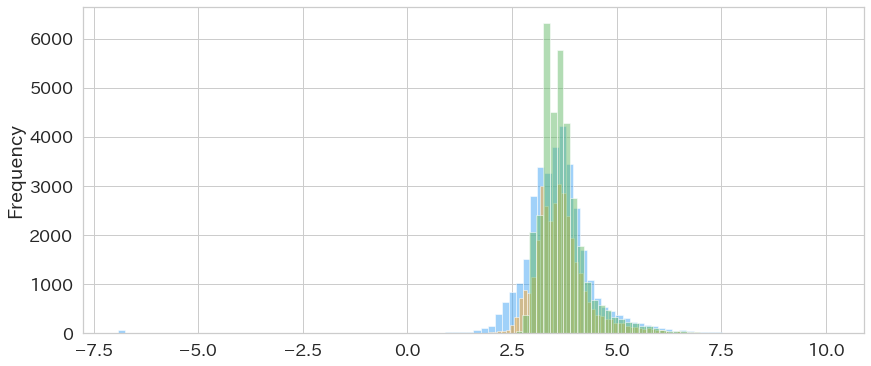

In [69]:
sub["y"].apply(np.log).plot(kind="hist", bins=100, alpha=0.5)
sub["y2"].apply(np.log).plot(kind="hist", bins=100, alpha=0.5)
# sub["y3"].apply(np.log).plot(kind="hist", bins=100, alpha=0.5)
sub["y4"].apply(np.log).plot(kind="hist", bins=100, alpha=0.5)

In [65]:
sub.describe()

id             y            y2            y3            y4
count  34844.000000  34844.000000  34844.000000  34844.000000  34844.000000
mean   17421.500000     60.420133     57.494860     63.101047     57.203313
std    10058.740726    212.629767    153.423817    169.344669    142.844707
min        0.000000      0.001000      0.001000      1.183878      1.352028
25%     8710.750000     23.232185     28.142149     24.048470     26.920610
50%    17421.500000     35.821873     36.975339     37.431102     36.800749
75%    26132.250000     52.685168     49.808215     56.887957     49.937381
max    34843.000000  23332.639027  12734.970576  14058.362984  10480.451077

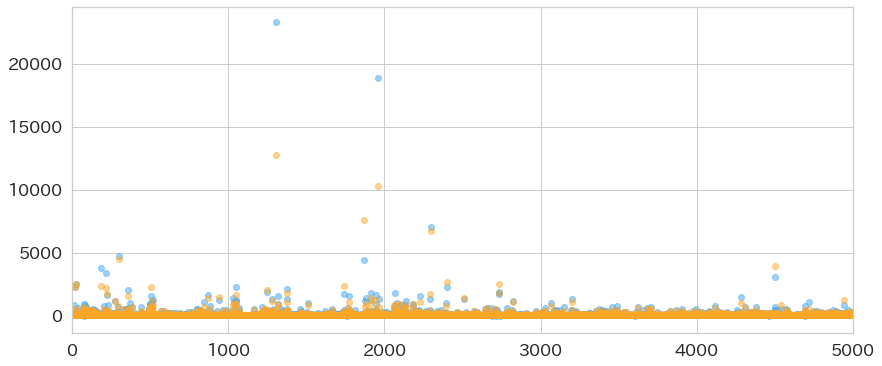

In [66]:
plt.scatter(sub["id"], sub["y"], alpha=0.5)
plt.scatter(sub["id"], sub["y2"], alpha=0.5)
# plt.scatter(sub["id"], sub["y3"], alpha=0.5)
plt.xlim([0, 5000])
plt.show()